#1 Construct the dataset
Visit each website for 10 times, capturing the packets exchanged with your client in specific .pcap files\
Use your preferred approach:\
Bash script invoking tcpdump + curl 10 times for every website?\
pyshark.sniff_continuously?\
others?\
Hint 1: convert .pcap files into .csv with tshark for easier management with DataFrames (not mandatory, but helpful)\
Hint 2: use a clever capture filter (avoid capturing traffic which is not part of the HTTPS exchange…) Use DNS queries or other information (e.g., think about the traffic exchanged in a Colab VM…)\



In [5]:
!pip install pyshark
!pip install requests
!apt install tshark
!pip install nest-asyncio
!apt-get install net-tools tcpdump iputils-ping dnsutils tshark curl
!pip install --pre scapy[basic]
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl
  libspandsp2 libspeexdsp1 libwireshark-data libwireshark15 libwiretap12 libwsutil13
  wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader geoipupdate geoip-database geoip-database-extra libjs-leaflet
  libjs-leaflet.markercluster wireshark-doc
The following NEW packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl
  libspandsp2 libspeexdsp1 libwireshark-data libwireshark15 libwiretap12 libwsutil13 tshark
  wireshark-common
0 upgraded, 16 newly installed, 0 to remove and 39 not upgraded.
Need to get 23.0 MB of archives.
After this operation, 120 MB of additional disk space w

In [154]:
import subprocess
import time
import csv
import os
import numpy as np


if not os.path.exists('/content/drive/MyDrive/Pcap'):
        os.makedirs('/content/drive/MyDrive/Pcap')
def capture_save_pcap(url, n, pacp_path):

    name = url.split("//")[1]
    pcap_file = pacp_path + f'{name}_{n}_pyshark.pcap'
    command = f"sudo tcpdump -i eth0 -w {pcap_file} port 443 and host {name}"

    # Capture packets
    pcap_file_size = 0
    attempts = 0
    while pcap_file_size == 0:  # if pcap file is empty, continue to access
        attempts += 1
        proc = subprocess.Popen(command, shell=True)
        time.sleep(2)
        response = subprocess.run(f"sudo curl -k {url}", shell=True, stdout=subprocess.PIPE)
        time.sleep(5)
        proc.terminate()
        proc.wait()

        pcap_file_size = os.path.getsize(pcap_file)
        if pcap_file_size == 0:
            print(f'Empty pcap file captured for {name}, retrying {attempts}th time')

    print(f'Capture done for {name}, file size: {pcap_file_size} bytes, on attempt {attempts} for {n} times')
    return pcap_file



# define website list
websites = [
    "https://www.indiatimes.com",
    "https://www.washingtonpost.com",
    "https://www.ndtv.com",
    "https://www.cnbc.com",
    "https://www.timesofindia.com",
    "https://www.express.co.uk",
    "https://www.rt.com",
    "https://www.news18.com",
    "https://www.nypost.com",
    "https://www.abc.net.au"
]









In [ ]:

pcap_path = '/content/drive/MyDrive/Pcap/'
# access each website and cpture data packet
for n in range(1, 11):
    for url in websites:  # capture 10 packets
        capture_save_pcap(url, n, pcap_path)

In [8]:
import os
import subprocess


def pcaptocsv(pcap_file):
    file_name = os.path.basename(pcap_file)
    if file_name.endswith('.pcap'):  # Check if the file is a pcap file
        csv_file_name = file_name.replace('.pcap', '.csv')
        csv_path = os.path.join(csv_dir, csv_file_name)
        command = ['tshark', '-r', pcap_file,
                   '-Y', 'tcp',
                   '-T', 'fields',
                   '-e', 'frame.number',
                   '-e', 'frame.time',
                   '-e', 'ip.src',
                   '-e', 'ip.len',
                   '-e', 'ip.dst',
                   '-e', 'ip.proto',
                   '-e', 'tcp.srcport',
                   '-e', 'tcp.dstport',
                   '-e', 'tcp.ack',
                   '-e', 'tcp.flags',
                   '-E', 'header=y',
                   '-E', 'separator=,',
                   '-E', 'quote=d']
        subprocess.run(command, stdout=open(csv_path, 'w'))



In [72]:
# Directory paths
pcap_dir = '/content/drive/MyDrive/Pcap'
csv_dir = '/content/drive/MyDrive/Csv'

# Create the CSV directory if it doesn't exist
os.makedirs(csv_dir, exist_ok=True)

# Iterate over files in the pcap directory and convert pcap to csv
for file_name in os.listdir(pcap_dir):
    file_path = os.path.join(pcap_dir, file_name)
    if os.path.isfile(file_path):
        pcaptocsv(file_path)


# Extract biflow features from each capture (both uplink 		and downlink)
Num packets up/down\
Total bytes up/down\
Min/max/mean/std packet size up/down\
Min/max/mean/std IAT up/down\

# Create a dataset DataFrame where each row corresponds to a capture file (make sure to append the ground truth information to it!)

In [6]:
import pandas as pd
def extract_features(df_flow, filename):
  flow_features = {}
  up_link_flow = df_flow[df_flow["ip.src"].str.split('.').str[0] == "172"]
  down_link_flow = df_flow[df_flow["ip.src"].str.split('.').str[0] != "172"]
  #flow_features["num_packest"] = len(df_flow)
  flow_features["num_up_link"] = len(up_link_flow)
  flow_features["num_down_link"] = len(down_link_flow)

  up_link_pkt_size = up_link_flow['ip.len'].astype(float)
  flow_features['total_bytes_up_link'] = up_link_pkt_size.sum()
  flow_features['min_pkt_size_up_link'] = up_link_pkt_size.min()
  flow_features['max_pkt_size_up_link'] = up_link_pkt_size.max()
  flow_features['mean_pkt_size_up_link'] = up_link_pkt_size.mean()
  flow_features['std_pkt_size_up_link'] = up_link_pkt_size.std()
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
  iat_up_link = up_link_flow['frame.time'].diff(1).dt.total_seconds().iloc[1:]
  flow_features['min_iat_up_link'] = iat_up_link.min()
  flow_features['max_iat_up_link'] = iat_up_link.max()
  flow_features['mean_iat_up_link'] = iat_up_link.mean()
  flow_features['std_iat_up_link'] = iat_up_link.std()
  print(up_link_flow['frame.time'])




  down_link_pkt_size = down_link_flow['ip.len'].astype(float)
  flow_features['total_bytes_down_link'] = down_link_pkt_size.sum()
  flow_features['min_pkt_size_down_link'] = down_link_pkt_size.min()
  flow_features['max_pkt_size_down_link'] = down_link_pkt_size.max()
  flow_features['mean_pkt_size_down_link'] = down_link_pkt_size.mean()
  flow_features['std_pkt_size_down_link'] = down_link_pkt_size.std()
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
  iat_down_link = down_link_flow['frame.time'].diff(1).dt.total_seconds().iloc[1:]
  flow_features['min_iat_down_link'] = iat_down_link.min()
  flow_features['max_iat_down_link'] = iat_down_link.max()
  flow_features['mean_iat_down_link'] = iat_down_link.mean()
  flow_features['std_iat_down_link'] = iat_down_link.std()



  flow_features['app'] = filename.split('.')[1]


  return flow_features







In [9]:
pcap_dir = '/content/drive/MyDrive/Pcap'
csv_dir = '/content/drive/MyDrive/Csv'
dataset_list = []
for csv_name in os.listdir(csv_dir):
  print("Processing the file:", csv_name)
  df = pd.read_csv(csv_dir +'/'+ csv_name)
  df_tcp = df[df["ip.proto"]==6]
  flow_features = extract_features(df_tcp, csv_name)
  display(flow_features)
  dataset_list.append(pd.DataFrame([flow_features]))


dataset = pd.DataFrame()
dataset = pd.concat(dataset_list, ignore_index=True)

display(dataset)

Processing the file: www.rt.com_6_pyshark.csv
0     2024-03-21 18:01:46.778261
2     2024-03-21 18:01:46.904438
3     2024-03-21 18:01:46.908432
6     2024-03-21 18:01:47.036372
7     2024-03-21 18:01:47.039195
                 ...            
310   2024-03-21 18:07:23.322348
312   2024-03-21 18:07:23.448544
313   2024-03-21 18:07:23.449108
314   2024-03-21 18:07:23.449316
316   2024-03-21 18:07:23.577327
Name: frame.time, Length: 161, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 161,
 'num_down_link': 157,
 'total_bytes_up_link': 12653.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 78.59006211180125,
 'std_pkt_size_up_link': 90.455961111588,
 'min_iat_up_link': 5.4e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.1049941624999997,
 'std_iat_up_link': 12.969569067271824,
 'total_bytes_down_link': 1951264.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12428.433121019109,
 'std_pkt_size_down_link': 14411.341784481843,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.1581617756410254,
 'std_iat_down_link': 13.152058162520175,
 'app': 'rt'}

Processing the file: www.express.co.uk_1_pyshark.csv
0      2024-03-21 17:54:29.856915
2      2024-03-21 17:54:29.876782
3      2024-03-21 17:54:29.880762
6      2024-03-21 17:54:29.900478
8      2024-03-21 17:54:29.901491
                  ...            
1748   2024-03-21 18:07:15.364035
1750   2024-03-21 18:07:15.364917
1751   2024-03-21 18:07:15.367916
1752   2024-03-21 18:07:15.368230
1755   2024-03-21 18:07:15.387901
Name: frame.time, Length: 890, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 890,
 'num_down_link': 867,
 'total_bytes_up_link': 54660.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.41573033707865,
 'std_pkt_size_up_link': 55.61129943787544,
 'min_iat_up_link': 3.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.8611147199100112,
 'std_iat_up_link': 8.493742713178754,
 'total_bytes_down_link': 4509305.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18616.0,
 'mean_pkt_size_down_link': 5201.0438292964245,
 'std_pkt_size_down_link': 3532.2528529928763,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.8839620381062355,
 'std_iat_down_link': 8.606794819639987,
 'app': 'express'}

Processing the file: www.abc.net.au_7_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 18:03:30.337472
2     2024-03-21 18:03:30.355632
3     2024-03-21 18:03:30.358482
6     2024-03-21 18:03:30.376506
8     2024-03-21 18:03:30.376586
                 ...            
607   2024-03-21 18:07:44.901287
608   2024-03-21 18:07:44.901715
610   2024-03-21 18:07:44.918858
612   2024-03-21 18:07:44.918984
614   2024-03-21 18:07:44.919096
Name: frame.time, Length: 309, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 309,
 'num_down_link': 306,
 'total_bytes_up_link': 19368.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.679611650485434,
 'std_pkt_size_up_link': 59.91219987077082,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.866258,
 'mean_iat_up_link': 0.8265637142857145,
 'std_iat_up_link': 8.31304660094226,
 'total_bytes_down_link': 950063.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3104.781045751634,
 'std_pkt_size_down_link': 1641.6497103748975,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.884356,
 'mean_iat_down_link': 0.8346348918032787,
 'std_iat_down_link': 8.355365433317225,
 'app': 'abc'}

Processing the file: www.ndtv.com_7_pyshark.csv
0     2024-03-21 18:02:38.560127
2     2024-03-21 18:02:38.578505
3     2024-03-21 18:02:38.581297
6     2024-03-21 18:02:38.600898
8     2024-03-21 18:02:38.601002
                 ...            
739   2024-03-21 18:06:53.531902
740   2024-03-21 18:06:53.536738
741   2024-03-21 18:06:53.537033
744   2024-03-21 18:06:53.554191
746   2024-03-21 18:06:53.554386
Name: frame.time, Length: 357, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 357,
 'num_down_link': 390,
 'total_bytes_up_link': 21848.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.19887955182073,
 'std_pkt_size_up_link': 55.84496193947999,
 'min_iat_up_link': 5.1e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.7162760084269664,
 'std_iat_up_link': 7.758162497305541,
 'total_bytes_down_link': 1673644.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4291.3948717948715,
 'std_pkt_size_down_link': 3272.5764506221144,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.6554652596401027,
 'std_iat_down_link': 7.425199135442092,
 'app': 'ndtv'}

Processing the file: www.rt.com_7_pyshark.csv
0     2024-03-21 18:03:07.622935
2     2024-03-21 18:03:07.748330
3     2024-03-21 18:03:07.751253
6     2024-03-21 18:03:07.877390
7     2024-03-21 18:03:07.879594
                 ...            
232   2024-03-21 18:07:23.322348
234   2024-03-21 18:07:23.448544
235   2024-03-21 18:07:23.449108
236   2024-03-21 18:07:23.449316
238   2024-03-21 18:07:23.577327
Name: frame.time, Length: 122, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 122,
 'num_down_link': 118,
 'total_bytes_up_link': 9776.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 80.1311475409836,
 'std_pkt_size_up_link': 92.7957813606938,
 'min_iat_up_link': 5.4e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.1153255537190083,
 'std_iat_up_link': 13.08383942273844,
 'total_bytes_down_link': 1560598.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13225.406779661016,
 'std_pkt_size_down_link': 15431.596644955545,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.1865753931623932,
 'std_iat_down_link': 13.32230180388347,
 'app': 'rt'}

Processing the file: www.rt.com_8_pyshark.csv
0     2024-03-21 18:04:28.766922
2     2024-03-21 18:04:28.892671
3     2024-03-21 18:04:28.895525
6     2024-03-21 18:04:29.022675
7     2024-03-21 18:04:29.025014
                 ...            
150   2024-03-21 18:07:23.322348
152   2024-03-21 18:07:23.448544
153   2024-03-21 18:07:23.449108
154   2024-03-21 18:07:23.449316
156   2024-03-21 18:07:23.577327
Name: frame.time, Length: 80, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 80,
 'num_down_link': 78,
 'total_bytes_up_link': 6707.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 83.8375,
 'std_pkt_size_up_link': 98.88293087781805,
 'min_iat_up_link': 0.000105,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.2127899367088606,
 'std_iat_up_link': 13.556606684712625,
 'total_bytes_down_link': 1169903.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 14998.75641025641,
 'std_pkt_size_down_link': 17587.763766793007,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.2686362077922073,
 'std_iat_down_link': 13.750154521877684,
 'app': 'rt'}

Processing the file: www.washingtonpost.com_7_pyshark.csv
0      2024-03-21 18:02:23.312383
2      2024-03-21 18:02:23.324292
3      2024-03-21 18:02:23.328687
6      2024-03-21 18:02:23.351471
8      2024-03-21 18:02:23.351581
                  ...            
1256   2024-03-21 18:06:46.177505
1258   2024-03-21 18:06:46.177596
1260   2024-03-21 18:06:46.178074
1262   2024-03-21 18:06:46.178241
1266   2024-03-21 18:06:46.203389
Name: frame.time, Length: 577, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 577,
 'num_down_link': 691,
 'total_bytes_up_link': 33528.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.107452339688045,
 'std_pkt_size_up_link': 44.14089928292245,
 'min_iat_up_link': 5.7e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.4564079965277778,
 'std_iat_up_link': 5.478156755943823,
 'total_bytes_down_link': 9406385.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13612.713458755426,
 'std_pkt_size_down_link': 15524.827299058796,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.3809846753623188,
 'std_iat_down_link': 5.007590471716101,
 'app': 'washingtonpost'}

Processing the file: www.ndtv.com_8_pyshark.csv
0     2024-03-21 18:04:00.032261
2     2024-03-21 18:04:00.050473
3     2024-03-21 18:04:00.054450
6     2024-03-21 18:04:00.073417
8     2024-03-21 18:04:00.073575
                 ...            
550   2024-03-21 18:06:53.531902
551   2024-03-21 18:06:53.536738
552   2024-03-21 18:06:53.537033
555   2024-03-21 18:06:53.554191
557   2024-03-21 18:06:53.554386
Name: frame.time, Length: 265, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 265,
 'num_down_link': 293,
 'total_bytes_up_link': 16249.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.31698113207547,
 'std_pkt_size_up_link': 56.14724195123661,
 'min_iat_up_link': 7.8e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.6572807765151516,
 'std_iat_up_link': 7.5115960947329885,
 'total_bytes_down_link': 1255247.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4284.1194539249145,
 'std_pkt_size_down_link': 3272.2070569194007,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.5941919794520548,
 'std_iat_down_link': 7.145216934796696,
 'app': 'ndtv'}

Processing the file: www.express.co.uk_6_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 18:01:39.590821
2     2024-03-21 18:01:39.610747
3     2024-03-21 18:01:39.613987
6     2024-03-21 18:01:39.635052
8     2024-03-21 18:01:39.636721
                 ...            
867   2024-03-21 18:07:15.364035
869   2024-03-21 18:07:15.364917
870   2024-03-21 18:07:15.367916
871   2024-03-21 18:07:15.368230
874   2024-03-21 18:07:15.387901
Name: frame.time, Length: 442, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 442,
 'num_down_link': 434,
 'total_bytes_up_link': 27174.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.47963800904977,
 'std_pkt_size_up_link': 55.82610506042735,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.7614446258503401,
 'std_iat_up_link': 7.942533638819514,
 'total_bytes_down_link': 2252993.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14332.0,
 'mean_pkt_size_down_link': 5191.228110599079,
 'std_pkt_size_down_link': 3504.4132770932647,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.7754669907621247,
 'std_iat_down_link': 8.016978177398135,
 'app': 'express'}

Processing the file: www.abc.net.au_1_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0      2024-03-21 17:55:06.634724
2      2024-03-21 17:55:06.654022
3      2024-03-21 17:55:06.658006
6      2024-03-21 17:55:06.676473
8      2024-03-21 17:55:06.676533
                  ...            
1467   2024-03-21 18:07:44.901287
1468   2024-03-21 18:07:44.901715
1470   2024-03-21 18:07:44.918858
1472   2024-03-21 18:07:44.918984
1474   2024-03-21 18:07:44.919096
Name: frame.time, Length: 738, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 738,
 'num_down_link': 737,
 'total_bytes_up_link': 46632.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.1869918699187,
 'std_pkt_size_up_link': 61.19089727448339,
 'min_iat_up_link': 3.7e-05,
 'max_iat_up_link': 89.440548,
 'mean_iat_up_link': 1.0288797449118048,
 'std_iat_up_link': 9.239000876178633,
 'total_bytes_down_link': 2373702.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3220.7625508819538,
 'std_pkt_size_down_link': 1844.673930420745,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.458339,
 'mean_iat_down_link': 1.0302516100543477,
 'std_iat_down_link': 9.247222964636038,
 'app': 'abc'}

Processing the file: www.express.co.uk_9_pyshark.csv
0     2024-03-21 18:05:51.910998
2     2024-03-21 18:05:51.931177
3     2024-03-21 18:05:51.934114
6     2024-03-21 18:05:51.954943
8     2024-03-21 18:05:51.956325
                 ...            
346   2024-03-21 18:07:15.364035
348   2024-03-21 18:07:15.364917
349   2024-03-21 18:07:15.367916
350   2024-03-21 18:07:15.368230
353   2024-03-21 18:07:15.387901
Name: frame.time, Length: 178, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 178,
 'num_down_link': 177,
 'total_bytes_up_link': 10932.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.41573033707865,
 'std_pkt_size_up_link': 55.73683300492052,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 82.826971,
 'mean_iat_up_link': 0.4716209209039549,
 'std_iat_up_link': 6.225408289611892,
 'total_bytes_down_link': 900928.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 12904.0,
 'mean_pkt_size_down_link': 5089.988700564972,
 'std_pkt_size_down_link': 3335.322077927102,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.84644,
 'mean_iat_down_link': 0.47418642613636375,
 'std_iat_down_link': 6.2445417039469175,
 'app': 'express'}

Processing the file: www.news18.com_10_pyshark.csv
0     2024-03-21 18:07:30.484617
2     2024-03-21 18:07:30.502966
3     2024-03-21 18:07:30.505944
6     2024-03-21 18:07:30.523783
8     2024-03-21 18:07:30.523876
                 ...            
241   2024-03-21 18:07:30.653355
242   2024-03-21 18:07:30.693391
244   2024-03-21 18:07:30.703387
246   2024-03-21 18:07:30.703525
248   2024-03-21 18:07:30.710996
Name: frame.time, Length: 125, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 125,
 'num_down_link': 124,
 'total_bytes_up_link': 7316.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.528,
 'std_pkt_size_up_link': 47.517496947219655,
 'min_iat_up_link': 7.5e-05,
 'max_iat_up_link': 0.040036,
 'mean_iat_up_link': 0.0018256370967741937,
 'std_iat_up_link': 0.004765769840019925,
 'total_bytes_down_link': 686933.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 24668.0,
 'mean_pkt_size_down_link': 5539.782258064516,
 'std_pkt_size_down_link': 4898.713830803492,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.051926,
 'mean_iat_down_link': 0.0016918699186991872,
 'std_iat_down_link': 0.005487867384108613,
 'app': 'news18'}

Processing the file: www.washingtonpost.com_2_pyshark.csv
0      2024-03-21 17:55:21.008150
2      2024-03-21 17:55:21.020056
3      2024-03-21 17:55:21.023964
6      2024-03-21 17:55:21.036667
8      2024-03-21 17:55:21.036713
                  ...            
2792   2024-03-21 18:06:46.177505
2793   2024-03-21 18:06:46.177596
2795   2024-03-21 18:06:46.178074
2797   2024-03-21 18:06:46.178241
2801   2024-03-21 18:06:46.203389
Name: frame.time, Length: 1261, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1261,
 'num_down_link': 1542,
 'total_bytes_up_link': 73285.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.116574147501986,
 'std_pkt_size_up_link': 44.76917753126194,
 'min_iat_up_link': 4.1e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.5438057452380952,
 'std_iat_up_link': 6.036637639214052,
 'total_bytes_down_link': 21437327.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13902.28728923476,
 'std_pkt_size_down_link': 15658.622161395175,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.4446356943543153,
 'std_iat_down_link': 5.462643863486646,
 'app': 'washingtonpost'}

Processing the file: www.timesofindia.com_1_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 17:54:22.466462
2     2024-03-21 17:54:22.478147
3     2024-03-21 17:54:22.481264
6     2024-03-21 17:54:22.768152
8     2024-03-21 17:54:22.768227
                 ...            
254   2024-03-21 18:07:07.863656
256   2024-03-21 18:07:07.870907
257   2024-03-21 18:07:07.871191
259   2024-03-21 18:07:07.891002
261   2024-03-21 18:07:07.891107
Name: frame.time, Length: 145, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 145,
 'num_down_link': 117,
 'total_bytes_up_link': 14614.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.78620689655172,
 'std_pkt_size_up_link': 132.12600184666405,
 'min_iat_up_link': 4.3e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 5.315448923611111,
 'std_iat_up_link': 20.648686831521402,
 'total_bytes_down_link': 75165.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 642.4358974358975,
 'std_pkt_size_down_link': 850.4555917435381,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 6.598385775862067,
 'std_iat_down_link': 22.84286525116188,
 'app': 'timesofindia'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: www.abc.net.au_6_pyshark.csv
0     2024-03-21 18:02:08.995539
2     2024-03-21 18:02:09.013674
3     2024-03-21 18:02:09.016989
6     2024-03-21 18:02:09.035458
8     2024-03-21 18:02:09.035573
                 ...            
759   2024-03-21 18:07:44.901287
760   2024-03-21 18:07:44.901715
762   2024-03-21 18:07:44.918858
764   2024-03-21 18:07:44.918984
766   2024-03-21 18:07:44.919096
Name: frame.time, Length: 385, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 385,
 'num_down_link': 382,
 'total_bytes_up_link': 24148.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.72207792207792,
 'std_pkt_size_up_link': 59.98487791939172,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.866258,
 'mean_iat_up_link': 0.8748009296875002,
 'std_iat_up_link': 8.50676820015983,
 'total_bytes_down_link': 1187553.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3108.777486910995,
 'std_pkt_size_down_link': 1611.8384362533654,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.884356,
 'mean_iat_down_link': 0.8816419422572178,
 'std_iat_down_link': 8.54179595991717,
 'app': 'abc'}

Processing the file: www.abc.net.au_2_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0      2024-03-21 17:56:36.291012
2      2024-03-21 17:56:36.308949
3      2024-03-21 17:56:36.311728
6      2024-03-21 17:56:36.329506
8      2024-03-21 17:56:36.329559
                  ...            
1310   2024-03-21 18:07:44.901287
1311   2024-03-21 18:07:44.901715
1313   2024-03-21 18:07:44.918858
1315   2024-03-21 18:07:44.918984
1317   2024-03-21 18:07:44.919096
Name: frame.time, Length: 660, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 660,
 'num_down_link': 658,
 'total_bytes_up_link': 41748.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.25454545454546,
 'std_pkt_size_up_link': 61.38469502698822,
 'min_iat_up_link': 3.7e-05,
 'max_iat_up_link': 87.913905,
 'mean_iat_up_link': 1.0146101426403642,
 'std_iat_up_link': 9.136460856549725,
 'total_bytes_down_link': 2136056.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3246.285714285714,
 'std_pkt_size_down_link': 1868.4345030167615,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.932093,
 'mean_iat_down_link': 1.0176716484018264,
 'std_iat_down_link': 9.152223993277063,
 'app': 'abc'}

Processing the file: www.express.co.uk_10_pyshark.csv
0     2024-03-21 18:07:14.908966
2     2024-03-21 18:07:14.929367
3     2024-03-21 18:07:14.933527
6     2024-03-21 18:07:14.953680
8     2024-03-21 18:07:14.954755
                 ...            
168   2024-03-21 18:07:15.364035
170   2024-03-21 18:07:15.364917
171   2024-03-21 18:07:15.367916
172   2024-03-21 18:07:15.368230
175   2024-03-21 18:07:15.387901
Name: frame.time, Length: 88, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 88,
 'num_down_link': 89,
 'total_bytes_up_link': 5414.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.52272727272727,
 'std_pkt_size_up_link': 56.206102109251184,
 'min_iat_up_link': 0.00012,
 'max_iat_up_link': 0.245065,
 'mean_iat_up_link': 0.005505,
 'std_iat_up_link': 0.02695830137496158,
 'total_bytes_down_link': 450651.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 12904.0,
 'mean_pkt_size_down_link': 5063.494382022472,
 'std_pkt_size_down_link': 3493.3046093517355,
 'min_iat_down_link': 2e-06,
 'max_iat_down_link': 0.182509,
 'mean_iat_down_link': 0.0052123181818181825,
 'std_iat_down_link': 0.021405813766382367,
 'app': 'express'}

Processing the file: www.indiatimes.com_1_pyshark.csv
0     2024-03-21 17:53:44.320789
2     2024-03-21 17:53:44.338898
3     2024-03-21 17:53:44.343180
6     2024-03-21 17:53:44.361028
8     2024-03-21 17:53:44.361086
                 ...            
306   2024-03-21 18:06:28.964706
307   2024-03-21 18:06:28.964910
310   2024-03-21 18:06:28.975838
312   2024-03-21 18:06:28.975932
314   2024-03-21 18:06:28.976010
Name: frame.time, Length: 171, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 171,
 'num_down_link': 144,
 'total_bytes_up_link': 18036.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.47368421052632,
 'std_pkt_size_up_link': 121.22387242033659,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 89.492339,
 'mean_iat_up_link': 4.497971888235294,
 'std_iat_up_link': 19.070119425215616,
 'total_bytes_down_link': 72410.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 502.84722222222223,
 'std_pkt_size_down_link': 798.1323945017325,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.510279,
 'mean_iat_down_link': 5.347112062937063,
 'std_iat_down_link': 20.69762708270828,
 'app': 'indiatimes'}

Processing the file: www.washingtonpost.com_9_pyshark.csv
0     2024-03-21 18:05:12.792415
2     2024-03-21 18:05:12.804498
3     2024-03-21 18:05:12.808891
6     2024-03-21 18:05:12.821924
8     2024-03-21 18:05:12.822013
                 ...            
632   2024-03-21 18:06:46.177505
633   2024-03-21 18:06:46.177596
635   2024-03-21 18:06:46.178074
637   2024-03-21 18:06:46.178241
641   2024-03-21 18:06:46.203389
Name: frame.time, Length: 297, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 297,
 'num_down_link': 346,
 'total_bytes_up_link': 17218.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.97306397306397,
 'std_pkt_size_up_link': 43.52995956932856,
 'min_iat_up_link': 5.7e-05,
 'max_iat_up_link': 72.979819,
 'mean_iat_up_link': 0.31557761486486485,
 'std_iat_up_link': 4.317112054191877,
 'total_bytes_down_link': 4575327.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13223.488439306358,
 'std_pkt_size_down_link': 15530.196151738077,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 72.993952,
 'mean_iat_down_link': 0.2707226405797101,
 'std_iat_down_link': 3.9993537241777,
 'app': 'washingtonpost'}

Processing the file: www.abc.net.au_10_pyshark.csv
0     2024-03-21 18:07:44.770464
2     2024-03-21 18:07:44.788663
3     2024-03-21 18:07:44.791507
6     2024-03-21 18:07:44.809616
8     2024-03-21 18:07:44.809725
                 ...            
142   2024-03-21 18:07:44.901287
143   2024-03-21 18:07:44.901715
145   2024-03-21 18:07:44.918858
147   2024-03-21 18:07:44.918984
149   2024-03-21 18:07:44.919096
Name: frame.time, Length: 75, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 75,
 'num_down_link': 75,
 'total_bytes_up_link': 4716.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.88,
 'std_pkt_size_up_link': 61.11905970693154,
 'min_iat_up_link': 7.6e-05,
 'max_iat_up_link': 0.018199,
 'mean_iat_up_link': 0.00200854054054054,
 'std_iat_up_link': 0.004237737281316202,
 'total_bytes_down_link': 237437.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3165.826666666667,
 'std_pkt_size_down_link': 1983.945811523859,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.020343,
 'mean_iat_down_link': 0.0017653378378378378,
 'std_iat_down_link': 0.0040585020763183296,
 'app': 'abc'}

Processing the file: www.news18.com_9_pyshark.csv
0     2024-03-21 18:06:07.029298
2     2024-03-21 18:06:07.047658
3     2024-03-21 18:06:07.050541
6     2024-03-21 18:06:07.068691
8     2024-03-21 18:06:07.068896
                 ...            
200   2024-03-21 18:06:07.202185
201   2024-03-21 18:06:07.205709
202   2024-03-21 18:06:07.206019
204   2024-03-21 18:06:07.226554
206   2024-03-21 18:06:07.226678
Name: frame.time, Length: 96, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 96,
 'num_down_link': 111,
 'total_bytes_up_link': 5820.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.625,
 'std_pkt_size_up_link': 54.0976213116524,
 'min_iat_up_link': 7.8e-05,
 'max_iat_up_link': 0.020535,
 'mean_iat_up_link': 0.0020776842105263158,
 'std_iat_up_link': 0.004343967155020509,
 'total_bytes_down_link': 686246.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 24668.0,
 'mean_pkt_size_down_link': 6182.396396396396,
 'std_pkt_size_down_link': 5612.409264347385,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.031367,
 'mean_iat_down_link': 0.0016292000000000001,
 'std_iat_down_link': 0.004225010655868436,
 'app': 'news18'}

Processing the file: www.timesofindia.com_8_pyshark.csv
0    2024-03-21 18:04:14.476440
2    2024-03-21 18:04:14.488455
3    2024-03-21 18:04:14.493730
6    2024-03-21 18:04:14.505304
8    2024-03-21 18:04:14.505436
10   2024-03-21 18:04:14.505678
12   2024-03-21 18:04:14.516603
13   2024-03-21 18:04:14.517021
14   2024-03-21 18:04:14.517176
17   2024-03-21 18:04:14.528479
19   2024-03-21 18:04:14.533706
20   2024-03-21 18:04:14.533876
22   2024-03-21 18:04:14.547370
24   2024-03-21 18:04:14.547537
25   2024-03-21 18:05:44.821757
27   2024-03-21 18:05:44.833557
28   2024-03-21 18:05:44.836552
31   2024-03-21 18:05:44.848150
33   2024-03-21 18:05:44.848232
35   2024-03-21 18:05:44.848595
37   2024-03-21 18:05:44.859253
38   2024-03-21 18:05:44.859818
39   2024-03-21 18:05:44.860019
42   2024-03-21 18:05:44.872033
44   2024-03-21 18:05:44.878656
45   2024-03-21 18:05:44.878872
47   2024-03-21 18:05:44.889866
49   2024-03-21 18:05:44.889969
51   2024-03-21 18:05:44.890068
52   2024-03-21 

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 43,
 'num_down_link': 34,
 'total_bytes_up_link': 4357.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 101.32558139534883,
 'std_pkt_size_up_link': 133.90503403358247,
 'min_iat_up_link': 8.2e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 4.1289206428571426,
 'std_iat_up_link': 18.680795960895974,
 'total_bytes_down_link': 22484.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 661.2941176470588,
 'std_pkt_size_down_link': 866.6157279696403,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 5.254622272727273,
 'std_iat_down_link': 21.003501479695732,
 'app': 'timesofindia'}

Processing the file: www.indiatimes.com_6_pyshark.csv
0     2024-03-21 18:00:54.707722
2     2024-03-21 18:00:54.718960
3     2024-03-21 18:00:54.723255
6     2024-03-21 18:00:54.734573
8     2024-03-21 18:00:54.734661
                 ...            
150   2024-03-21 18:06:28.964706
151   2024-03-21 18:06:28.964910
154   2024-03-21 18:06:28.975838
156   2024-03-21 18:06:28.975932
158   2024-03-21 18:06:28.976010
Name: frame.time, Length: 86, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 86,
 'num_down_link': 73,
 'total_bytes_up_link': 9038.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.09302325581395,
 'std_pkt_size_up_link': 121.32723159795158,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 3.9325680941176464,
 'std_iat_up_link': 17.789883151436147,
 'total_bytes_down_link': 36251.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 496.5890410958904,
 'std_pkt_size_down_link': 797.1506346498627,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 4.642458097222222,
 'std_iat_down_link': 19.266360440026258,
 'app': 'indiatimes'}

Processing the file: www.rt.com_9_pyshark.csv
0     2024-03-21 18:05:59.104836
2     2024-03-21 18:05:59.230560
3     2024-03-21 18:05:59.233879
6     2024-03-21 18:05:59.360543
7     2024-03-21 18:05:59.364777
8     2024-03-21 18:05:59.365196
9     2024-03-21 18:05:59.365377
10    2024-03-21 18:05:59.365488
11    2024-03-21 18:05:59.365610
19    2024-03-21 18:05:59.490279
20    2024-03-21 18:05:59.490665
22    2024-03-21 18:05:59.615430
25    2024-03-21 18:05:59.740631
27    2024-03-21 18:05:59.740934
29    2024-03-21 18:05:59.741213
31    2024-03-21 18:05:59.866063
33    2024-03-21 18:05:59.866881
35    2024-03-21 18:05:59.867070
37    2024-03-21 18:05:59.867750
39    2024-03-21 18:05:59.991418
41    2024-03-21 18:05:59.991967
43    2024-03-21 18:05:59.992321
45    2024-03-21 18:05:59.992550
47    2024-03-21 18:05:59.992773
49    2024-03-21 18:05:59.992985
51    2024-03-21 18:05:59.993295
53    2024-03-21 18:05:59.993464
55    2024-03-21 18:05:59.994161
56    2024-03-21 18:05:59.9951

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 56,
 'num_down_link': 55,
 'total_bytes_up_link': 4610.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 82.32142857142857,
 'std_pkt_size_up_link': 97.00423742250685,
 'min_iat_up_link': 0.000111,
 'max_iat_up_link': 82.291405,
 'mean_iat_up_link': 1.5358634727272726,
 'std_iat_up_link': 11.09087892179129,
 'total_bytes_down_link': 780092.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 14183.49090909091,
 'std_pkt_size_down_link': 16518.17406382115,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.420118,
 'mean_iat_down_link': 1.561983574074074,
 'std_iat_down_link': 11.211150449488876,
 'app': 'rt'}

Processing the file: www.ndtv.com_1_pyshark.csv
0     2024-03-21 17:54:07.991744
2     2024-03-21 17:54:08.010291
3     2024-03-21 17:54:08.013929
6     2024-03-21 17:54:08.032414
8     2024-03-21 17:54:08.032504
                 ...            
172   2024-03-21 17:54:08.171461
174   2024-03-21 17:54:08.176806
175   2024-03-21 17:54:08.177051
177   2024-03-21 17:54:08.194636
179   2024-03-21 17:54:08.194691
Name: frame.time, Length: 90, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 90,
 'num_down_link': 90,
 'total_bytes_up_link': 5507.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.18888888888889,
 'std_pkt_size_up_link': 55.83299625366415,
 'min_iat_up_link': 3.1e-05,
 'max_iat_up_link': 0.027363,
 'mean_iat_up_link': 0.002280303370786517,
 'std_iat_up_link': 0.004955876975884505,
 'total_bytes_down_link': 418095.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 17428.0,
 'mean_pkt_size_down_link': 4645.5,
 'std_pkt_size_down_link': 4593.55074344284,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 0.027302,
 'mean_iat_down_link': 0.0020721348314606744,
 'std_iat_down_link': 0.005008279241305003,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_9_pyshark.csv
0     2024-03-21 18:05:30.089937
2     2024-03-21 18:05:30.108490
3     2024-03-21 18:05:30.112053
6     2024-03-21 18:05:30.130627
8     2024-03-21 18:05:30.130710
                 ...            
377   2024-03-21 18:06:53.531902
378   2024-03-21 18:06:53.536738
379   2024-03-21 18:06:53.537033
382   2024-03-21 18:06:53.554191
384   2024-03-21 18:06:53.554386
Name: frame.time, Length: 184, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 184,
 'num_down_link': 201,
 'total_bytes_up_link': 11222.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.98913043478261,
 'std_pkt_size_up_link': 55.08135950900217,
 'min_iat_up_link': 7.8e-05,
 'max_iat_up_link': 82.939507,
 'mean_iat_up_link': 0.45608988524590166,
 'std_iat_up_link': 6.130862538713955,
 'total_bytes_down_link': 837101.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4164.681592039801,
 'std_pkt_size_down_link': 3115.699287176067,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.957291,
 'mean_iat_down_link': 0.41723019000000006,
 'std_iat_down_link': 5.865799051238693,
 'app': 'ndtv'}

Processing the file: www.timesofindia.com_7_pyshark.csv
0     2024-03-21 18:02:53.069590
2     2024-03-21 18:02:53.081504
3     2024-03-21 18:02:53.084300
6     2024-03-21 18:02:53.095956
8     2024-03-21 18:02:53.096056
10    2024-03-21 18:02:53.096538
12    2024-03-21 18:02:53.107080
13    2024-03-21 18:02:53.107633
14    2024-03-21 18:02:53.107813
17    2024-03-21 18:02:53.119093
19    2024-03-21 18:02:53.126008
20    2024-03-21 18:02:53.126364
22    2024-03-21 18:02:53.137110
24    2024-03-21 18:02:53.137237
26    2024-03-21 18:02:53.137303
27    2024-03-21 18:04:14.476440
29    2024-03-21 18:04:14.488455
30    2024-03-21 18:04:14.493730
33    2024-03-21 18:04:14.505304
35    2024-03-21 18:04:14.505436
37    2024-03-21 18:04:14.505678
39    2024-03-21 18:04:14.516603
40    2024-03-21 18:04:14.517021
41    2024-03-21 18:04:14.517176
44    2024-03-21 18:04:14.528479
46    2024-03-21 18:04:14.533706
47    2024-03-21 18:04:14.533876
49    2024-03-21 18:04:14.547370
51    2024-03-21 18:

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 58,
 'num_down_link': 46,
 'total_bytes_up_link': 5836.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.62068965517241,
 'std_pkt_size_up_link': 132.88892969169308,
 'min_iat_up_link': 6.6e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 4.470552929824561,
 'std_iat_up_link': 19.133336587290753,
 'total_bytes_down_link': 30013.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 652.4565217391304,
 'std_pkt_size_down_link': 860.0930623167534,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 5.662432355555556,
 'std_iat_down_link': 21.4280083174534,
 'app': 'timesofindia'}

Processing the file: www.abc.net.au_5_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 18:00:47.517207
2     2024-03-21 18:00:47.535499
3     2024-03-21 18:00:47.538291
6     2024-03-21 18:00:47.556458
8     2024-03-21 18:00:47.556524
                 ...            
895   2024-03-21 18:07:44.901287
896   2024-03-21 18:07:44.901715
898   2024-03-21 18:07:44.918858
900   2024-03-21 18:07:44.918984
902   2024-03-21 18:07:44.919096
Name: frame.time, Length: 453, dtype: datetime64[ns]


{'num_up_link': 453,
 'num_down_link': 450,
 'total_bytes_up_link': 28512.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.94039735099338,
 'std_pkt_size_up_link': 60.545225375507236,
 'min_iat_up_link': 4.7e-05,
 'max_iat_up_link': 87.866258,
 'mean_iat_up_link': 0.9234555066371682,
 'std_iat_up_link': 8.712681229699411,
 'total_bytes_down_link': 1424626.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3165.8355555555554,
 'std_pkt_size_down_link': 1690.428060751798,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.884356,
 'mean_iat_down_link': 0.9295851826280623,
 'std_iat_down_link': 8.74340564939406,
 'app': 'abc'}

Processing the file: www.news18.com_2_pyshark.csv
0      2024-03-21 17:56:14.923751
2      2024-03-21 17:56:14.942100
3      2024-03-21 17:56:14.944980
6      2024-03-21 17:56:14.962798
8      2024-03-21 17:56:14.962850
                  ...            
1622   2024-03-21 18:06:07.202185
1623   2024-03-21 18:06:07.205709
1624   2024-03-21 18:06:07.206019
1626   2024-03-21 18:06:07.226554
1628   2024-03-21 18:06:07.226678
Name: frame.time, Length: 795, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 795,
 'num_down_link': 834,
 'total_bytes_up_link': 47162.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.32327044025157,
 'std_pkt_size_up_link': 49.65609588266461,
 'min_iat_up_link': 3.8e-05,
 'max_iat_up_link': 169.835971,
 'mean_iat_up_link': 0.745973459697733,
 'std_iat_up_link': 8.971945438851211,
 'total_bytes_down_link': 4806121.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 5762.735011990408,
 'std_pkt_size_down_link': 5399.761884888127,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 169.854047,
 'mean_iat_down_link': 0.711026043217287,
 'std_iat_down_link': 8.762024287108606,
 'app': 'news18'}

Processing the file: www.nypost.com_1_pyshark.csv
0    2024-03-21 17:54:52.471449
2    2024-03-21 17:54:52.484261
3    2024-03-21 17:54:52.487905
6    2024-03-21 17:54:52.501481
8    2024-03-21 17:54:52.501539
10   2024-03-21 17:54:52.501793
11   2024-03-21 17:54:52.505068
12   2024-03-21 17:54:52.505315
13   2024-03-21 17:54:52.505403
14   2024-03-21 17:54:52.505461
15   2024-03-21 17:54:52.505530
22   2024-03-21 17:54:52.518018
23   2024-03-21 17:54:52.518449
24   2024-03-21 17:54:52.518582
27   2024-03-21 17:54:52.531194
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 15,
 'num_down_link': 13,
 'total_bytes_up_link': 1464.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 97.6,
 'std_pkt_size_up_link': 129.68246935165467,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 0.013576,
 'mean_iat_up_link': 0.0042675000000000005,
 'std_iat_up_link': 0.005770339208133529,
 'total_bytes_down_link': 5831.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 448.53846153846155,
 'std_pkt_size_down_link': 824.1037167113349,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.016198,
 'mean_iat_down_link': 0.00391,
 'std_iat_down_link': 0.006720370931321087,
 'app': 'nypost'}

Processing the file: www.nypost.com_7_pyshark.csv
0     2024-03-21 18:03:23.250160
2     2024-03-21 18:03:23.263864
3     2024-03-21 18:03:23.267990
6     2024-03-21 18:03:23.282086
8     2024-03-21 18:03:23.282208
                 ...            
135   2024-03-21 18:07:37.739356
139   2024-03-21 18:07:37.739570
141   2024-03-21 18:07:37.740152
142   2024-03-21 18:07:37.740324
145   2024-03-21 18:07:37.753162
Name: frame.time, Length: 78, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 78,
 'num_down_link': 69,
 'total_bytes_up_link': 7440.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 95.38461538461539,
 'std_pkt_size_up_link': 124.14897113132686,
 'min_iat_up_link': 5.9e-05,
 'max_iat_up_link': 83.372848,
 'mean_iat_up_link': 3.305233792207792,
 'std_iat_up_link': 16.04891886234203,
 'total_bytes_down_link': 29310.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 424.7826086956522,
 'std_pkt_size_down_link': 780.0105743922212,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 83.386107,
 'mean_iat_down_link': 3.7424913823529415,
 'std_iat_down_link': 17.047194400244152,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_10_pyshark.csv
0     2024-03-21 18:06:36.024180
2     2024-03-21 18:06:36.036407
3     2024-03-21 18:06:36.040533
6     2024-03-21 18:06:36.053571
8     2024-03-21 18:06:36.053662
                 ...            
276   2024-03-21 18:06:46.177505
277   2024-03-21 18:06:46.177596
279   2024-03-21 18:06:46.178074
281   2024-03-21 18:06:46.178241
285   2024-03-21 18:06:46.203389
Name: frame.time, Length: 138, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 138,
 'num_down_link': 149,
 'total_bytes_up_link': 8045.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.29710144927536,
 'std_pkt_size_up_link': 45.223921294271996,
 'min_iat_up_link': 5.7e-05,
 'max_iat_up_link': 10.019374,
 'mean_iat_up_link': 0.07430079562043793,
 'std_iat_up_link': 0.8559173878189132,
 'total_bytes_down_link': 2144753.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 14394.31543624161,
 'std_pkt_size_down_link': 16840.61501977948,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 9.966617,
 'mean_iat_down_link': 0.06869866216216217,
 'std_iat_down_link': 0.8191536927709224,
 'app': 'washingtonpost'}

Processing the file: www.washingtonpost.com_6_pyshark.csv
0      2024-03-21 18:01:01.809670
2      2024-03-21 18:01:01.824666
3      2024-03-21 18:01:01.828351
6      2024-03-21 18:01:01.841619
8      2024-03-21 18:01:01.841687
                  ...            
1510   2024-03-21 18:06:46.177505
1512   2024-03-21 18:06:46.177596
1514   2024-03-21 18:06:46.178074
1516   2024-03-21 18:06:46.178241
1520   2024-03-21 18:06:46.203389
Name: frame.time, Length: 702, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 702,
 'num_down_link': 820,
 'total_bytes_up_link': 40861.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.206552706552706,
 'std_pkt_size_up_link': 44.73059393785862,
 'min_iat_up_link': 4.5e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.4912891854493581,
 'std_iat_up_link': 5.671774101367812,
 'total_bytes_down_link': 11343536.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13833.580487804878,
 'std_pkt_size_down_link': 15827.087075295824,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.42048736630036626,
 'std_iat_down_link': 5.249885633065093,
 'app': 'washingtonpost'}

Processing the file: www.news18.com_6_pyshark.csv
0     2024-03-21 18:01:54.721541
2     2024-03-21 18:01:54.739414
3     2024-03-21 18:01:54.742280
6     2024-03-21 18:01:54.760141
8     2024-03-21 18:01:54.760209
                 ...            
881   2024-03-21 18:06:07.202185
882   2024-03-21 18:06:07.205709
883   2024-03-21 18:06:07.206019
885   2024-03-21 18:06:07.226554
887   2024-03-21 18:06:07.226678
Name: frame.time, Length: 428, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 428,
 'num_down_link': 460,
 'total_bytes_up_link': 25618.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.85514018691589,
 'std_pkt_size_up_link': 51.17438200882335,
 'min_iat_up_link': 5.4e-05,
 'max_iat_up_link': 89.818727,
 'mean_iat_up_link': 0.591346925058548,
 'std_iat_up_link': 7.0166821995687965,
 'total_bytes_down_link': 2745848.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 5969.234782608695,
 'std_pkt_size_down_link': 5537.861414978786,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.836913,
 'mean_iat_down_link': 0.5500815185185185,
 'std_iat_down_link': 6.770274850345878,
 'app': 'news18'}

Processing the file: www.indiatimes.com_8_pyshark.csv
0    2024-03-21 18:03:37.600553
2    2024-03-21 18:03:37.611704
3    2024-03-21 18:03:37.615865
6    2024-03-21 18:03:37.627212
8    2024-03-21 18:03:37.627308
10   2024-03-21 18:03:37.628133
11   2024-03-21 18:03:37.631233
13   2024-03-21 18:03:37.646498
14   2024-03-21 18:03:37.646625
15   2024-03-21 18:03:37.646696
16   2024-03-21 18:03:37.646796
21   2024-03-21 18:03:37.657821
24   2024-03-21 18:03:37.680152
25   2024-03-21 18:03:37.682477
26   2024-03-21 18:03:37.682744
28   2024-03-21 18:03:37.694169
30   2024-03-21 18:03:37.694246
31   2024-03-21 18:05:05.682951
33   2024-03-21 18:05:05.694630
34   2024-03-21 18:05:05.697409
37   2024-03-21 18:05:05.709116
39   2024-03-21 18:05:05.709198
41   2024-03-21 18:05:05.710443
42   2024-03-21 18:05:05.713748
44   2024-03-21 18:05:05.725844
45   2024-03-21 18:05:05.726116
46   2024-03-21 18:05:05.726182
47   2024-03-21 18:05:05.726275
53   2024-03-21 18:05:05.747202
54   2024-03-21 18

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 51,
 'num_down_link': 44,
 'total_bytes_up_link': 5394.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.76470588235294,
 'std_pkt_size_up_link': 122.37133459030251,
 'min_iat_up_link': 6.5e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 3.4275091399999997,
 'std_iat_up_link': 16.944472023642895,
 'total_bytes_down_link': 21761.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 494.5681818181818,
 'std_pkt_size_down_link': 799.5748113616756,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 3.985215372093023,
 'std_iat_down_link': 18.242430554343635,
 'app': 'indiatimes'}

Processing the file: www.washingtonpost.com_1_pyshark.csv
0      2024-03-21 17:53:51.451853
2      2024-03-21 17:53:51.463465
3      2024-03-21 17:53:51.466398
6      2024-03-21 17:53:51.488509
8      2024-03-21 17:53:51.488547
                  ...            
3127   2024-03-21 18:06:46.177505
3128   2024-03-21 18:06:46.177596
3130   2024-03-21 18:06:46.178074
3132   2024-03-21 18:06:46.178241
3136   2024-03-21 18:06:46.203389
Name: frame.time, Length: 1416, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1416,
 'num_down_link': 1722,
 'total_bytes_up_link': 82245.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.08262711864407,
 'std_pkt_size_up_link': 44.56683814146223,
 'min_iat_up_link': 3.1e-05,
 'max_iat_up_link': 80.04079,
 'mean_iat_up_link': 0.547527587279152,
 'std_iat_up_link': 6.082606576479257,
 'total_bytes_down_link': 23904645.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13881.907665505227,
 'std_pkt_size_down_link': 15503.037145121623,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 80.052607,
 'mean_iat_down_link': 0.45016861882626386,
 'std_iat_down_link': 5.519462385697679,
 'app': 'washingtonpost'}

Processing the file: www.cnbc.com_4_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0      2024-03-21 17:58:41.305243
2      2024-03-21 17:58:41.324724
3      2024-03-21 17:58:41.327511
6      2024-03-21 17:58:41.348384
8      2024-03-21 17:58:41.348440
                  ...            
1914   2024-03-21 18:07:00.755417
1916   2024-03-21 18:07:00.755611
1918   2024-03-21 18:07:00.755881
1929   2024-03-21 18:07:00.758405
1932   2024-03-21 18:07:00.758826
Name: frame.time, Length: 924, dtype: datetime64[ns]


{'num_up_link': 924,
 'num_down_link': 1009,
 'total_bytes_up_link': 53806.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.231601731601735,
 'std_pkt_size_up_link': 46.26222349940409,
 'min_iat_up_link': 4.1e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5411198082340195,
 'std_iat_up_link': 6.678313387753502,
 'total_bytes_down_link': 14556997.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 14427.152626362735,
 'std_pkt_size_down_link': 15723.788490517774,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.4954702361111111,
 'std_iat_down_link': 6.39289766251773,
 'app': 'cnbc'}

Processing the file: www.abc.net.au_9_pyshark.csv
0     2024-03-21 18:06:21.354673
2     2024-03-21 18:06:21.372735
3     2024-03-21 18:06:21.377030
6     2024-03-21 18:06:21.395177
8     2024-03-21 18:06:21.395299
                 ...            
301   2024-03-21 18:07:44.901287
302   2024-03-21 18:07:44.901715
304   2024-03-21 18:07:44.918858
306   2024-03-21 18:07:44.918984
308   2024-03-21 18:07:44.919096
Name: frame.time, Length: 156, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 156,
 'num_down_link': 153,
 'total_bytes_up_link': 9756.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.53846153846154,
 'std_pkt_size_up_link': 59.738503778943915,
 'min_iat_up_link': 7.6e-05,
 'max_iat_up_link': 82.875169,
 'mean_iat_up_link': 0.5391253096774195,
 'std_iat_up_link': 6.656345399860139,
 'total_bytes_down_link': 475032.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3104.7843137254904,
 'std_pkt_size_down_link': 1760.7277687200244,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.893198,
 'mean_iat_down_link': 0.549648822368421,
 'std_iat_down_link': 6.723186559752212,
 'app': 'abc'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: www.news18.com_1_pyshark.csv
0     2024-03-21 17:54:45.239167
2     2024-03-21 17:54:45.257249
3     2024-03-21 17:54:45.261451
6     2024-03-21 17:54:45.280085
8     2024-03-21 17:54:45.280148
                 ...            
224   2024-03-21 17:54:45.427081
225   2024-03-21 17:54:45.428873
226   2024-03-21 17:54:45.429016
228   2024-03-21 17:54:45.446671
230   2024-03-21 17:54:45.446737
Name: frame.time, Length: 115, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 115,
 'num_down_link': 116,
 'total_bytes_up_link': 6808.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.2,
 'std_pkt_size_up_link': 49.48882560385856,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 0.031464,
 'mean_iat_up_link': 0.0018207894736842107,
 'std_iat_up_link': 0.004467027531159396,
 'total_bytes_down_link': 686323.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 23220.0,
 'mean_pkt_size_down_link': 5916.577586206897,
 'std_pkt_size_down_link': 5231.722842264856,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.031531,
 'mean_iat_down_link': 0.0016489739130434785,
 'std_iat_down_link': 0.004472066537222874,
 'app': 'news18'}

Processing the file: www.news18.com_8_pyshark.csv
0     2024-03-21 18:04:36.832857
2     2024-03-21 18:04:36.850879
3     2024-03-21 18:04:36.854880
6     2024-03-21 18:04:36.872693
8     2024-03-21 18:04:36.872815
                 ...            
419   2024-03-21 18:06:07.202185
420   2024-03-21 18:06:07.205709
421   2024-03-21 18:06:07.206019
423   2024-03-21 18:06:07.226554
425   2024-03-21 18:06:07.226678
Name: frame.time, Length: 199, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 199,
 'num_down_link': 227,
 'total_bytes_up_link': 11992.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.26130653266332,
 'std_pkt_size_up_link': 53.0337424541055,
 'min_iat_up_link': 7.8e-05,
 'max_iat_up_link': 89.818727,
 'mean_iat_up_link': 0.45653444949494953,
 'std_iat_up_link': 6.382949033257589,
 'total_bytes_down_link': 1372739.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 6047.308370044053,
 'std_pkt_size_down_link': 5680.588887432973,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.836913,
 'mean_iat_down_link': 0.3998937168141592,
 'std_iat_down_link': 5.975713263355452,
 'app': 'news18'}

Processing the file: www.nypost.com_6_pyshark.csv
0     2024-03-21 18:02:01.909595
2     2024-03-21 18:02:01.922592
3     2024-03-21 18:02:01.925419
6     2024-03-21 18:02:01.939279
8     2024-03-21 18:02:01.939371
                 ...            
164   2024-03-21 18:07:37.739356
168   2024-03-21 18:07:37.739570
170   2024-03-21 18:07:37.740152
171   2024-03-21 18:07:37.740324
174   2024-03-21 18:07:37.753162
Name: frame.time, Length: 93, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 93,
 'num_down_link': 83,
 'total_bytes_up_link': 8904.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 95.74193548387096,
 'std_pkt_size_up_link': 124.3376279422289,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 83.372848,
 'mean_iat_up_link': 3.6504735543478266,
 'std_iat_up_link': 16.837015318086397,
 'total_bytes_down_link': 35181.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 423.86746987951807,
 'std_pkt_size_down_link': 778.3457249753627,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 83.386107,
 'mean_iat_down_link': 4.0954955121951215,
 'std_iat_down_link': 17.797437580074277,
 'app': 'nypost'}

Processing the file: www.timesofindia.com_4_pyshark.csv
0     2024-03-21 17:58:48.740865
2     2024-03-21 17:58:48.752614
3     2024-03-21 17:58:48.756680
6     2024-03-21 17:58:48.768167
8     2024-03-21 17:58:48.768220
                 ...            
175   2024-03-21 18:07:07.863656
177   2024-03-21 18:07:07.870907
178   2024-03-21 18:07:07.871191
180   2024-03-21 18:07:07.891002
182   2024-03-21 18:07:07.891107
Name: frame.time, Length: 102, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 102,
 'num_down_link': 81,
 'total_bytes_up_link': 10257.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.55882352941177,
 'std_pkt_size_up_link': 132.03461693771578,
 'min_iat_up_link': 5.3e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 4.942081603960397,
 'std_iat_up_link': 19.754851348862164,
 'total_bytes_down_link': 52575.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 649.074074074074,
 'std_pkt_size_down_link': 854.4365216003143,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 6.239229087500002,
 'std_iat_down_link': 22.04416623894288,
 'app': 'timesofindia'}

Processing the file: www.indiatimes.com_2_pyshark.csv
0     2024-03-21 17:55:13.864803
2     2024-03-21 17:55:13.882557
3     2024-03-21 17:55:13.885416
6     2024-03-21 17:55:13.903590
8     2024-03-21 17:55:13.903630
                 ...            
272   2024-03-21 18:06:28.964706
273   2024-03-21 18:06:28.964910
276   2024-03-21 18:06:28.975838
278   2024-03-21 18:06:28.975932
280   2024-03-21 18:06:28.976010
Name: frame.time, Length: 152, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 152,
 'num_down_link': 129,
 'total_bytes_up_link': 16142.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 106.19736842105263,
 'std_pkt_size_up_link': 121.8472086044016,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 89.492339,
 'mean_iat_up_link': 4.470935145695364,
 'std_iat_up_link': 18.954344713540806,
 'total_bytes_down_link': 65127.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 504.86046511627904,
 'std_pkt_size_down_link': 799.7607039001772,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.510279,
 'mean_iat_down_link': 5.274166554687499,
 'std_iat_down_link': 20.498784248266123,
 'app': 'indiatimes'}

Processing the file: www.cnbc.com_7_pyshark.csv
0      2024-03-21 18:02:45.857439
2      2024-03-21 18:02:45.868806
3      2024-03-21 18:02:45.872852
6      2024-03-21 18:02:45.885290
8      2024-03-21 18:02:45.885394
                  ...            
1012   2024-03-21 18:07:00.755417
1014   2024-03-21 18:07:00.755611
1016   2024-03-21 18:07:00.755881
1027   2024-03-21 18:07:00.758405
1030   2024-03-21 18:07:00.758826
Name: frame.time, Length: 489, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 489,
 'num_down_link': 542,
 'total_bytes_up_link': 28720.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.7321063394683,
 'std_pkt_size_up_link': 48.210048990101775,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5223389077868853,
 'std_iat_up_link': 6.637357092821055,
 'total_bytes_down_link': 8301670.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 15316.734317343173,
 'std_pkt_size_down_link': 16619.063212094166,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.47114596487985216,
 'std_iat_down_link': 6.30599230903434,
 'app': 'cnbc'}

Processing the file: www.cnbc.com_6_pyshark.csv
0      2024-03-21 18:01:25.230024
2      2024-03-21 18:01:25.241448
3      2024-03-21 18:01:25.245809
6      2024-03-21 18:01:25.259550
8      2024-03-21 18:01:25.259650
                  ...            
1276   2024-03-21 18:07:00.755417
1278   2024-03-21 18:07:00.755611
1280   2024-03-21 18:07:00.755881
1291   2024-03-21 18:07:00.758405
1294   2024-03-21 18:07:00.758826
Name: frame.time, Length: 617, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 617,
 'num_down_link': 678,
 'total_bytes_up_link': 36202.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.6742301458671,
 'std_pkt_size_up_link': 47.90770889793775,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5446896136363636,
 'std_iat_up_link': 6.731530517889184,
 'total_bytes_down_link': 10385749.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 15318.213864306785,
 'std_pkt_size_down_link': 16521.402762589714,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.4955942496307238,
 'std_iat_down_link': 6.423416109273057,
 'app': 'cnbc'}

Processing the file: www.cnbc.com_3_pyshark.csv
0      2024-03-21 17:57:13.262147
2      2024-03-21 17:57:13.281683
3      2024-03-21 17:57:13.284605
6      2024-03-21 17:57:13.305419
8      2024-03-21 17:57:13.305468
                  ...            
2261   2024-03-21 18:07:00.755417
2263   2024-03-21 18:07:00.755611
2265   2024-03-21 18:07:00.755881
2276   2024-03-21 18:07:00.758405
2279   2024-03-21 18:07:00.758826
Name: frame.time, Length: 1093, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1093,
 'num_down_link': 1187,
 'total_bytes_up_link': 63408.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.012808783165596,
 'std_pkt_size_up_link': 45.46088586331265,
 'min_iat_up_link': 3.6e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5380006217948717,
 'std_iat_up_link': 6.685859954823884,
 'total_bytes_down_link': 16643267.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 14021.286436394272,
 'std_pkt_size_down_link': 15266.015192871424,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.49534318718381115,
 'std_iat_down_link': 6.417820943454894,
 'app': 'cnbc'}

Processing the file: www.indiatimes.com_9_pyshark.csv
0    2024-03-21 18:05:05.682951
2    2024-03-21 18:05:05.694630
3    2024-03-21 18:05:05.697409
6    2024-03-21 18:05:05.709116
8    2024-03-21 18:05:05.709198
10   2024-03-21 18:05:05.710443
11   2024-03-21 18:05:05.713748
13   2024-03-21 18:05:05.725844
14   2024-03-21 18:05:05.726116
15   2024-03-21 18:05:05.726182
16   2024-03-21 18:05:05.726275
22   2024-03-21 18:05:05.747202
23   2024-03-21 18:05:05.748672
24   2024-03-21 18:05:05.748932
27   2024-03-21 18:05:05.760214
29   2024-03-21 18:05:05.760292
30   2024-03-21 18:06:28.910862
32   2024-03-21 18:06:28.922084
33   2024-03-21 18:06:28.924874
36   2024-03-21 18:06:28.936190
38   2024-03-21 18:06:28.936270
40   2024-03-21 18:06:28.937111
41   2024-03-21 18:06:28.939170
43   2024-03-21 18:06:28.950640
44   2024-03-21 18:06:28.950766
45   2024-03-21 18:06:28.950831
46   2024-03-21 18:06:28.950915
51   2024-03-21 18:06:28.961989
54   2024-03-21 18:06:28.963872
55   2024-03-21 18

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 34,
 'num_down_link': 30,
 'total_bytes_up_link': 3592.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.6470588235294,
 'std_pkt_size_up_link': 123.0466485458262,
 'min_iat_up_link': 6.5e-05,
 'max_iat_up_link': 83.15057,
 'mean_iat_up_link': 2.524032090909091,
 'std_iat_up_link': 14.473882285900098,
 'total_bytes_down_link': 14542.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 484.73333333333335,
 'std_pkt_size_down_link': 797.7305280621388,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 83.161706,
 'mean_iat_down_link': 2.8717704137931026,
 'std_iat_down_link': 15.441948944417963,
 'app': 'indiatimes'}

Processing the file: www.express.co.uk_7_pyshark.csv
0     2024-03-21 18:03:00.165964
2     2024-03-21 18:03:00.185847
3     2024-03-21 18:03:00.189920
6     2024-03-21 18:03:00.209515
8     2024-03-21 18:03:00.211065
                 ...            
694   2024-03-21 18:07:15.364035
696   2024-03-21 18:07:15.364917
697   2024-03-21 18:07:15.367916
698   2024-03-21 18:07:15.368230
701   2024-03-21 18:07:15.387901
Name: frame.time, Length: 354, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 354,
 'num_down_link': 349,
 'total_bytes_up_link': 21760.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.46892655367232,
 'std_pkt_size_up_link': 55.811199293240705,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.7230083201133146,
 'std_iat_up_link': 7.790309423171123,
 'total_bytes_down_link': 1801768.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14332.0,
 'mean_pkt_size_down_link': 5162.659025787965,
 'std_pkt_size_down_link': 3544.984541259709,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.733339514367816,
 'std_iat_down_link': 7.84760569029779,
 'app': 'express'}

Processing the file: www.cnbc.com_2_pyshark.csv
0      2024-03-21 17:55:45.424397
2      2024-03-21 17:55:45.443574
3      2024-03-21 17:55:45.446560
6      2024-03-21 17:55:45.467103
8      2024-03-21 17:55:45.467146
                  ...            
2641   2024-03-21 18:07:00.766465
2642   2024-03-21 18:07:00.766790
2644   2024-03-21 18:07:00.777967
2646   2024-03-21 18:07:00.778194
2648   2024-03-21 18:07:00.778347
Name: frame.time, Length: 1272, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1272,
 'num_down_link': 1377,
 'total_bytes_up_link': 73518.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.79716981132076,
 'std_pkt_size_up_link': 44.7008385206179,
 'min_iat_up_link': 3.6e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5313563729346971,
 'std_iat_up_link': 6.663815263449163,
 'total_bytes_down_link': 18764071.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 13626.776325344952,
 'std_pkt_size_down_link': 15027.704952483156,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.490795550872093,
 'std_iat_down_link': 6.406914451794529,
 'app': 'cnbc'}

Processing the file: www.ndtv.com_10_pyshark.csv
0     2024-03-21 18:06:53.234087
2     2024-03-21 18:06:53.252074
3     2024-03-21 18:06:53.256118
6     2024-03-21 18:06:53.274270
8     2024-03-21 18:06:53.274403
                 ...            
181   2024-03-21 18:06:53.531902
182   2024-03-21 18:06:53.536738
183   2024-03-21 18:06:53.537033
186   2024-03-21 18:06:53.554191
188   2024-03-21 18:06:53.554386
Name: frame.time, Length: 87, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 87,
 'num_down_link': 102,
 'total_bytes_up_link': 5351.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.50574712643678,
 'std_pkt_size_up_link': 56.77165063148759,
 'min_iat_up_link': 8.3e-05,
 'max_iat_up_link': 0.142664,
 'mean_iat_up_link': 0.003724406976744187,
 'std_iat_up_link': 0.01586387729505058,
 'total_bytes_down_link': 418642.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 13084.0,
 'mean_pkt_size_down_link': 4104.333333333333,
 'std_pkt_size_down_link': 3036.308977133332,
 'min_iat_down_link': 2e-06,
 'max_iat_down_link': 0.082474,
 'mean_iat_down_link': 0.00299470297029703,
 'std_iat_down_link': 0.010863756006597862,
 'app': 'ndtv'}

Processing the file: www.nypost.com_9_pyshark.csv
0    2024-03-21 18:06:14.253574
2    2024-03-21 18:06:14.266941
3    2024-03-21 18:06:14.271014
6    2024-03-21 18:06:14.285018
8    2024-03-21 18:06:14.285154
10   2024-03-21 18:06:14.285278
11   2024-03-21 18:06:14.291664
12   2024-03-21 18:06:14.292088
13   2024-03-21 18:06:14.292219
14   2024-03-21 18:06:14.292310
15   2024-03-21 18:06:14.292462
22   2024-03-21 18:06:14.305197
23   2024-03-21 18:06:14.305731
24   2024-03-21 18:06:14.305890
27   2024-03-21 18:06:14.318356
29   2024-03-21 18:07:37.691204
31   2024-03-21 18:07:37.704678
32   2024-03-21 18:07:37.708684
35   2024-03-21 18:07:37.722702
37   2024-03-21 18:07:37.722863
39   2024-03-21 18:07:37.722983
40   2024-03-21 18:07:37.726185
41   2024-03-21 18:07:37.726609
42   2024-03-21 18:07:37.726759
43   2024-03-21 18:07:37.726880
44   2024-03-21 18:07:37.727008
48   2024-03-21 18:07:37.739356
52   2024-03-21 18:07:37.739570
54   2024-03-21 18:07:37.740152
55   2024-03-21 18:07:

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 31,
 'num_down_link': 29,
 'total_bytes_up_link': 2968.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 95.74193548387096,
 'std_pkt_size_up_link': 125.71156609263274,
 'min_iat_up_link': 9.1e-05,
 'max_iat_up_link': 83.372848,
 'mean_iat_up_link': 2.7833196000000004,
 'std_iat_up_link': 15.220932972900926,
 'total_bytes_down_link': 11780.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 406.2068965517241,
 'std_pkt_size_down_link': 773.3554615768475,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 83.386107,
 'mean_iat_down_link': 2.9816541428571424,
 'std_iat_down_link': 15.75779300169438,
 'app': 'nypost'}

Processing the file: www.abc.net.au_8_pyshark.csv
0     2024-03-21 18:04:58.447363
2     2024-03-21 18:04:58.465674
3     2024-03-21 18:04:58.469823
6     2024-03-21 18:04:58.489005
8     2024-03-21 18:04:58.489148
                 ...            
455   2024-03-21 18:07:44.901287
456   2024-03-21 18:07:44.901715
458   2024-03-21 18:07:44.918858
460   2024-03-21 18:07:44.918984
462   2024-03-21 18:07:44.919096
Name: frame.time, Length: 234, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 234,
 'num_down_link': 229,
 'total_bytes_up_link': 14640.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.56410256410256,
 'std_pkt_size_up_link': 59.66722950379851,
 'min_iat_up_link': 7.6e-05,
 'max_iat_up_link': 82.875169,
 'mean_iat_up_link': 0.7144709570815452,
 'std_iat_up_link': 7.652691517271716,
 'total_bytes_down_link': 712521.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3111.4454148471614,
 'std_pkt_size_down_link': 1667.6824350709685,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.893198,
 'mean_iat_down_link': 0.7300597938596491,
 'std_iat_down_link': 7.737479719168333,
 'app': 'abc'}

Processing the file: www.ndtv.com_6_pyshark.csv
0     2024-03-21 18:01:18.013089
2     2024-03-21 18:01:18.031609
3     2024-03-21 18:01:18.037036
6     2024-03-21 18:01:18.055469
8     2024-03-21 18:01:18.055532
                 ...            
936   2024-03-21 18:06:53.531902
937   2024-03-21 18:06:53.536738
938   2024-03-21 18:06:53.537033
941   2024-03-21 18:06:53.554191
943   2024-03-21 18:06:53.554386
Name: frame.time, Length: 455, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 455,
 'num_down_link': 489,
 'total_bytes_up_link': 27759.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.00879120879121,
 'std_pkt_size_up_link': 55.30671316995217,
 'min_iat_up_link': 4.7e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.7390777466960352,
 'std_iat_up_link': 7.827973099332076,
 'total_bytes_down_link': 2092157.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4278.439672801636,
 'std_pkt_size_down_link': 3265.6211816105524,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.687546918032787,
 'std_iat_down_link': 7.553774064150708,
 'app': 'ndtv'}

Processing the file: www.cnbc.com_9_pyshark.csv
0     2024-03-21 18:05:37.623535
2     2024-03-21 18:05:37.634832
3     2024-03-21 18:05:37.638703
6     2024-03-21 18:05:37.651813
8     2024-03-21 18:05:37.651892
                 ...            
496   2024-03-21 18:07:00.766465
497   2024-03-21 18:07:00.766790
499   2024-03-21 18:07:00.777967
501   2024-03-21 18:07:00.778194
503   2024-03-21 18:07:00.778347
Name: frame.time, Length: 242, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 242,
 'num_down_link': 262,
 'total_bytes_up_link': 14212.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.72727272727273,
 'std_pkt_size_up_link': 48.542405639072065,
 'min_iat_up_link': 7.9e-05,
 'max_iat_up_link': 82.828239,
 'mean_iat_up_link': 0.3450407136929461,
 'std_iat_up_link': 5.3353489555119085,
 'total_bytes_down_link': 4167358.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15905.946564885497,
 'std_pkt_size_down_link': 16964.460976838658,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.839417,
 'mean_iat_down_link': 0.3185574559386973,
 'std_iat_down_link': 5.127559701327751,
 'app': 'cnbc'}

Processing the file: www.abc.net.au_4_pyshark.csv
0      2024-03-21 17:59:25.812750
2      2024-03-21 17:59:25.831034
3      2024-03-21 17:59:25.834903
6      2024-03-21 17:59:25.853404
8      2024-03-21 17:59:25.853493
                  ...            
1029   2024-03-21 18:07:44.901287
1030   2024-03-21 18:07:44.901715
1032   2024-03-21 18:07:44.918858
1034   2024-03-21 18:07:44.918984
1036   2024-03-21 18:07:44.919096
Name: frame.time, Length: 520, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 520,
 'num_down_link': 517,
 'total_bytes_up_link': 32824.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.12307692307692,
 'std_pkt_size_up_link': 61.01195629811873,
 'min_iat_up_link': 4.7e-05,
 'max_iat_up_link': 87.866258,
 'mean_iat_up_link': 0.961669260115607,
 'std_iat_up_link': 8.873853293131233,
 'total_bytes_down_link': 1661648.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3214.019342359768,
 'std_pkt_size_down_link': 1777.967658802932,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.884356,
 'mean_iat_down_link': 0.9672252403100775,
 'std_iat_down_link': 8.901329676608434,
 'app': 'abc'}

Processing the file: www.timesofindia.com_6_pyshark.csv
0     2024-03-21 18:01:32.496268
2     2024-03-21 18:01:32.508288
3     2024-03-21 18:01:32.512312
6     2024-03-21 18:01:32.524155
8     2024-03-21 18:01:32.524219
                 ...            
121   2024-03-21 18:07:07.863656
123   2024-03-21 18:07:07.870907
124   2024-03-21 18:07:07.871191
126   2024-03-21 18:07:07.891002
128   2024-03-21 18:07:07.891107
Name: frame.time, Length: 72, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 72,
 'num_down_link': 57,
 'total_bytes_up_link': 7275.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 101.04166666666667,
 'std_pkt_size_up_link': 133.02477133501262,
 'min_iat_up_link': 6.4e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 4.723870971830986,
 'std_iat_up_link': 19.469359174334194,
 'total_bytes_down_link': 37491.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 657.7368421052631,
 'std_pkt_size_down_link': 860.1181506529825,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 5.988976357142858,
 'std_iat_down_link': 21.791372396623466,
 'app': 'timesofindia'}

Processing the file: www.express.co.uk_8_pyshark.csv
0     2024-03-21 18:04:21.583589
2     2024-03-21 18:04:21.603674
3     2024-03-21 18:04:21.607733
6     2024-03-21 18:04:21.627366
8     2024-03-21 18:04:21.628870
                 ...            
525   2024-03-21 18:07:15.364035
527   2024-03-21 18:07:15.364917
528   2024-03-21 18:07:15.367916
529   2024-03-21 18:07:15.368230
532   2024-03-21 18:07:15.387901
Name: frame.time, Length: 268, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 268,
 'num_down_link': 266,
 'total_bytes_up_link': 16450.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.38059701492537,
 'std_pkt_size_up_link': 55.5830242152732,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.650952479400749,
 'std_iat_up_link': 7.478441819272613,
 'total_bytes_down_link': 1351280.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 12904.0,
 'mean_pkt_size_down_link': 5080.0,
 'std_pkt_size_down_link': 3309.5857404794497,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.6557899471698113,
 'std_iat_down_link': 7.508234136363831,
 'app': 'express'}

Processing the file: www.timesofindia.com_9_pyshark.csv
0    2024-03-21 18:05:44.821757
2    2024-03-21 18:05:44.833557
3    2024-03-21 18:05:44.836552
6    2024-03-21 18:05:44.848150
8    2024-03-21 18:05:44.848232
10   2024-03-21 18:05:44.848595
12   2024-03-21 18:05:44.859253
13   2024-03-21 18:05:44.859818
14   2024-03-21 18:05:44.860019
17   2024-03-21 18:05:44.872033
19   2024-03-21 18:05:44.878656
20   2024-03-21 18:05:44.878872
22   2024-03-21 18:05:44.889866
24   2024-03-21 18:05:44.889969
26   2024-03-21 18:05:44.890068
27   2024-03-21 18:07:07.802283
29   2024-03-21 18:07:07.813958
30   2024-03-21 18:07:07.816827
33   2024-03-21 18:07:07.828354
35   2024-03-21 18:07:07.828438
37   2024-03-21 18:07:07.829205
39   2024-03-21 18:07:07.839448
40   2024-03-21 18:07:07.839915
41   2024-03-21 18:07:07.840091
44   2024-03-21 18:07:07.863656
46   2024-03-21 18:07:07.870907
47   2024-03-21 18:07:07.871191
49   2024-03-21 18:07:07.891002
51   2024-03-21 18:07:07.891107
Name: frame.time

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 29,
 'num_down_link': 23,
 'total_bytes_up_link': 2918.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.62068965517241,
 'std_pkt_size_up_link': 134.07018785298976,
 'min_iat_up_link': 8.2e-05,
 'max_iat_up_link': 82.912215,
 'mean_iat_up_link': 2.9667625,
 'std_iat_up_link': 15.66783737151034,
 'total_bytes_down_link': 15007.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 652.4782608695652,
 'std_pkt_size_down_link': 869.8004405173124,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.923687,
 'mean_iat_down_link': 3.7753383636363647,
 'std_iat_down_link': 17.678033107735885,
 'app': 'timesofindia'}

Processing the file: www.rt.com_1_pyshark.csv
0     2024-03-21 17:54:37.317397
2     2024-03-21 17:54:37.442182
3     2024-03-21 17:54:37.445060
6     2024-03-21 17:54:37.571038
7     2024-03-21 17:54:37.573831
                 ...            
615   2024-03-21 18:07:23.322348
617   2024-03-21 18:07:23.448544
618   2024-03-21 18:07:23.449108
619   2024-03-21 18:07:23.449316
621   2024-03-21 18:07:23.577327
Name: frame.time, Length: 321, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 321,
 'num_down_link': 302,
 'total_bytes_up_link': 25218.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 78.5607476635514,
 'std_pkt_size_up_link': 90.46935022116193,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.39456228125,
 'std_iat_up_link': 13.907034812073213,
 'total_bytes_down_link': 3901904.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12920.211920529802,
 'std_pkt_size_down_link': 14989.804705790239,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.545300325581395,
 'std_iat_down_link': 14.349504204751847,
 'app': 'rt'}

Processing the file: www.cnbc.com_8_pyshark.csv
0     2024-03-21 18:04:07.245611
2     2024-03-21 18:04:07.256880
3     2024-03-21 18:04:07.259742
6     2024-03-21 18:04:07.272414
8     2024-03-21 18:04:07.272491
                 ...            
742   2024-03-21 18:07:00.755417
744   2024-03-21 18:07:00.755611
746   2024-03-21 18:07:00.755881
757   2024-03-21 18:07:00.758405
760   2024-03-21 18:07:00.758826
Name: frame.time, Length: 363, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 363,
 'num_down_link': 398,
 'total_bytes_up_link': 21342.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.79338842975206,
 'std_pkt_size_up_link': 48.34257083628685,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.47931827348066297,
 'std_iat_up_link': 6.426814031397808,
 'total_bytes_down_link': 6217364.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 15621.5175879397,
 'std_pkt_size_down_link': 16749.817854370885,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.43703241561712847,
 'std_iat_down_link': 6.138550023537772,
 'app': 'cnbc'}

Processing the file: www.timesofindia.com_5_pyshark.csv
0     2024-03-21 18:00:10.800686
2     2024-03-21 18:00:10.812377
3     2024-03-21 18:00:10.815148
6     2024-03-21 18:00:10.826658
8     2024-03-21 18:00:10.826720
                 ...            
148   2024-03-21 18:07:07.863656
150   2024-03-21 18:07:07.870907
151   2024-03-21 18:07:07.871191
153   2024-03-21 18:07:07.891002
155   2024-03-21 18:07:07.891107
Name: frame.time, Length: 87, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 87,
 'num_down_link': 69,
 'total_bytes_up_link': 8766.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.75862068965517,
 'std_pkt_size_up_link': 132.44445659141914,
 'min_iat_up_link': 6.2e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 4.849888616279071,
 'std_iat_up_link': 19.630167855804416,
 'total_bytes_down_link': 45034.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 652.6666666666666,
 'std_pkt_size_down_link': 856.7838059837957,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 6.133508308823529,
 'std_iat_down_link': 21.93227433136892,
 'app': 'timesofindia'}

Processing the file: www.timesofindia.com_10_pyshark.csv
0    2024-03-21 18:07:07.802283
2    2024-03-21 18:07:07.813958
3    2024-03-21 18:07:07.816827
6    2024-03-21 18:07:07.828354
8    2024-03-21 18:07:07.828438
10   2024-03-21 18:07:07.829205
12   2024-03-21 18:07:07.839448
13   2024-03-21 18:07:07.839915
14   2024-03-21 18:07:07.840091
17   2024-03-21 18:07:07.863656
19   2024-03-21 18:07:07.870907
20   2024-03-21 18:07:07.871191
22   2024-03-21 18:07:07.891002
24   2024-03-21 18:07:07.891107
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 14,
 'num_down_link': 11,
 'total_bytes_up_link': 1439.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 102.78571428571429,
 'std_pkt_size_up_link': 138.6041283497876,
 'min_iat_up_link': 8.4e-05,
 'max_iat_up_link': 0.023565,
 'mean_iat_up_link': 0.006832615384615383,
 'std_iat_up_link': 0.008045316303482226,
 'total_bytes_down_link': 7478.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 679.8181818181819,
 'std_pkt_size_down_link': 901.8387680934788,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.023972,
 'mean_iat_down_link': 0.0077032,
 'std_iat_down_link': 0.00940226021053803,
 'app': 'timesofindia'}

Processing the file: www.cnbc.com_10_pyshark.csv
0     2024-03-21 18:07:00.613992
2     2024-03-21 18:07:00.625397
3     2024-03-21 18:07:00.629494
6     2024-03-21 18:07:00.642280
8     2024-03-21 18:07:00.642455
                 ...            
208   2024-03-21 18:07:00.754515
210   2024-03-21 18:07:00.755243
212   2024-03-21 18:07:00.755417
214   2024-03-21 18:07:00.755611
216   2024-03-21 18:07:00.755881
Name: frame.time, Length: 105, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 105,
 'num_down_link': 120,
 'total_bytes_up_link': 6286.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.86666666666667,
 'std_pkt_size_up_link': 52.464835598322175,
 'min_iat_up_link': 0.000157,
 'max_iat_up_link': 0.021591,
 'mean_iat_up_link': 0.0013643173076923075,
 'std_iat_up_link': 0.0027602503343079317,
 'total_bytes_down_link': 1921852.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 16015.433333333332,
 'std_pkt_size_down_link': 16389.666285092404,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.024863,
 'mean_iat_down_link': 0.0011146134453781508,
 'std_iat_down_link': 0.0027534259926075447,
 'app': 'cnbc'}

Processing the file: www.rt.com_2_pyshark.csv
0     2024-03-21 17:56:06.976154
2     2024-03-21 17:56:07.104972
3     2024-03-21 17:56:07.108196
6     2024-03-21 17:56:07.239161
7     2024-03-21 17:56:07.241152
                 ...            
553   2024-03-21 18:07:23.322348
555   2024-03-21 18:07:23.448544
556   2024-03-21 18:07:23.449108
557   2024-03-21 18:07:23.449316
559   2024-03-21 18:07:23.577327
Name: frame.time, Length: 288, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 288,
 'num_down_link': 273,
 'total_bytes_up_link': 22653.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 78.65625,
 'std_pkt_size_up_link': 90.61172226413355,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.3574953763066198,
 'std_iat_up_link': 13.750632636258915,
 'total_bytes_down_link': 3511759.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12863.586080586081,
 'std_pkt_size_down_link': 15005.565638561846,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.487031669117647,
 'std_iat_down_link': 14.1366501469954,
 'app': 'rt'}

Processing the file: www.indiatimes.com_10_pyshark.csv
0    2024-03-21 18:06:28.910862
2    2024-03-21 18:06:28.922084
3    2024-03-21 18:06:28.924874
6    2024-03-21 18:06:28.936190
8    2024-03-21 18:06:28.936270
10   2024-03-21 18:06:28.937111
11   2024-03-21 18:06:28.939170
13   2024-03-21 18:06:28.950640
14   2024-03-21 18:06:28.950766
15   2024-03-21 18:06:28.950831
16   2024-03-21 18:06:28.950915
21   2024-03-21 18:06:28.961989
24   2024-03-21 18:06:28.963872
25   2024-03-21 18:06:28.964706
26   2024-03-21 18:06:28.964910
29   2024-03-21 18:06:28.975838
31   2024-03-21 18:06:28.975932
33   2024-03-21 18:06:28.976010
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 18,
 'num_down_link': 16,
 'total_bytes_up_link': 1842.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 102.33333333333333,
 'std_pkt_size_up_link': 122.04483264960703,
 'min_iat_up_link': 6.5e-05,
 'max_iat_up_link': 0.01147,
 'mean_iat_up_link': 0.0038322352941176467,
 'std_iat_up_link': 0.004968654464860328,
 'total_bytes_down_link': 7323.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 457.6875,
 'std_pkt_size_down_link': 791.748168611712,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.013959,
 'mean_iat_down_link': 0.003591666666666667,
 'std_iat_down_link': 0.005663430039253932,
 'app': 'indiatimes'}

Processing the file: www.news18.com_5_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0      2024-03-21 18:00:33.038679
2      2024-03-21 18:00:33.056798
3      2024-03-21 18:00:33.060722
6      2024-03-21 18:00:33.078848
8      2024-03-21 18:00:33.079018
                  ...            
1126   2024-03-21 18:06:07.202185
1127   2024-03-21 18:06:07.205709
1128   2024-03-21 18:06:07.206019
1130   2024-03-21 18:06:07.226554
1132   2024-03-21 18:06:07.226678
Name: frame.time, Length: 549, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 549,
 'num_down_link': 584,
 'total_bytes_up_link': 32726.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.61020036429873,
 'std_pkt_size_up_link': 50.51119307331503,
 'min_iat_up_link': 5.4e-05,
 'max_iat_up_link': 89.818727,
 'mean_iat_up_link': 0.6098321149635038,
 'std_iat_up_link': 7.094399792402947,
 'total_bytes_down_link': 3432776.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 5878.041095890411,
 'std_pkt_size_down_link': 5435.517535297294,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.836913,
 'mean_iat_down_link': 0.57319043567753,
 'std_iat_down_link': 6.880806721830125,
 'app': 'news18'}

Processing the file: www.cnbc.com_1_pyshark.csv
0      2024-03-21 17:54:15.221639
2      2024-03-21 17:54:15.239376
3      2024-03-21 17:54:15.243322
6      2024-03-21 17:54:15.263576
8      2024-03-21 17:54:15.263636
                  ...            
2989   2024-03-21 18:07:00.766465
2990   2024-03-21 18:07:00.766790
2992   2024-03-21 18:07:00.777967
2994   2024-03-21 18:07:00.778194
2996   2024-03-21 18:07:00.778347
Name: frame.time, Length: 1431, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1431,
 'num_down_link': 1566,
 'total_bytes_up_link': 82612.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.73025856044724,
 'std_pkt_size_up_link': 44.41026057814134,
 'min_iat_up_link': 3.6e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.5353543412587413,
 'std_iat_up_link': 6.715258530570523,
 'total_bytes_down_link': 20850951.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 13314.783524904215,
 'std_pkt_size_down_link': 14659.615251906827,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.48916224089456867,
 'std_iat_down_link': 6.4217374243740215,
 'app': 'cnbc'}

Processing the file: www.washingtonpost.com_4_pyshark.csv
0      2024-03-21 17:58:18.668310
2      2024-03-21 17:58:18.680216
3      2024-03-21 17:58:18.683095
6      2024-03-21 17:58:18.703191
8      2024-03-21 17:58:18.703247
                  ...            
2190   2024-03-21 18:06:46.178074
2192   2024-03-21 18:06:46.178241
2194   2024-03-21 18:06:46.188678
2195   2024-03-21 18:06:46.189009
2198   2024-03-21 18:06:46.203389
Name: frame.time, Length: 981, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 981,
 'num_down_link': 1219,
 'total_bytes_up_link': 57071.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.17635066258919,
 'std_pkt_size_up_link': 44.76980226938885,
 'min_iat_up_link': 4.1e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.5178929377551021,
 'std_iat_up_link': 5.820332241076425,
 'total_bytes_down_link': 16651189.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13659.712059064806,
 'std_pkt_size_down_link': 15248.339211134115,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.41668594170771756,
 'std_iat_down_link': 5.224673488342367,
 'app': 'washingtonpost'}

Processing the file: www.rt.com_3_pyshark.csv
0     2024-03-21 17:57:34.910450
2     2024-03-21 17:57:35.036480
3     2024-03-21 17:57:35.040823
6     2024-03-21 17:57:35.167521
8     2024-03-21 17:57:35.167607
                 ...            
501   2024-03-21 18:07:23.322348
503   2024-03-21 18:07:23.448544
504   2024-03-21 18:07:23.449108
505   2024-03-21 18:07:23.449316
507   2024-03-21 18:07:23.577327
Name: frame.time, Length: 259, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 259,
 'num_down_link': 250,
 'total_bytes_up_link': 20296.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 78.36293436293437,
 'std_pkt_size_up_link': 90.14479919753492,
 'min_iat_up_link': 4.9e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.2816545620155035,
 'std_iat_up_link': 13.491304466419798,
 'total_bytes_down_link': 3121969.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12487.876,
 'std_pkt_size_down_link': 14395.548540983327,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.3636192128514053,
 'std_iat_down_link': 13.748399543314259,
 'app': 'rt'}

Processing the file: www.express.co.uk_2_pyshark.csv
0      2024-03-21 17:55:59.787841
2      2024-03-21 17:55:59.807864
3      2024-03-21 17:55:59.810771
6      2024-03-21 17:55:59.830850
8      2024-03-21 17:55:59.830981
                  ...            
1581   2024-03-21 18:07:15.364035
1583   2024-03-21 18:07:15.364917
1584   2024-03-21 18:07:15.367916
1585   2024-03-21 18:07:15.368230
1588   2024-03-21 18:07:15.387901
Name: frame.time, Length: 805, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 805,
 'num_down_link': 785,
 'total_bytes_up_link': 49402.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.36894409937888,
 'std_pkt_size_up_link': 55.48021277406771,
 'min_iat_up_link': 3.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.8402985820895522,
 'std_iat_up_link': 8.36197028246018,
 'total_bytes_down_link': 4058348.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18616.0,
 'mean_pkt_size_down_link': 5169.870063694268,
 'std_pkt_size_down_link': 3506.038884427186,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.8617093176020408,
 'std_iat_down_link': 8.469028926951687,
 'app': 'express'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: www.rt.com_10_pyshark.csv
0    2024-03-21 18:07:22.411494
2    2024-03-21 18:07:22.540305
3    2024-03-21 18:07:22.544414
6    2024-03-21 18:07:22.674061
7    2024-03-21 18:07:22.676982
8    2024-03-21 18:07:22.677359
9    2024-03-21 18:07:22.677518
10   2024-03-21 18:07:22.677631
11   2024-03-21 18:07:22.677764
17   2024-03-21 18:07:22.805828
19   2024-03-21 18:07:22.806138
21   2024-03-21 18:07:22.934709
23   2024-03-21 18:07:23.063232
25   2024-03-21 18:07:23.063579
27   2024-03-21 18:07:23.191896
29   2024-03-21 18:07:23.192619
31   2024-03-21 18:07:23.192736
33   2024-03-21 18:07:23.192865
35   2024-03-21 18:07:23.320332
37   2024-03-21 18:07:23.320863
42   2024-03-21 18:07:23.322348
44   2024-03-21 18:07:23.448544
45   2024-03-21 18:07:23.449108
46   2024-03-21 18:07:23.449316
48   2024-03-21 18:07:23.577327
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 25,
 'num_down_link': 25,
 'total_bytes_up_link': 2149.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 85.96,
 'std_pkt_size_up_link': 103.2151797621519,
 'min_iat_up_link': 0.000113,
 'max_iat_up_link': 0.129647,
 'mean_iat_up_link': 0.048576375,
 'std_iat_up_link': 0.06299492602742769,
 'total_bytes_down_link': 389916.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15596.64,
 'std_pkt_size_down_link': 18988.466409200435,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.132425,
 'mean_iat_down_link': 0.04322620833333333,
 'std_iat_down_link': 0.06192214186413182,
 'app': 'rt'}

Processing the file: www.rt.com_5_pyshark.csv
0     2024-03-21 18:00:25.084597
2     2024-03-21 18:00:25.212449
3     2024-03-21 18:00:25.215307
6     2024-03-21 18:00:25.345148
7     2024-03-21 18:00:25.347121
                 ...            
362   2024-03-21 18:07:23.322348
364   2024-03-21 18:07:23.448544
365   2024-03-21 18:07:23.449108
366   2024-03-21 18:07:23.449316
368   2024-03-21 18:07:23.577327
Name: frame.time, Length: 189, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 189,
 'num_down_link': 181,
 'total_bytes_up_link': 14958.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 79.14285714285714,
 'std_pkt_size_up_link': 91.33370957406291,
 'min_iat_up_link': 4.9e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.2260251595744682,
 'std_iat_up_link': 13.28974150818041,
 'total_bytes_down_link': 2341128.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12934.408839779006,
 'std_pkt_size_down_link': 15037.546233002884,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.324251005555555,
 'std_iat_down_link': 13.596462414855747,
 'app': 'rt'}

Processing the file: www.washingtonpost.com_8_pyshark.csv
0     2024-03-21 18:03:44.741736
2     2024-03-21 18:03:44.753750
3     2024-03-21 18:03:44.757846
6     2024-03-21 18:03:44.771066
8     2024-03-21 18:03:44.771142
                 ...            
899   2024-03-21 18:06:46.177505
900   2024-03-21 18:06:46.177596
902   2024-03-21 18:06:46.178074
904   2024-03-21 18:06:46.178241
908   2024-03-21 18:06:46.203389
Name: frame.time, Length: 423, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 423,
 'num_down_link': 487,
 'total_bytes_up_link': 24603.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.163120567375884,
 'std_pkt_size_up_link': 44.64753339861247,
 'min_iat_up_link': 5.7e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.4300039170616114,
 'std_iat_up_link': 5.3116066435459075,
 'total_bytes_down_link': 6707801.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13773.718685831622,
 'std_pkt_size_down_link': 16114.189550621973,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.3733539465020576,
 'std_iat_down_link': 4.951049062881848,
 'app': 'washingtonpost'}

Processing the file: www.express.co.uk_5_pyshark.csv
0      2024-03-21 18:00:17.898540
2      2024-03-21 18:00:17.919089
3      2024-03-21 18:00:17.923317
6      2024-03-21 18:00:17.943308
8      2024-03-21 18:00:17.943469
                  ...            
1045   2024-03-21 18:07:15.364035
1047   2024-03-21 18:07:15.364917
1048   2024-03-21 18:07:15.367916
1049   2024-03-21 18:07:15.368230
1052   2024-03-21 18:07:15.387901
Name: frame.time, Length: 533, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 533,
 'num_down_link': 521,
 'total_bytes_up_link': 32744.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.43339587242026,
 'std_pkt_size_up_link': 55.682924947775575,
 'min_iat_up_link': 5.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.7847544379699248,
 'std_iat_up_link': 8.040726798230343,
 'total_bytes_down_link': 2704322.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14332.0,
 'mean_pkt_size_down_link': 5190.6372360844525,
 'std_pkt_size_down_link': 3428.358657646099,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.8028247807692308,
 'std_iat_down_link': 8.134218259866717,
 'app': 'express'}

Processing the file: www.ndtv.com_3_pyshark.csv
0      2024-03-21 17:57:06.040819
2      2024-03-21 17:57:06.059020
3      2024-03-21 17:57:06.062924
6      2024-03-21 17:57:06.081140
8      2024-03-21 17:57:06.081188
                  ...            
1530   2024-03-21 18:06:53.531902
1531   2024-03-21 18:06:53.536738
1532   2024-03-21 18:06:53.537033
1535   2024-03-21 18:06:53.554191
1537   2024-03-21 18:06:53.554386
Name: frame.time, Length: 746, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 746,
 'num_down_link': 792,
 'total_bytes_up_link': 45372.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.820375335120644,
 'std_pkt_size_up_link': 54.62160167482609,
 'min_iat_up_link': 3.7e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.7886088147651008,
 'std_iat_up_link': 8.084217010589603,
 'total_bytes_down_link': 3348090.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4227.386363636364,
 'std_pkt_size_down_link': 3202.6293345593294,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.7427249683944372,
 'std_iat_down_link': 7.849221226184567,
 'app': 'ndtv'}

Processing the file: www.news18.com_7_pyshark.csv
0     2024-03-21 18:03:15.911001
2     2024-03-21 18:03:15.929416
3     2024-03-21 18:03:15.933029
6     2024-03-21 18:03:15.951076
8     2024-03-21 18:03:15.951152
                 ...            
646   2024-03-21 18:06:07.202185
647   2024-03-21 18:06:07.205709
648   2024-03-21 18:06:07.206019
650   2024-03-21 18:06:07.226554
652   2024-03-21 18:06:07.226678
Name: frame.time, Length: 311, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 311,
 'num_down_link': 342,
 'total_bytes_up_link': 18706.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.147909967845656,
 'std_pkt_size_up_link': 52.01839613002553,
 'min_iat_up_link': 5.4e-05,
 'max_iat_up_link': 89.818727,
 'mean_iat_up_link': 0.5526312161290322,
 'std_iat_up_link': 6.843755369498344,
 'total_bytes_down_link': 2059184.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 6021.005847953216,
 'std_pkt_size_down_link': 5583.5547407084405,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.836913,
 'mean_iat_down_link': 0.502338486803519,
 'std_iat_down_link': 6.527632302890852,
 'app': 'news18'}

Processing the file: www.indiatimes.com_5_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 17:59:32.991543
2     2024-03-21 17:59:33.002621
3     2024-03-21 17:59:33.005360
6     2024-03-21 17:59:33.016607
8     2024-03-21 17:59:33.016660
                 ...            
180   2024-03-21 18:06:28.964706
181   2024-03-21 18:06:28.964910
184   2024-03-21 18:06:28.975838
186   2024-03-21 18:06:28.975932
188   2024-03-21 18:06:28.976010
Name: frame.time, Length: 102, dtype: datetime64[ns]


{'num_up_link': 102,
 'num_down_link': 87,
 'total_bytes_up_link': 10788.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.76470588235294,
 'std_pkt_size_up_link': 121.76402893298103,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 4.11865808910891,
 'std_iat_up_link': 18.122338695050164,
 'total_bytes_down_link': 43470.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 499.6551724137931,
 'std_pkt_size_down_link': 798.1329350658876,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 4.836898499999998,
 'std_iat_down_link': 19.569673679017704,
 'app': 'indiatimes'}

Processing the file: www.nypost.com_3_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0    2024-03-21 17:57:57.296632
2    2024-03-21 17:57:57.309312
3    2024-03-21 17:57:57.313348
6    2024-03-21 17:57:57.326904
8    2024-03-21 17:57:57.326999
10   2024-03-21 17:57:57.327256
11   2024-03-21 17:57:57.330420
12   2024-03-21 17:57:57.330762
13   2024-03-21 17:57:57.330870
14   2024-03-21 17:57:57.330938
15   2024-03-21 17:57:57.331035
21   2024-03-21 17:57:57.343318
24   2024-03-21 17:57:57.343994
25   2024-03-21 17:57:57.344139
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 14,
 'num_down_link': 14,
 'total_bytes_up_link': 1424.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 101.71428571428571,
 'std_pkt_size_up_link': 133.55807067249154,
 'min_iat_up_link': 6.8e-05,
 'max_iat_up_link': 0.013556,
 'mean_iat_up_link': 0.0036543846153846158,
 'std_iat_up_link': 0.005391402902437384,
 'total_bytes_down_link': 5868.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 419.14285714285717,
 'std_pkt_size_down_link': 799.2352938559801,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.016649,
 'mean_iat_down_link': 0.003644076923076923,
 'std_iat_down_link': 0.0065451844188627005,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_3_pyshark.csv
0      2024-03-21 17:56:50.647787
2      2024-03-21 17:56:50.659503
3      2024-03-21 17:56:50.662417
6      2024-03-21 17:56:50.675167
8      2024-03-21 17:56:50.675216
                  ...            
2503   2024-03-21 18:06:46.177505
2505   2024-03-21 18:06:46.177596
2507   2024-03-21 18:06:46.178074
2509   2024-03-21 18:06:46.178241
2513   2024-03-21 18:06:46.203389
Name: frame.time, Length: 1118, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 1118,
 'num_down_link': 1397,
 'total_bytes_up_link': 65016.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.15384615384615,
 'std_pkt_size_up_link': 44.82555003516213,
 'min_iat_up_link': 4.1e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.5331742184422562,
 'std_iat_up_link': 5.950520506466585,
 'total_bytes_down_link': 19369502.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 13865.069434502506,
 'std_pkt_size_down_link': 15441.541846327402,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.42660758022922635,
 'std_iat_down_link': 5.326951781786474,
 'app': 'washingtonpost'}

Processing the file: www.nypost.com_10_pyshark.csv
0    2024-03-21 18:07:37.691204
2    2024-03-21 18:07:37.704678
3    2024-03-21 18:07:37.708684
6    2024-03-21 18:07:37.722702
8    2024-03-21 18:07:37.722863
10   2024-03-21 18:07:37.722983
11   2024-03-21 18:07:37.726185
12   2024-03-21 18:07:37.726609
13   2024-03-21 18:07:37.726759
14   2024-03-21 18:07:37.726880
15   2024-03-21 18:07:37.727008
19   2024-03-21 18:07:37.739356
23   2024-03-21 18:07:37.739570
25   2024-03-21 18:07:37.740152
26   2024-03-21 18:07:37.740324
29   2024-03-21 18:07:37.753162
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 16,
 'num_down_link': 15,
 'total_bytes_up_link': 1504.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 94.0,
 'std_pkt_size_up_link': 126.11000488991083,
 'min_iat_up_link': 0.00012,
 'max_iat_up_link': 0.014018,
 'mean_iat_up_link': 0.004130533333333334,
 'std_iat_up_link': 0.005771910612943475,
 'total_bytes_down_link': 5910.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 394.0,
 'std_pkt_size_down_link': 776.3430758553666,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.017248,
 'mean_iat_down_link': 0.0034733571428571435,
 'std_iat_down_link': 0.006600789773342895,
 'app': 'nypost'}

Processing the file: www.news18.com_4_pyshark.csv
0     2024-03-21 17:59:11.490747
2     2024-03-21 17:59:11.509051
3     2024-03-21 17:59:11.511824
6     2024-03-21 17:59:11.530065
8     2024-03-21 17:59:11.530120
                 ...            
478   2024-03-21 18:07:30.653355
479   2024-03-21 18:07:30.693391
481   2024-03-21 18:07:30.703387
483   2024-03-21 18:07:30.703525
485   2024-03-21 18:07:30.710996
Name: frame.time, Length: 245, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 245,
 'num_down_link': 241,
 'total_bytes_up_link': 14372.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.66122448979592,
 'std_pkt_size_up_link': 47.89610005140106,
 'min_iat_up_link': 4.2e-05,
 'max_iat_up_link': 498.74277,
 'mean_iat_up_link': 2.0459846270491804,
 'std_iat_up_link': 31.928608703786324,
 'total_bytes_down_link': 1373137.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 24668.0,
 'mean_pkt_size_down_link': 5697.663900414937,
 'std_pkt_size_down_link': 4918.4970323666685,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 498.760928,
 'mean_iat_down_link': 2.0800078416666667,
 'std_iat_down_link': 32.19476092633431,
 'app': 'news18'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: www.indiatimes.com_4_pyshark.csv
0     2024-03-21 17:58:11.554411
2     2024-03-21 17:58:11.572019
3     2024-03-21 17:58:11.576020
6     2024-03-21 17:58:11.593954
8     2024-03-21 17:58:11.594030
                 ...            
211   2024-03-21 18:06:28.964706
212   2024-03-21 18:06:28.964910
215   2024-03-21 18:06:28.975838
217   2024-03-21 18:06:28.975932
219   2024-03-21 18:06:28.976010
Name: frame.time, Length: 119, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 119,
 'num_down_link': 101,
 'total_bytes_up_link': 12590.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 105.7983193277311,
 'std_pkt_size_up_link': 121.66135131557213,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 4.215437279661017,
 'std_iat_up_link': 18.274403603528242,
 'total_bytes_down_link': 50689.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 501.8712871287129,
 'std_pkt_size_down_link': 798.8320432151721,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 4.9740386999999995,
 'std_iat_down_link': 19.773096259091574,
 'app': 'indiatimes'}

Processing the file: www.indiatimes.com_7_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 18:02:16.218362
2     2024-03-21 18:02:16.230092
3     2024-03-21 18:02:16.233004
6     2024-03-21 18:02:16.244504
8     2024-03-21 18:02:16.244576
                 ...            
119   2024-03-21 18:06:28.964706
120   2024-03-21 18:06:28.964910
123   2024-03-21 18:06:28.975838
125   2024-03-21 18:06:28.975932
127   2024-03-21 18:06:28.976010
Name: frame.time, Length: 69, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 69,
 'num_down_link': 59,
 'total_bytes_up_link': 7236.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 104.8695652173913,
 'std_pkt_size_up_link': 121.3955509703565,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 3.717024235294118,
 'std_iat_up_link': 17.41872212991357,
 'total_bytes_down_link': 29032.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 492.06779661016947,
 'std_pkt_size_down_link': 795.6699598323064,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 4.357686844827586,
 'std_iat_down_link': 18.812286828370173,
 'app': 'indiatimes'}

Processing the file: www.nypost.com_2_pyshark.csv
0    2024-03-21 17:56:22.127835
2    2024-03-21 17:56:22.140736
3    2024-03-21 17:56:22.143687
6    2024-03-21 17:56:22.156998
8    2024-03-21 17:56:22.157115
10   2024-03-21 17:56:22.157165
11   2024-03-21 17:56:22.159696
12   2024-03-21 17:56:22.159966
13   2024-03-21 17:56:22.160021
14   2024-03-21 17:56:22.160061
15   2024-03-21 17:56:22.160119
22   2024-03-21 17:56:22.172471
23   2024-03-21 17:56:22.172927
24   2024-03-21 17:56:22.173064
27   2024-03-21 17:56:22.185208
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 15,
 'num_down_link': 13,
 'total_bytes_up_link': 1464.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 97.6,
 'std_pkt_size_up_link': 129.68246935165467,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 0.013311,
 'mean_iat_up_link': 0.004098071428571428,
 'std_iat_up_link': 0.005710898184298908,
 'total_bytes_down_link': 5831.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 448.53846153846155,
 'std_pkt_size_down_link': 824.015130866804,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.015317,
 'mean_iat_down_link': 0.003717166666666667,
 'std_iat_down_link': 0.006415096397395661,
 'app': 'nypost'}

Processing the file: www.express.co.uk_4_pyshark.csv
0      2024-03-21 17:58:55.838638
2      2024-03-21 17:58:55.859100
3      2024-03-21 17:58:55.863356
6      2024-03-21 17:58:55.883309
8      2024-03-21 17:58:55.884582
                  ...            
1219   2024-03-21 18:07:15.364035
1221   2024-03-21 18:07:15.364917
1222   2024-03-21 18:07:15.367916
1223   2024-03-21 18:07:15.368230
1226   2024-03-21 18:07:15.387901
Name: frame.time, Length: 621, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 621,
 'num_down_link': 607,
 'total_bytes_up_link': 38158.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.446054750402574,
 'std_pkt_size_up_link': 55.71177907006593,
 'min_iat_up_link': 4.8e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.8057246177419355,
 'std_iat_up_link': 8.126073600136198,
 'total_bytes_down_link': 3156120.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18616.0,
 'mean_pkt_size_down_link': 5199.538714991762,
 'std_pkt_size_down_link': 3575.8464383361575,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.8243050132013201,
 'std_iat_down_link': 8.220617794173217,
 'app': 'express'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: www.nypost.com_8_pyshark.csv
0    2024-03-21 18:04:51.360393
2    2024-03-21 18:04:51.373035
3    2024-03-21 18:04:51.376986
6    2024-03-21 18:04:51.390498
8    2024-03-21 18:04:51.390591
10   2024-03-21 18:04:51.390664
11   2024-03-21 18:04:51.393463
12   2024-03-21 18:04:51.393833
13   2024-03-21 18:04:51.393958
14   2024-03-21 18:04:51.394049
15   2024-03-21 18:04:51.394161
18   2024-03-21 18:04:51.406404
23   2024-03-21 18:04:51.407064
24   2024-03-21 18:04:51.407625
25   2024-03-21 18:04:51.407769
28   2024-03-21 18:04:51.422899
29   2024-03-21 18:06:14.253574
31   2024-03-21 18:06:14.266941
32   2024-03-21 18:06:14.271014
35   2024-03-21 18:06:14.285018
37   2024-03-21 18:06:14.285154
39   2024-03-21 18:06:14.285278
40   2024-03-21 18:06:14.291664
41   2024-03-21 18:06:14.292088
42   2024-03-21 18:06:14.292219
43   2024-03-21 18:06:14.292310
44   2024-03-21 18:06:14.292462
51   2024-03-21 18:06:14.305197
52   2024-03-21 18:06:14.305731
53   2024-03-21 18:06:

<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 32,
 'num_down_link': 26,
 'total_bytes_up_link': 3028.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 94.625,
 'std_pkt_size_up_link': 123.82864070183649,
 'min_iat_up_link': -7.4e-05,
 'max_iat_up_link': 82.830675,
 'mean_iat_up_link': 2.676060935483871,
 'std_iat_up_link': 14.876067861766517,
 'total_bytes_down_link': 11660.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 448.46153846153845,
 'std_pkt_size_down_link': 807.4022160370496,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.843902,
 'mean_iat_down_link': 3.3178192800000006,
 'std_iat_down_link': 16.567935365921148,
 'app': 'nypost'}

Processing the file: www.rt.com_4_pyshark.csv
0     2024-03-21 17:59:03.564258
2     2024-03-21 17:59:03.689831
3     2024-03-21 17:59:03.693886
6     2024-03-21 17:59:03.820532
7     2024-03-21 17:59:03.822973
                 ...            
423   2024-03-21 18:07:23.322348
425   2024-03-21 18:07:23.448544
426   2024-03-21 18:07:23.449108
427   2024-03-21 18:07:23.449316
429   2024-03-21 18:07:23.577327
Name: frame.time, Length: 218, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 218,
 'num_down_link': 213,
 'total_bytes_up_link': 17315.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 79.42660550458716,
 'std_pkt_size_up_link': 91.78313765615967,
 'min_iat_up_link': 4.9e-05,
 'max_iat_up_link': 89.159877,
 'mean_iat_up_link': 2.30420769124424,
 'std_iat_up_link': 13.48671556122697,
 'total_bytes_down_link': 2731407.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 12823.507042253521,
 'std_pkt_size_down_link': 14722.443864892235,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.285598,
 'mean_iat_down_link': 2.3579613443396226,
 'std_iat_down_link': 13.662585847175384,
 'app': 'rt'}

Processing the file: www.indiatimes.com_3_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-21 17:56:43.478432
2     2024-03-21 17:56:43.496350
3     2024-03-21 17:56:43.500262
6     2024-03-21 17:56:43.518262
8     2024-03-21 17:56:43.518341
                 ...            
241   2024-03-21 18:06:28.964706
242   2024-03-21 18:06:28.964910
245   2024-03-21 18:06:28.975838
247   2024-03-21 18:06:28.975932
249   2024-03-21 18:06:28.976010
Name: frame.time, Length: 135, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 135,
 'num_down_link': 115,
 'total_bytes_up_link': 14340.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 106.22222222222223,
 'std_pkt_size_up_link': 121.94803558518103,
 'min_iat_up_link': 5.2e-05,
 'max_iat_up_link': 87.988705,
 'mean_iat_up_link': 4.369384910447761,
 'std_iat_up_link': 18.66630392011817,
 'total_bytes_down_link': 57908.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 503.54782608695655,
 'std_pkt_size_down_link': 799.354918026594,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.000424,
 'mean_iat_down_link': 5.135785508771929,
 'std_iat_down_link': 20.155805640143097,
 'app': 'indiatimes'}

Processing the file: www.news18.com_3_pyshark.csv
0      2024-03-21 17:57:42.839945
2      2024-03-21 17:57:42.858010
3      2024-03-21 17:57:42.860796
6      2024-03-21 17:57:42.878733
8      2024-03-21 17:57:42.878785
                  ...            
1383   2024-03-21 18:06:07.202185
1384   2024-03-21 18:06:07.205709
1385   2024-03-21 18:06:07.206019
1387   2024-03-21 18:06:07.226554
1389   2024-03-21 18:06:07.226678
Name: frame.time, Length: 675, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 675,
 'num_down_link': 715,
 'total_bytes_up_link': 40094.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 59.39851851851852,
 'std_pkt_size_up_link': 49.900669859245006,
 'min_iat_up_link': 3.8e-05,
 'max_iat_up_link': 169.835971,
 'mean_iat_up_link': 0.7483482685459941,
 'std_iat_up_link': 9.138314599734564,
 'total_bytes_down_link': 4119579.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 26116.0,
 'mean_pkt_size_down_link': 5761.648951048951,
 'std_pkt_size_down_link': 5373.397258129988,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 169.854047,
 'mean_iat_down_link': 0.7063988809523809,
 'std_iat_down_link': 8.881387194228793,
 'app': 'news18'}

Processing the file: www.timesofindia.com_3_pyshark.csv
0     2024-03-21 17:57:20.615419
2     2024-03-21 17:57:20.627394
3     2024-03-21 17:57:20.631940
6     2024-03-21 17:57:20.644633
8     2024-03-21 17:57:20.644709
                 ...            
202   2024-03-21 18:07:07.863656
204   2024-03-21 18:07:07.870907
205   2024-03-21 18:07:07.871191
207   2024-03-21 18:07:07.891002
209   2024-03-21 18:07:07.891107
Name: frame.time, Length: 117, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 117,
 'num_down_link': 93,
 'total_bytes_up_link': 11736.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.3076923076923,
 'std_pkt_size_up_link': 131.77243063251532,
 'min_iat_up_link': 5.3e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 5.062721448275862,
 'std_iat_up_link': 20.05917382555065,
 'total_bytes_down_link': 60105.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 646.2903225806451,
 'std_pkt_size_down_link': 852.7719963976961,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 6.383299434782607,
 'std_iat_down_link': 22.363342222699437,
 'app': 'timesofindia'}

Processing the file: www.abc.net.au_3_pyshark.csv
0      2024-03-21 17:58:04.381646
2      2024-03-21 17:58:04.399843
3      2024-03-21 17:58:04.402637
6      2024-03-21 17:58:04.421013
8      2024-03-21 17:58:04.421070
                  ...            
1168   2024-03-21 18:07:44.901287
1169   2024-03-21 18:07:44.901715
1171   2024-03-21 18:07:44.918858
1173   2024-03-21 18:07:44.918984
1175   2024-03-21 18:07:44.919096
Name: frame.time, Length: 589, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 589,
 'num_down_link': 587,
 'total_bytes_up_link': 37228.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.20543293718166,
 'std_pkt_size_up_link': 61.27394912343495,
 'min_iat_up_link': 4.1e-05,
 'max_iat_up_link': 87.866258,
 'mean_iat_up_link': 0.9873085884353742,
 'std_iat_up_link': 8.976864568858732,
 'total_bytes_down_link': 1898825.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 8740.0,
 'mean_pkt_size_down_link': 3234.7955706984667,
 'std_pkt_size_down_link': 1867.9183763019257,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 87.884356,
 'mean_iat_down_link': 0.9906475068259384,
 'std_iat_down_link': 8.994009581382421,
 'app': 'abc'}

Processing the file: www.timesofindia.com_2_pyshark.csv
0     2024-03-21 17:55:52.696676
2     2024-03-21 17:55:52.708175
3     2024-03-21 17:55:52.712982
6     2024-03-21 17:55:52.724598
8     2024-03-21 17:55:52.724656
                 ...            
227   2024-03-21 18:07:07.863656
229   2024-03-21 18:07:07.870907
230   2024-03-21 18:07:07.871191
232   2024-03-21 18:07:07.891002
234   2024-03-21 18:07:07.891107
Name: frame.time, Length: 131, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 131,
 'num_down_link': 104,
 'total_bytes_up_link': 13175.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 100.57251908396947,
 'std_pkt_size_up_link': 131.9685877853777,
 'min_iat_up_link': 5.3e-05,
 'max_iat_up_link': 90.27422,
 'mean_iat_up_link': 5.193803315384615,
 'std_iat_up_link': 20.356511975498368,
 'total_bytes_down_link': 67582.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 649.8269230769231,
 'std_pkt_size_down_link': 853.6006597106177,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.285827,
 'mean_iat_down_link': 6.555172194174756,
 'std_iat_down_link': 22.698507791618454,
 'app': 'timesofindia'}

Processing the file: www.nypost.com_5_pyshark.csv
0     2024-03-21 18:00:40.439443
2     2024-03-21 18:00:40.452415
3     2024-03-21 18:00:40.455153
6     2024-03-21 18:00:40.468440
8     2024-03-21 18:00:40.468517
                 ...            
193   2024-03-21 18:07:37.739356
197   2024-03-21 18:07:37.739570
199   2024-03-21 18:07:37.740152
200   2024-03-21 18:07:37.740324
203   2024-03-21 18:07:37.753162
Name: frame.time, Length: 108, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 108,
 'num_down_link': 97,
 'total_bytes_up_link': 10368.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 96.0,
 'std_pkt_size_up_link': 124.47256951130905,
 'min_iat_up_link': 4.9e-05,
 'max_iat_up_link': 83.372848,
 'mean_iat_up_link': 3.9001282149532708,
 'std_iat_up_link': 17.381298408883787,
 'total_bytes_down_link': 41052.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 423.21649484536084,
 'std_pkt_size_down_link': 777.1636360671322,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 83.386107,
 'mean_iat_down_link': 4.346883270833334,
 'std_iat_down_link': 18.309680009825566,
 'app': 'nypost'}

Processing the file: www.express.co.uk_3_pyshark.csv
0      2024-03-21 17:57:27.706806
2      2024-03-21 17:57:27.727042
3      2024-03-21 17:57:27.729842
6      2024-03-21 17:57:27.749628
8      2024-03-21 17:57:27.751035
                  ...            
1390   2024-03-21 18:07:15.364035
1392   2024-03-21 18:07:15.364917
1393   2024-03-21 18:07:15.367916
1394   2024-03-21 18:07:15.368230
1397   2024-03-21 18:07:15.387901
Name: frame.time, Length: 708, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 708,
 'num_down_link': 691,
 'total_bytes_up_link': 43520.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.46892655367232,
 'std_pkt_size_up_link': 55.77171488837395,
 'min_iat_up_link': 4e-05,
 'max_iat_up_link': 90.163013,
 'mean_iat_up_link': 0.8312321004243284,
 'std_iat_up_link': 8.290590194391797,
 'total_bytes_down_link': 3606964.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18616.0,
 'mean_pkt_size_down_link': 5219.918958031838,
 'std_pkt_size_down_link': 3533.8257848231074,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.183217,
 'mean_iat_down_link': 0.8516824550724635,
 'std_iat_down_link': 8.3932293164783,
 'app': 'express'}

Processing the file: www.nypost.com_4_pyshark.csv
0     2024-03-21 17:59:18.722039
2     2024-03-21 17:59:18.735321
3     2024-03-21 17:59:18.739344
6     2024-03-21 17:59:18.752808
8     2024-03-21 17:59:18.752911
                 ...            
223   2024-03-21 18:07:37.739356
227   2024-03-21 18:07:37.739570
229   2024-03-21 18:07:37.740152
230   2024-03-21 18:07:37.740324
233   2024-03-21 18:07:37.753162
Name: frame.time, Length: 123, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 123,
 'num_down_link': 112,
 'total_bytes_up_link': 11832.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 96.1951219512195,
 'std_pkt_size_up_link': 124.5738742270787,
 'min_iat_up_link': 4.9e-05,
 'max_iat_up_link': 83.372848,
 'mean_iat_up_link': 4.0904190409836065,
 'std_iat_up_link': 17.786063370496002,
 'total_bytes_down_link': 46963.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 419.3125,
 'std_pkt_size_down_link': 773.6219952625792,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 83.386107,
 'mean_iat_down_link': 4.495656909909909,
 'std_iat_down_link': 18.608049798070628,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_5_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0      2024-03-21 17:59:40.137029
2      2024-03-21 17:59:40.148793
3      2024-03-21 17:59:40.152565
6      2024-03-21 17:59:40.165102
8      2024-03-21 17:59:40.165202
                  ...            
1816   2024-03-21 18:06:46.177505
1818   2024-03-21 18:06:46.177596
1820   2024-03-21 18:06:46.178074
1822   2024-03-21 18:06:46.178241
1825   2024-03-21 18:06:46.203389
Name: frame.time, Length: 838, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 838,
 'num_down_link': 989,
 'total_bytes_up_link': 48778.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.20763723150358,
 'std_pkt_size_up_link': 44.829823863944675,
 'min_iat_up_link': 4.5e-05,
 'max_iat_up_link': 79.783644,
 'mean_iat_up_link': 0.5090398566308244,
 'std_iat_up_link': 5.767179234017116,
 'total_bytes_down_link': 14287767.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 14446.680485338726,
 'std_pkt_size_down_link': 16239.968675960788,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 79.795681,
 'mean_iat_down_link': 0.4312296943319838,
 'std_iat_down_link': 5.311220954194845,
 'app': 'washingtonpost'}

Processing the file: www.cnbc.com_5_pyshark.csv
0      2024-03-21 18:00:03.614871
2      2024-03-21 18:00:03.626134
3      2024-03-21 18:00:03.629886
6      2024-03-21 18:00:03.643181
8      2024-03-21 18:00:03.643241
                  ...            
1529   2024-03-21 18:07:00.755417
1531   2024-03-21 18:07:00.755611
1533   2024-03-21 18:07:00.755881
1544   2024-03-21 18:07:00.758405
1547   2024-03-21 18:07:00.758826
Name: frame.time, Length: 740, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 740,
 'num_down_link': 808,
 'total_bytes_up_link': 43412.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.66486486486487,
 'std_pkt_size_up_link': 47.87060941312403,
 'min_iat_up_link': 4.5e-05,
 'max_iat_up_link': 90.185194,
 'mean_iat_up_link': 0.564470845737483,
 'std_iat_up_link': 6.832293984863426,
 'total_bytes_down_link': 12469545.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 57222.0,
 'mean_pkt_size_down_link': 15432.605198019803,
 'std_pkt_size_down_link': 16563.790649347535,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.196698,
 'mean_iat_down_link': 0.5168929405204461,
 'std_iat_down_link': 6.540519675625544,
 'app': 'cnbc'}

Processing the file: www.ndtv.com_2_pyshark.csv
0      2024-03-21 17:55:38.194655
2      2024-03-21 17:55:38.212778
3      2024-03-21 17:55:38.216873
6      2024-03-21 17:55:38.235201
8      2024-03-21 17:55:38.235273
                  ...            
1717   2024-03-21 18:06:53.531902
1718   2024-03-21 18:06:53.536738
1719   2024-03-21 18:06:53.537033
1722   2024-03-21 18:06:53.554191
1724   2024-03-21 18:06:53.554386
Name: frame.time, Length: 836, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 836,
 'num_down_link': 889,
 'total_bytes_up_link': 50879.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.860047846889955,
 'std_pkt_size_up_link': 54.71947650060901,
 'min_iat_up_link': 3.7e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.8088140491017964,
 'std_iat_up_link': 8.21036606648214,
 'total_bytes_down_link': 3766574.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4236.866141732284,
 'std_pkt_size_down_link': 3221.117125663388,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.7605199166666666,
 'std_iat_down_link': 7.965341582448967,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_5_pyshark.csv
0      2024-03-21 17:59:56.369521
2      2024-03-21 17:59:56.387958
3      2024-03-21 17:59:56.391941
6      2024-03-21 17:59:56.410802
8      2024-03-21 17:59:56.410930
                  ...            
1135   2024-03-21 18:06:53.531902
1136   2024-03-21 18:06:53.536738
1137   2024-03-21 18:06:53.537033
1140   2024-03-21 18:06:53.554191
1142   2024-03-21 18:06:53.554386
Name: frame.time, Length: 549, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 549,
 'num_down_link': 594,
 'total_bytes_up_link': 33474.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.97267759562842,
 'std_pkt_size_up_link': 55.145437935668525,
 'min_iat_up_link': 4.7e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.7612862499999999,
 'std_iat_up_link': 7.920759331865589,
 'total_bytes_down_link': 2510955.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4227.19696969697,
 'std_pkt_size_down_link': 3221.0159510766625,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.7034848482293421,
 'std_iat_down_link': 7.618121397538249,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_4_pyshark.csv
0      2024-03-21 17:58:34.082013
2      2024-03-21 17:58:34.100296
3      2024-03-21 17:58:34.103030
6      2024-03-21 17:58:34.121210
8      2024-03-21 17:58:34.121277
                  ...            
1336   2024-03-21 18:06:53.531902
1337   2024-03-21 18:06:53.536738
1338   2024-03-21 18:06:53.537033
1341   2024-03-21 18:06:53.554191
1343   2024-03-21 18:06:53.554386
Name: frame.time, Length: 649, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 649,
 'num_down_link': 695,
 'total_bytes_up_link': 39501.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 60.86440677966102,
 'std_pkt_size_up_link': 54.782426946560726,
 'min_iat_up_link': 4.4e-05,
 'max_iat_up_link': 89.858741,
 'mean_iat_up_link': 0.7707906990740742,
 'std_iat_up_link': 7.959200979216854,
 'total_bytes_down_link': 2929643.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4215.313669064748,
 'std_pkt_size_down_link': 3198.3110640268974,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 89.877218,
 'mean_iat_down_link': 0.7196746095100864,
 'std_iat_down_link': 7.694603845642361,
 'app': 'ndtv'}

,num_up_link,num_down_link,total_bytes_up_link,min_pkt_size_up_link,max_pkt_size_up_link,mean_pkt_size_up_link,std_pkt_size_up_link,min_iat_up_link,max_iat_up_link,mean_iat_up_link,...,total_bytes_down_link,min_pkt_size_down_link,max_pkt_size_down_link,mean_pkt_size_down_link,std_pkt_size_down_link,min_iat_down_link,max_iat_down_link,mean_iat_down_link,std_iat_down_link,app
0,161,157,12653.0,52.0,569.0,78.590062,90.455961,0.000054,89.159877,2.104994,...,1951264.0,52.0,56524.0,12428.433121,14411.341784,0.000001,89.285598,2.158162,13.152058,rt
1,890,867,54660.0,52.0,569.0,61.415730,55.611299,0.000038,90.163013,0.861115,...,4509305.0,52.0,18616.0,5201.043829,3532.252853,0.000001,90.183217,0.883962,8.606795,express
2,309,306,19368.0,40.0,569.0,62.679612,59.912200,0.000052,87.866258,0.826564,...,950063.0,52.0,8740.0,3104.781046,1641.649710,0.000000,87.884356,0.834635,8.355365,abc
3,357,390,21848.0,40.0,569.0,61.198880,55.844962,0.000051,89.858741,0.716276,...,1673644.0,52.0,14532.0,4291.394872,3272.576451,0.000001,89.877218,0.655465,7.425199,ndtv
4,122,118,9776.0,52.0,569.0,80.131148,92.795781,0.000054,89.159877,2.115326,...,1560598.0,52.0,56524.0,13225.406780,15431.596645,0.000001,89.285598,2.186575,13.322302,rt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,838,989,48778.0,40.0,569.0,58.207637,44.829824,0.000045,79.783644,0.509040,...,14287767.0,52.0,56524.0,14446.680485,16239.968676,0.000001,79.795681,0.431230,5.311221,washingtonpost
96,740,808,43412.0,40.0,569.0,58.664865,47.870609,0.000045,90.185194,0.564471,...,12469545.0,52.0,57222.0,15432.605198,16563.790649,0.000001,90.196698,0.516893,6.540520,cnbc
97,836,889,50879.0,40.0,569.0,60.860048,54.719477,0.000037,89.858741,0.808814,...,3766574.0,52.0,14532.0,4236.866142,3221.117126,0.000000,89.877218,0.760520,7.965342,ndtv
98,549,594,33474.0,40.0,569.0,60.972678,55.145438,0.000047,89.858741,0.761286,...,2510955.0,52.0,14532.0,4227.196970,3221.015951,0.000001,89.877218,0.703485,7.618121,ndtv




# 4. Split the dataset in train (70%) and test (30%) set

#	5. Evaluate the performance (accuracy and confusion matrix) of a k-NN approach. Plot the accuracy-vs-K relation on a figure, for k = 1..10

#	6. Create a new test set, visiting the same web sites (3 times) after some time (e.g., 1 day). Evaluate the performance obtained using the old training set and comment the results.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def K_NN(X_norm_test,X_norm_train,APP_test, APP_train, n):
  # K-NN classifier with k=1: for each entry in the test set, search the closest entry in the train set and assign value!
  x_label = []
  y_label = []
  for K in range(1, 11): # Use knn with k=1...10
      i = 0
      accuracy = 0
      APP_test_predicted = []
      for index, row in X_norm_test.iterrows():
          distances = []
          for ii, rr in X_norm_train.iterrows():
              distances.append(np.linalg.norm(np.array(row.to_numpy() - rr.to_numpy())))

          min_idx = np.argmin(distances)
          predicted_app = APP_train.iloc[min_idx]

          if K > 1:
              sorted_idx = np.argsort(distances)
              predicted_app = APP_train.iloc[sorted_idx[0:K - 1]].mode()[0]

          APP_test_predicted.append(predicted_app)
          if (APP_test.iloc[i] == predicted_app):
              accuracy = accuracy + 1
          i = i + 1

      print(f"K={K}, accuracy is {accuracy / len(APP_test)}")
      x_label.append(K)
      y_label.append(accuracy / len(APP_test))
      if n==1 :
        fig, ax = plt.subplots(figsize=(15, 15))
        disp = ConfusionMatrixDisplay.from_predictions(APP_test_predicted, APP_test, ax=ax)
        ax.set_title(f"Confusion Matrix (K={K},accuracy = {accuracy / len(APP_test)}")
  return y_label





K=1, accuracy is 0.7666666666666667
K=2, accuracy is 0.7666666666666667
K=3, accuracy is 0.7666666666666667
K=4, accuracy is 0.7666666666666667
K=5, accuracy is 0.7
K=6, accuracy is 0.8
K=7, accuracy is 0.7333333333333333
K=8, accuracy is 0.5666666666666667
K=9, accuracy is 0.6
K=10, accuracy is 0.5666666666666667
K=1, accuracy is 0.7666666666666667
K=2, accuracy is 0.7666666666666667
K=3, accuracy is 0.8
K=4, accuracy is 0.7666666666666667
K=5, accuracy is 0.7333333333333333
K=6, accuracy is 0.5666666666666667
K=7, accuracy is 0.6666666666666666
K=8, accuracy is 0.5333333333333333
K=9, accuracy is 0.5333333333333333
K=10, accuracy is 0.5
K=1, accuracy is 0.7333333333333333
K=2, accuracy is 0.7333333333333333
K=3, accuracy is 0.7
K=4, accuracy is 0.5666666666666667
K=5, accuracy is 0.6
K=6, accuracy is 0.5333333333333333
K=7, accuracy is 0.5666666666666667
K=8, accuracy is 0.6
K=9, accuracy is 0.4666666666666667
K=10, accuracy is 0.4
K=1, accuracy is 0.7666666666666667
K=2, accuracy is

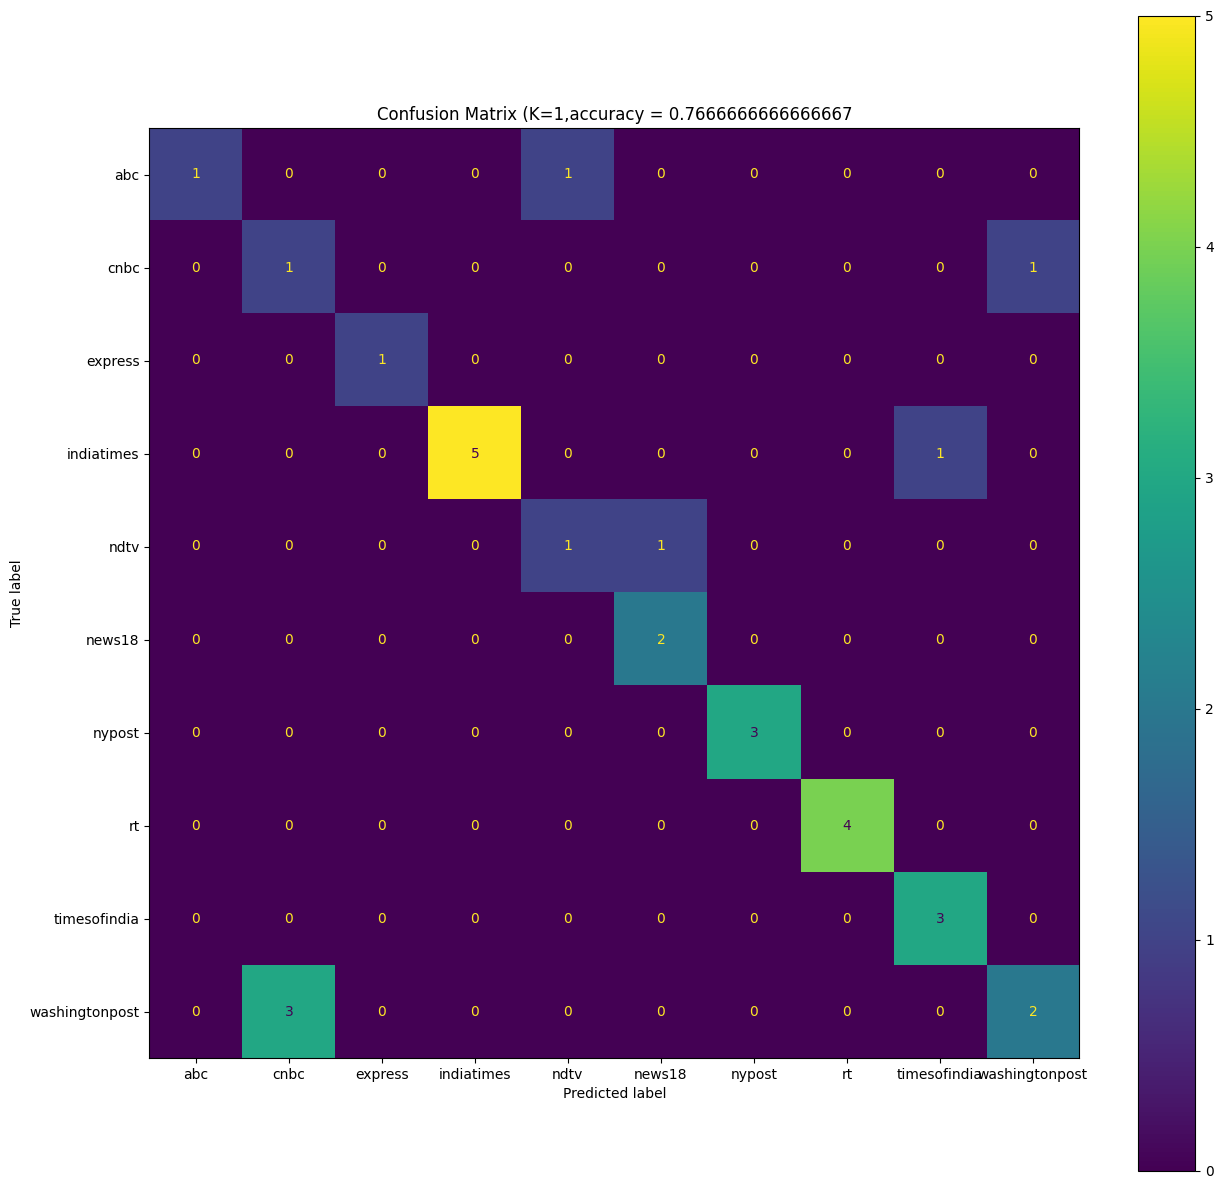

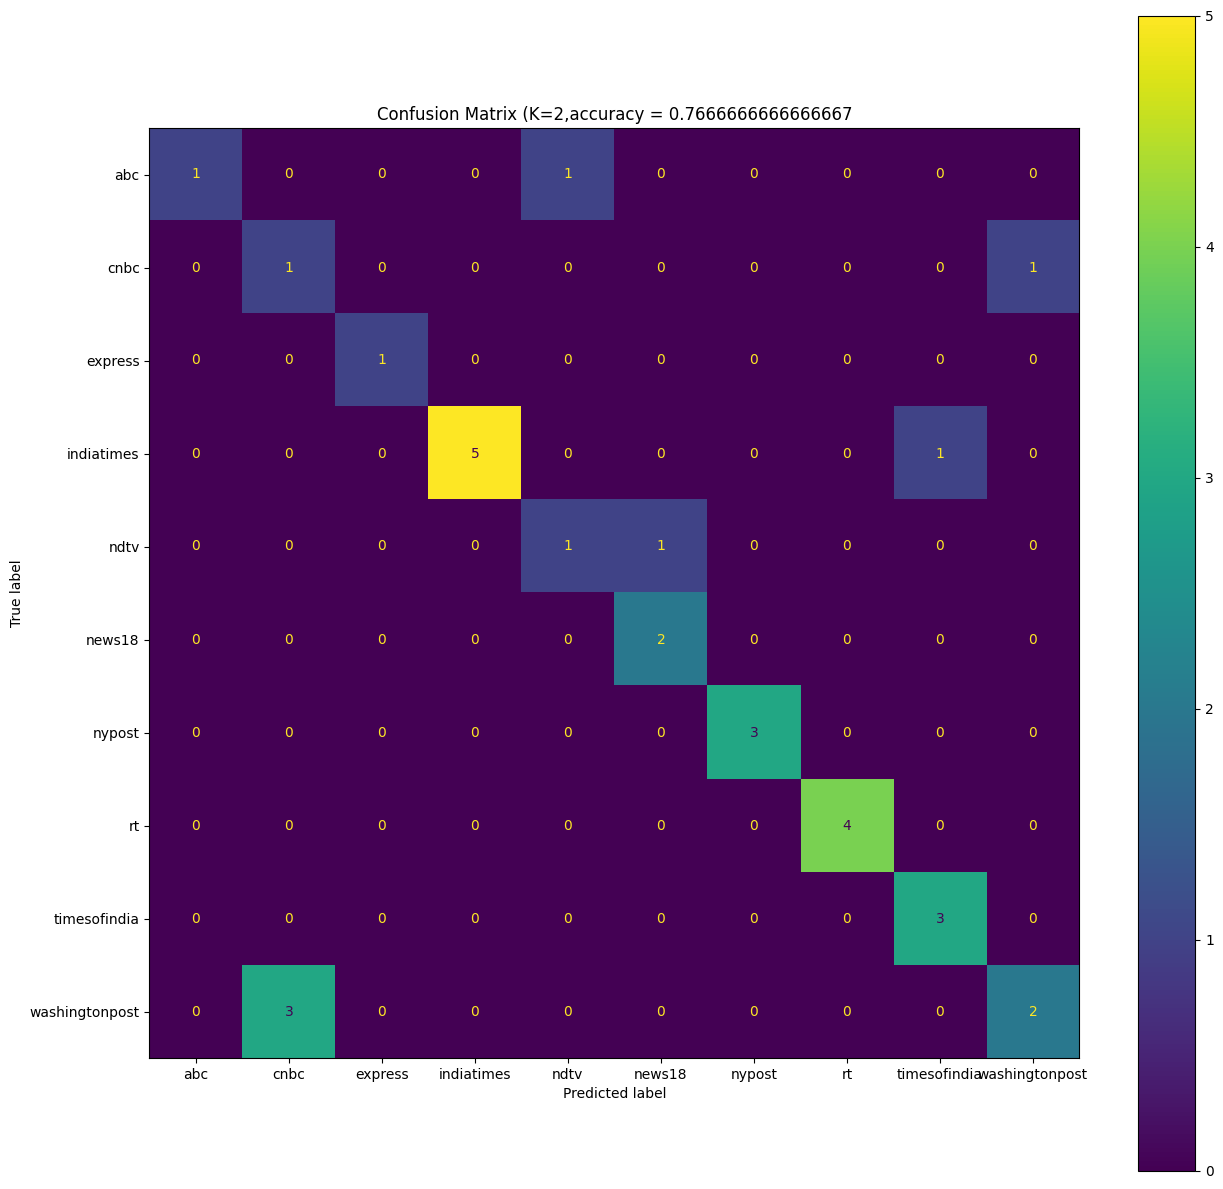

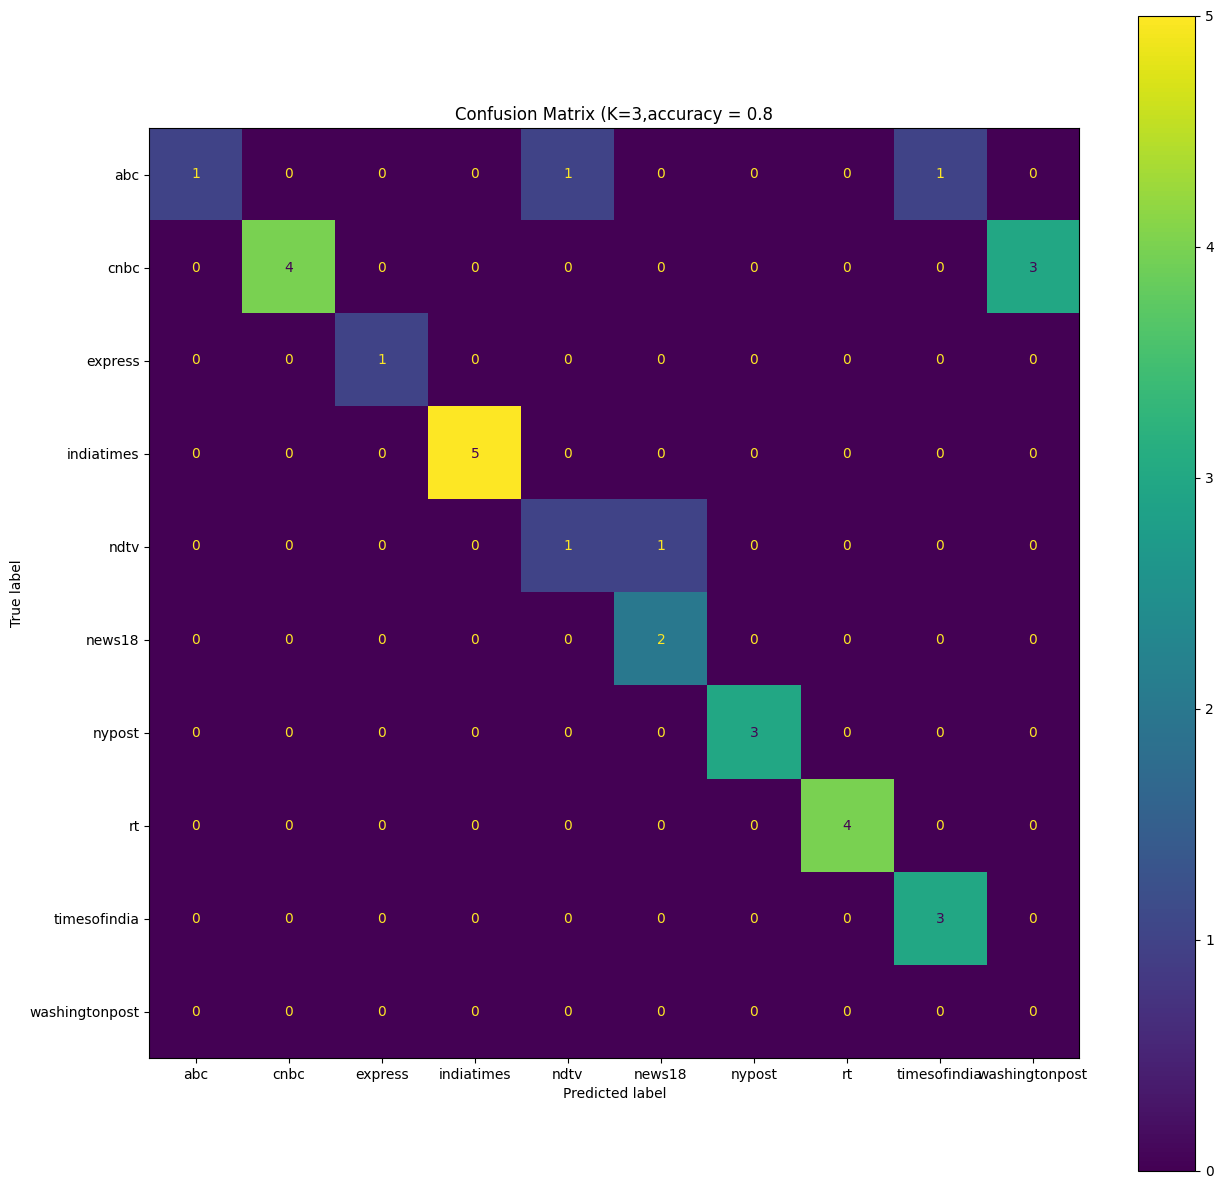

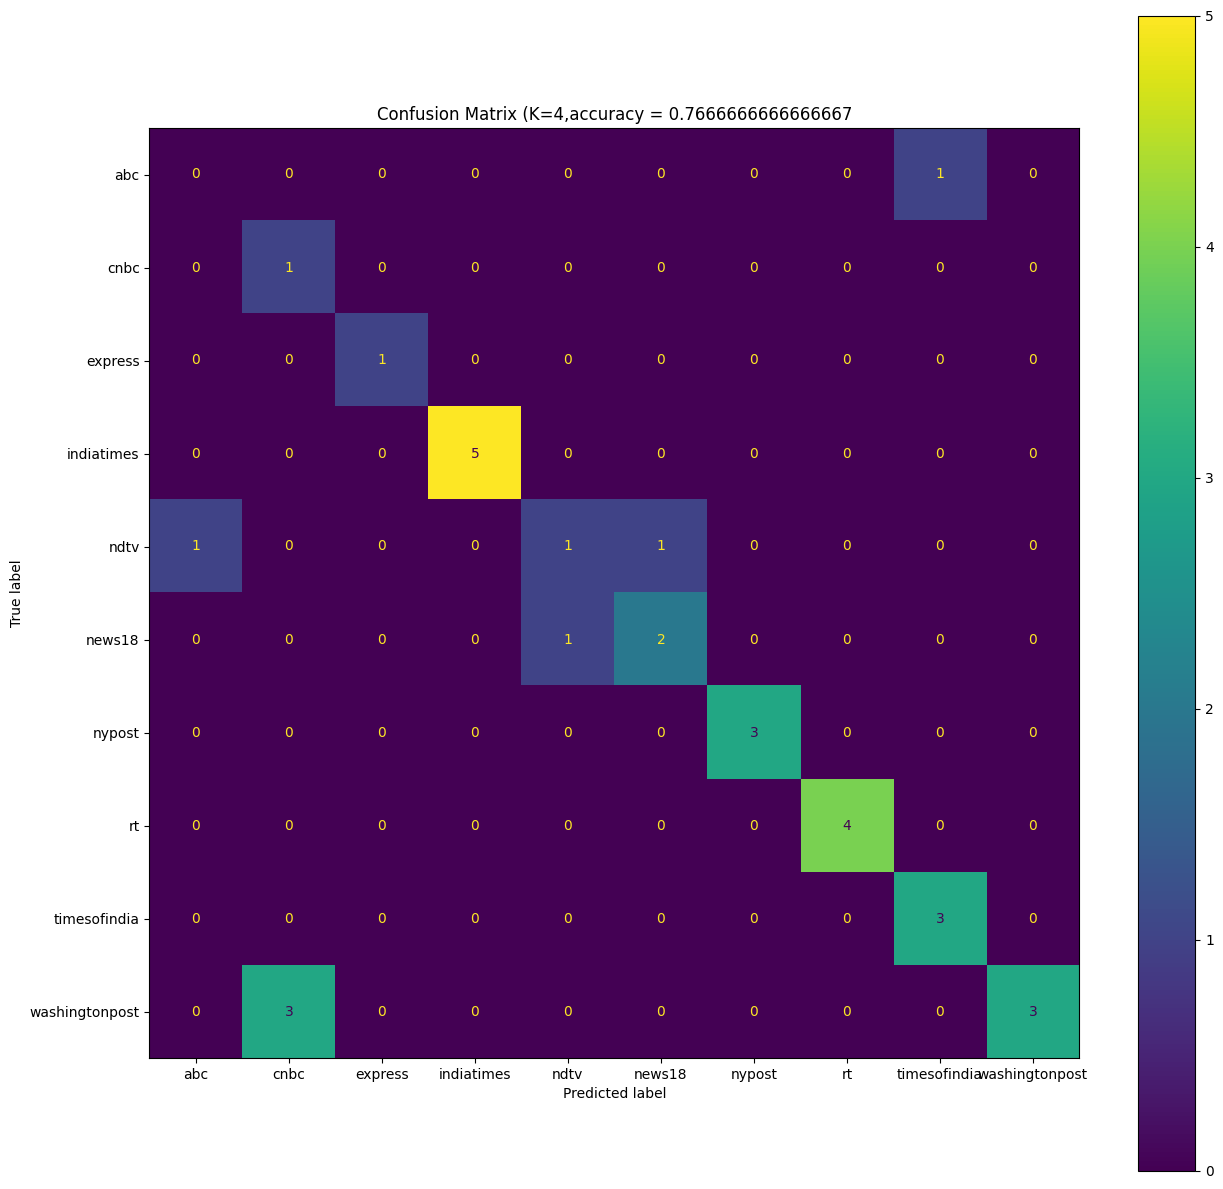

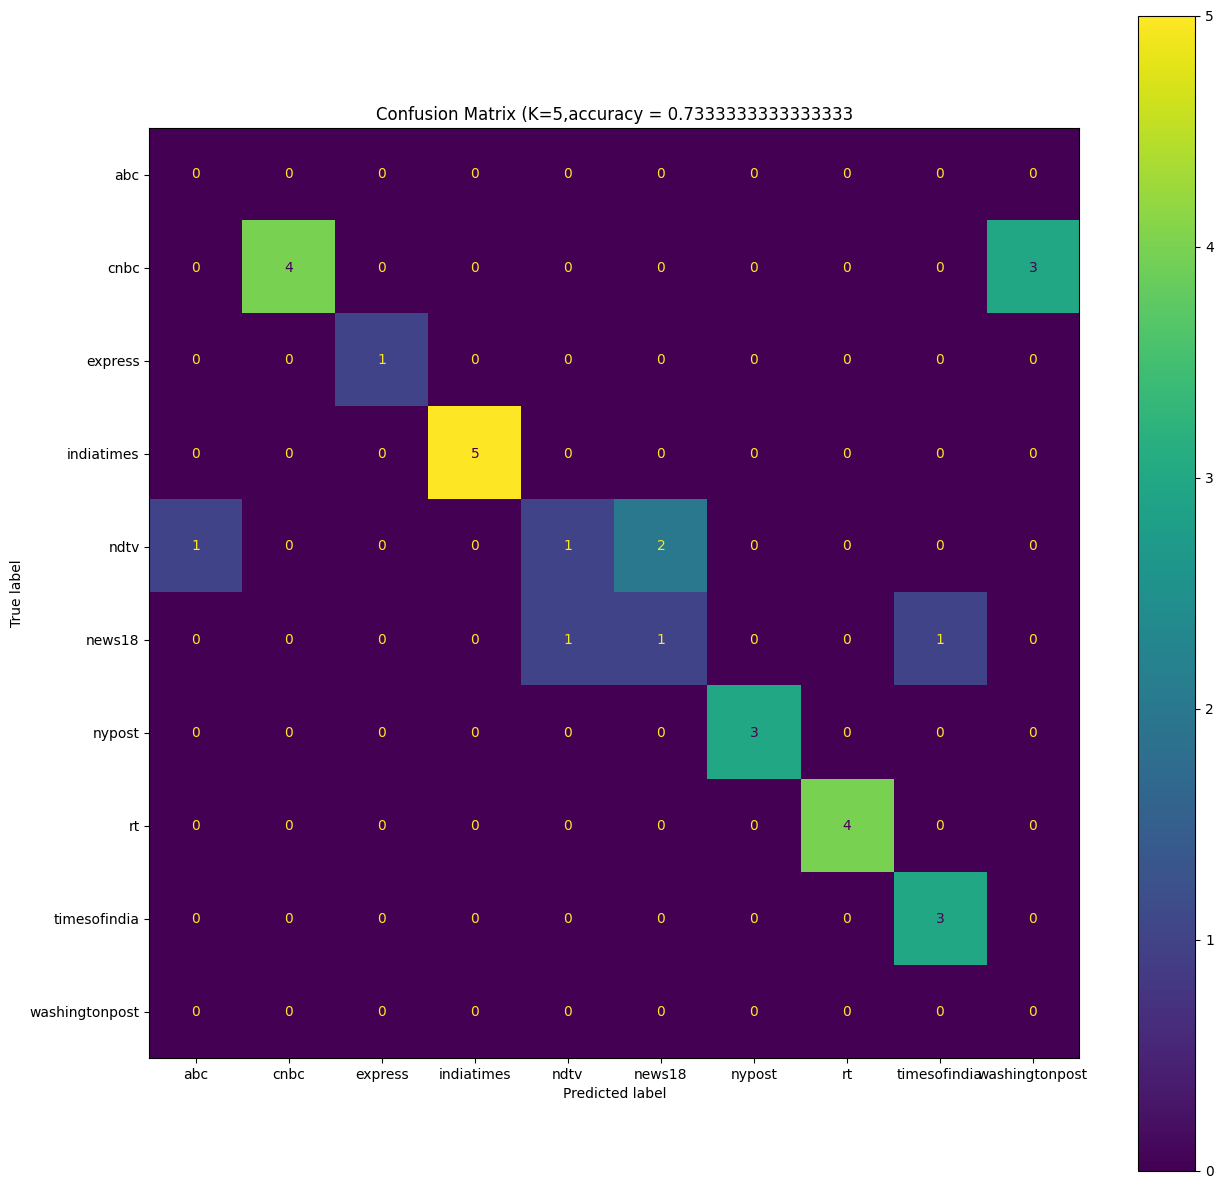

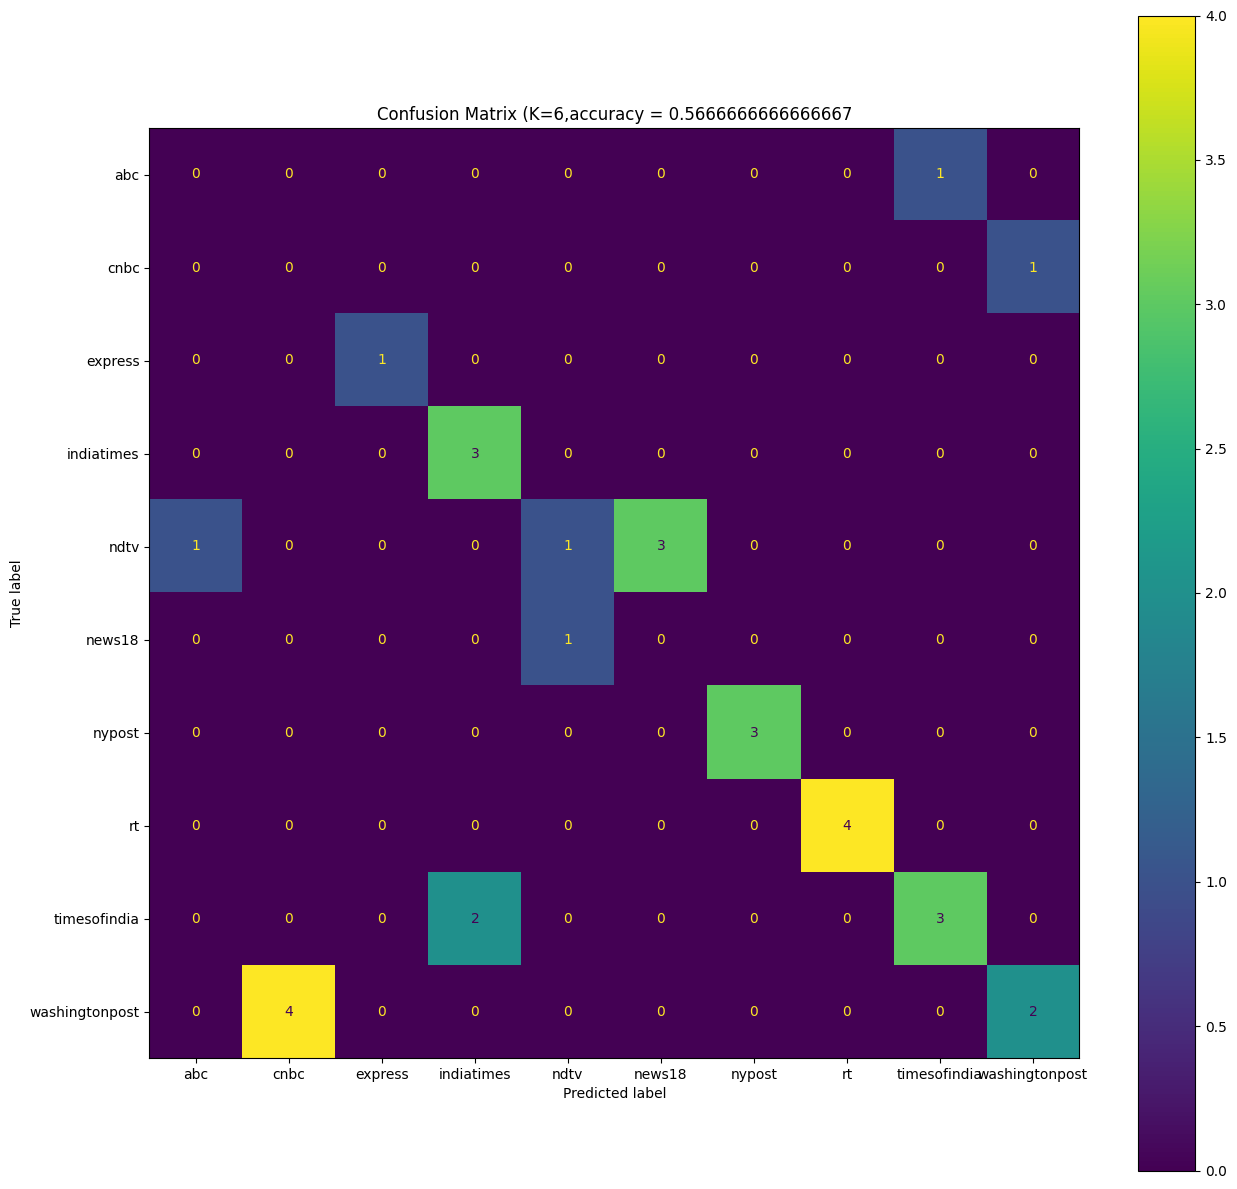

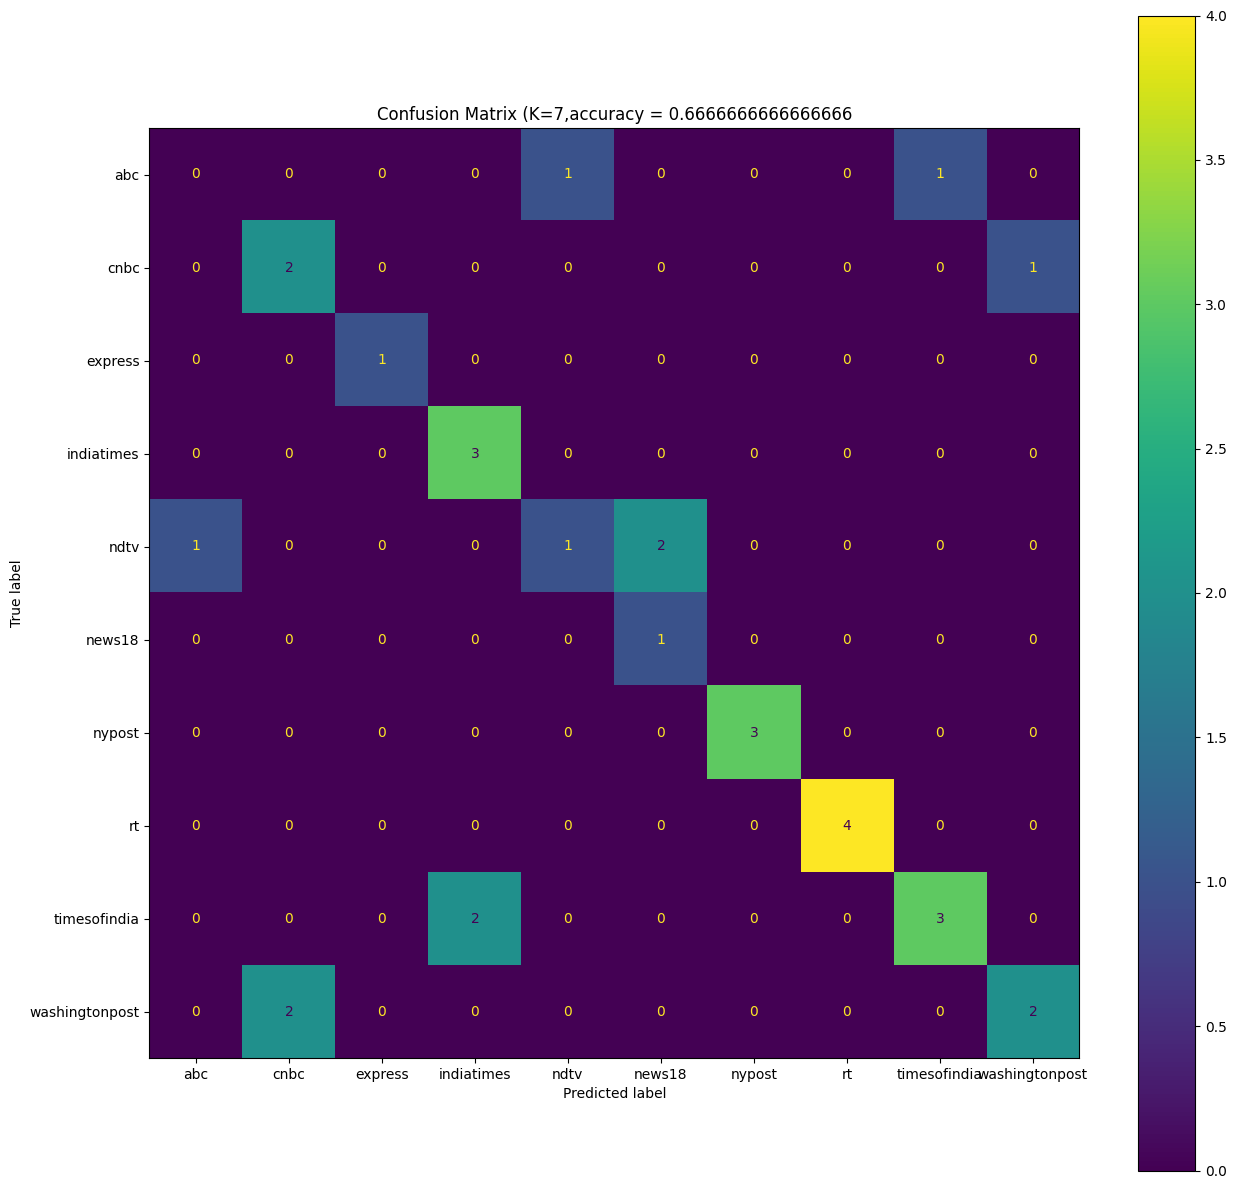

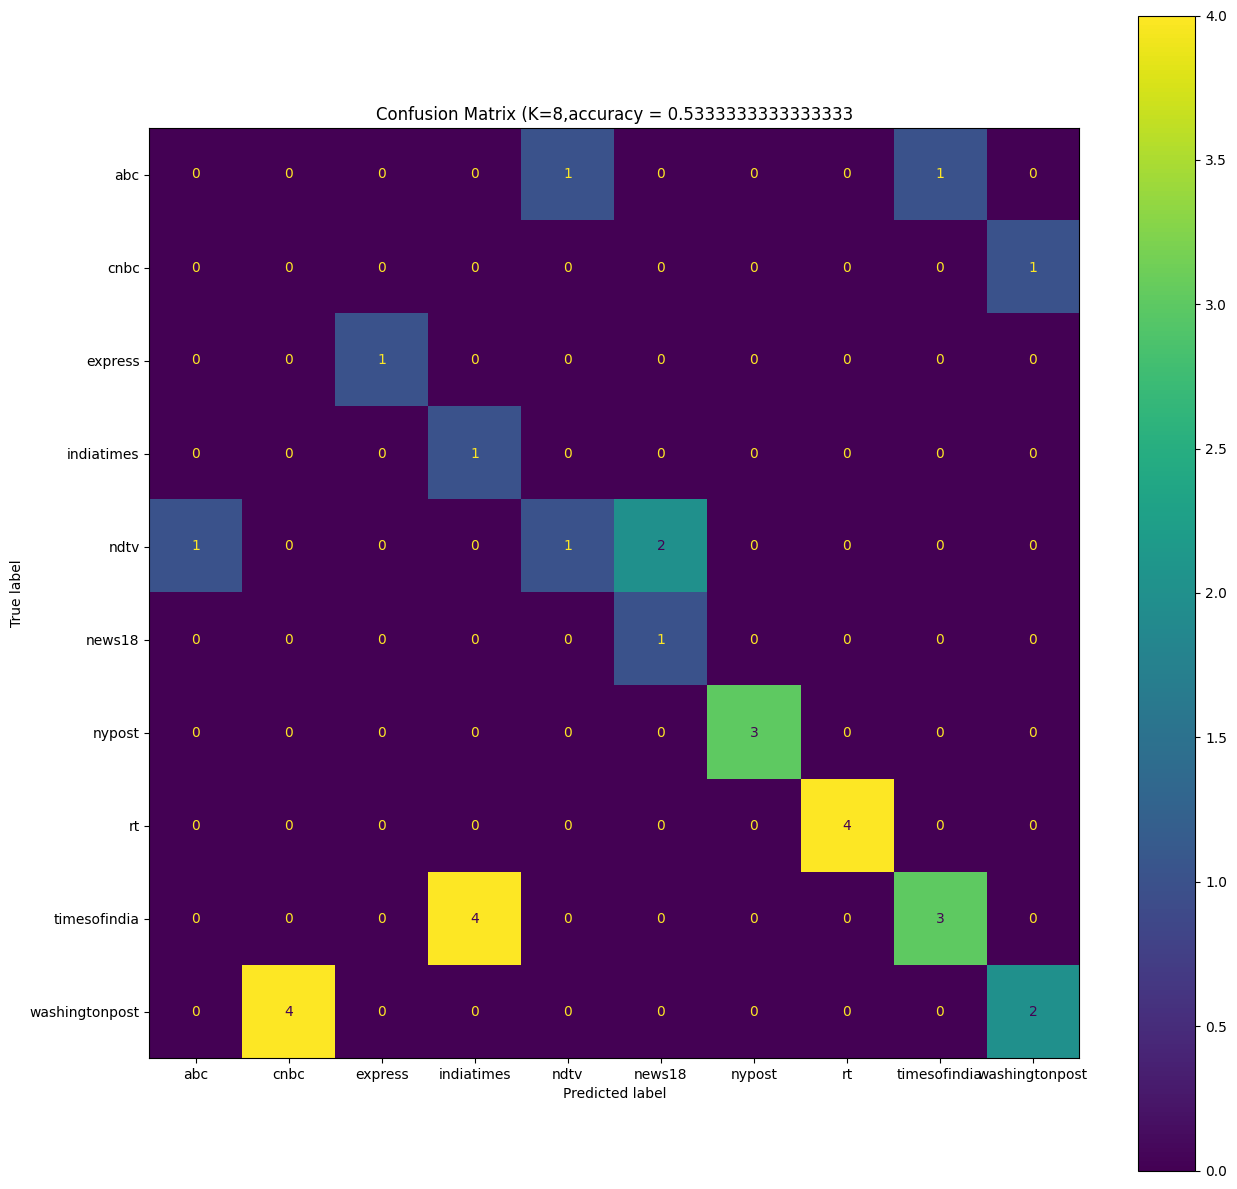

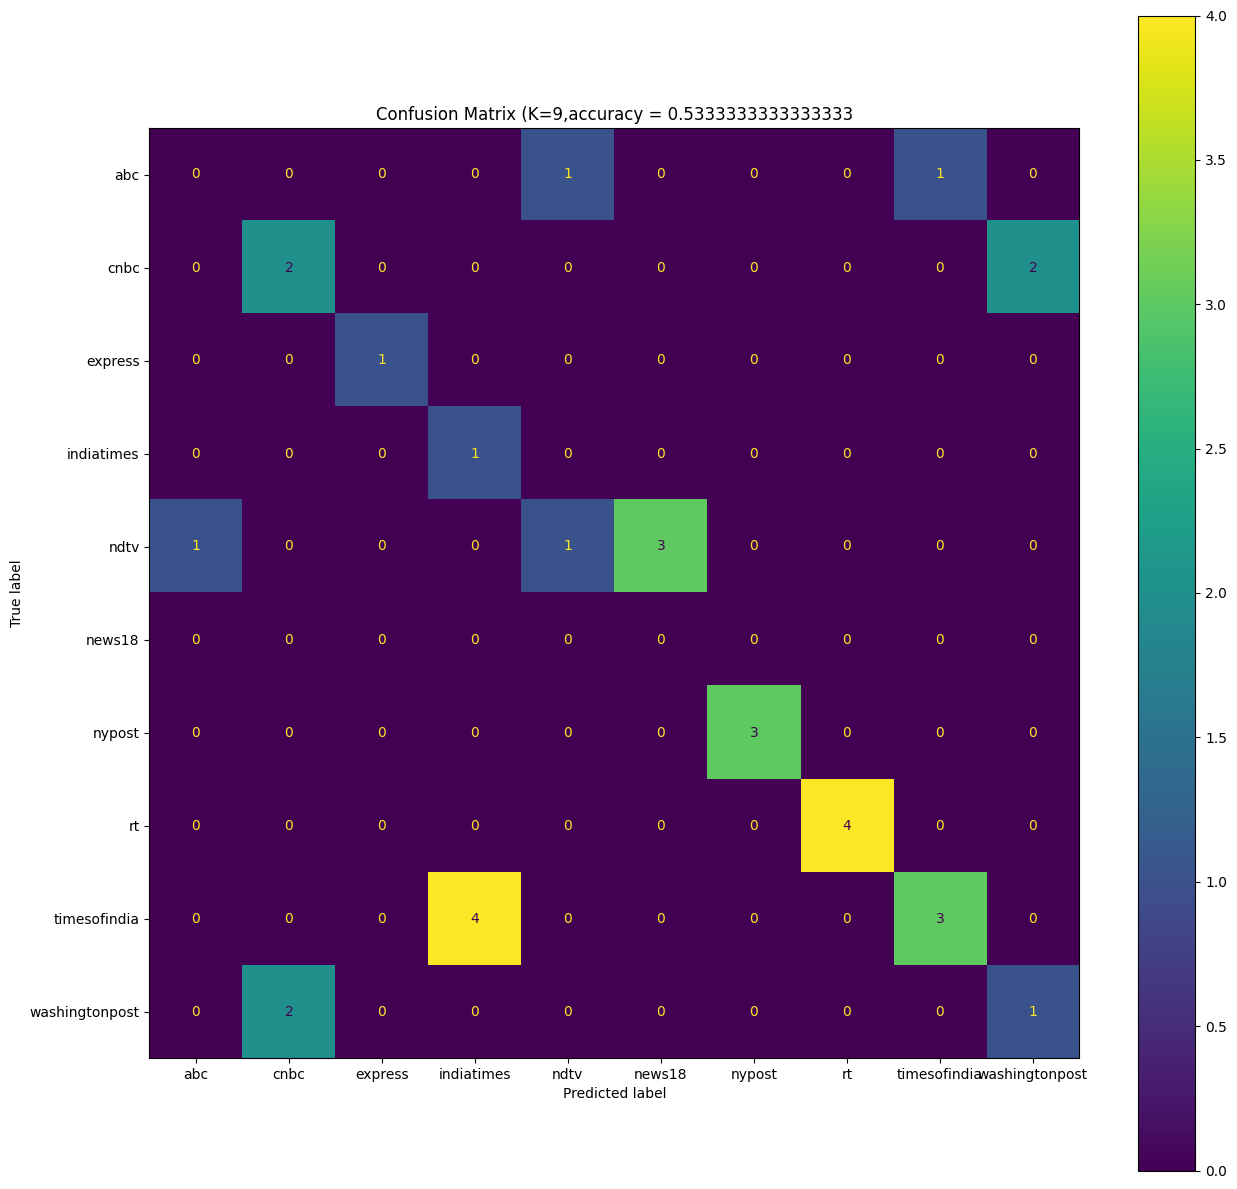

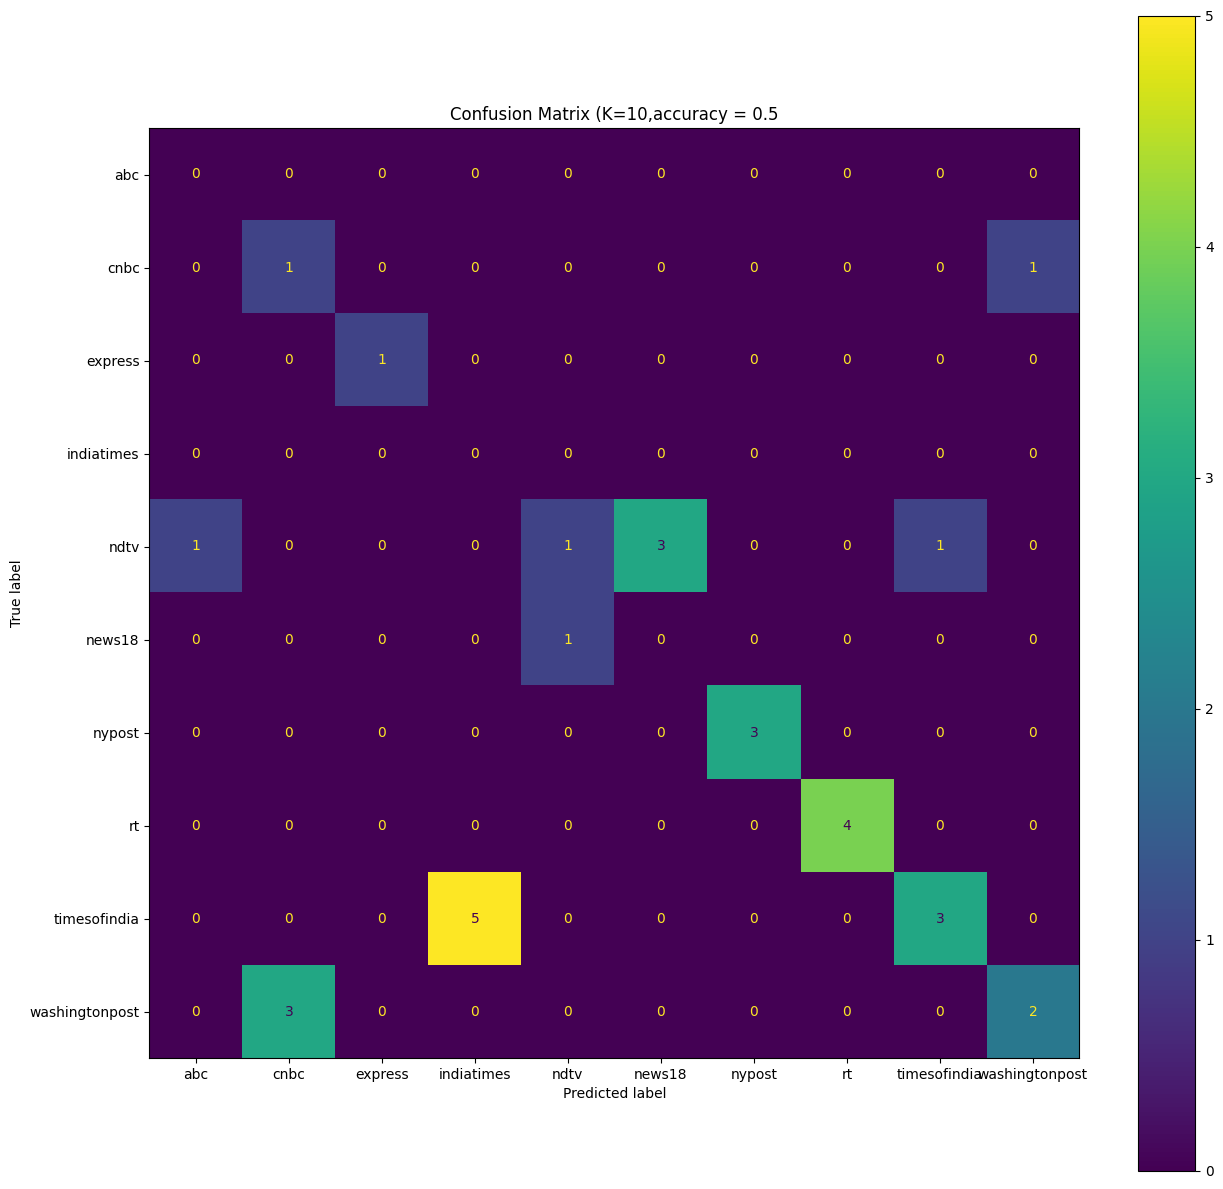

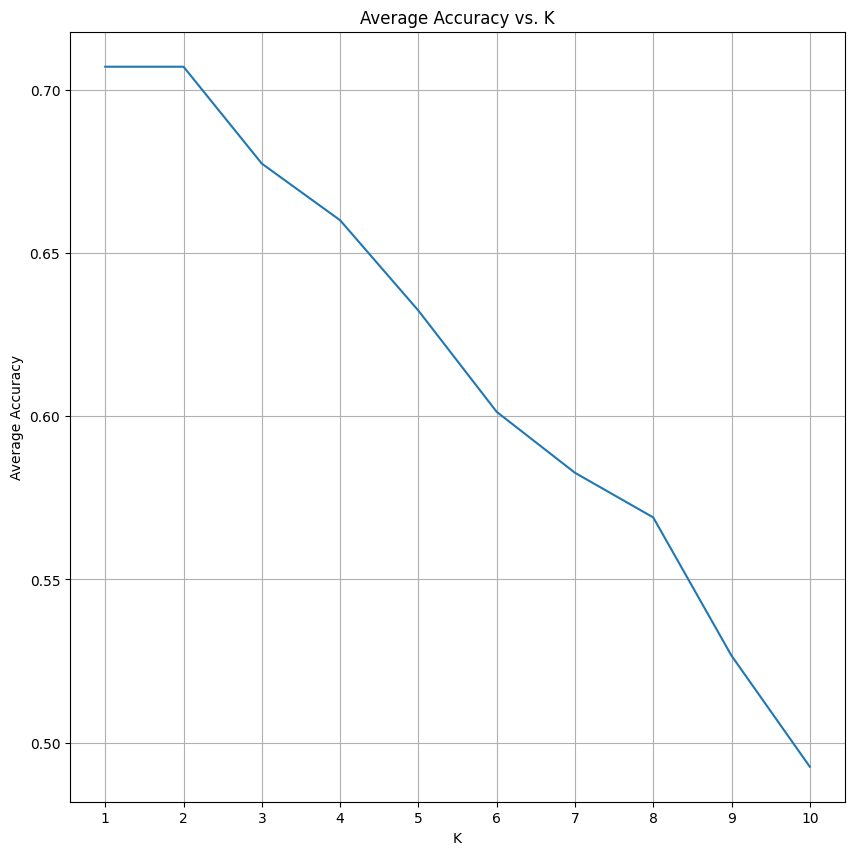

In [11]:
y_label = [0,0,0,0,0,0,0,0,0,0]
x_label = [1,2,3,4,5,6,7,8,9,10]
for i in range (0, 100):
  X = dataset.dropna()
  APP = X['app']
  X = X.drop(['app'], axis=1)

  # Take a random train and test dataset to be split

  idx = np.random.permutation(len(X))
  num_train_obs = np.floor(0.7 * len(X))

  train_idx = idx[1:int(num_train_obs)]
  test_idx = idx[int(num_train_obs):]

  # normalization Actually standardization
  X_norm = pd.DataFrame()
  for key in X:
      temp = X[key]
      temp_norm = (temp - temp.mean()) / temp.std()
      X_norm[key] = temp_norm

  # split train / test
  X_norm_train = X_norm.iloc[train_idx]
  X_norm_test = X_norm.iloc[test_idx]

  APP_train = APP.iloc[train_idx]
  APP_test = APP.iloc[test_idx]


  Y_label = K_NN(X_norm_test,X_norm_train,APP_test, APP_train, i)
  y_label = [a + b for a, b in zip(Y_label, y_label)]

y_label = y_label = [value * 0.01 for value in y_label]
plt.figure(figsize=(10, 10))
plt.plot(x_label, y_label)
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.title("Average Accuracy vs. K")
plt.xlabel("K")
plt.ylabel("Average Accuracy")
print(f"The accuracy of KNN is {y_label}")

In [157]:
# capture new packet one day later
if not os.path.exists('/content/drive/MyDrive/Pcap_test'):
        os.makedirs('/content/drive/MyDrive/Pcap_test')
pcap_path = '/content/drive/MyDrive/Pcap_test/'

# access each website and cpture data packet
for n in range(1, 4):
    for url in websites:  # capture 3 packets
        capture_save_pcap(url, n, pcap_path)



Capture done for www.indiatimes.com, file size: 8192 bytes, on attempt 1 for 1 times
Capture done for www.washingtonpost.com, file size: 2293760 bytes, on attempt 1 for 1 times
Capture done for www.ndtv.com, file size: 425984 bytes, on attempt 1 for 1 times
Capture done for www.cnbc.com, file size: 2097152 bytes, on attempt 1 for 1 times
Capture done for www.timesofindia.com, file size: 8192 bytes, on attempt 1 for 1 times
Capture done for www.express.co.uk, file size: 458752 bytes, on attempt 1 for 1 times
Capture done for www.rt.com, file size: 401408 bytes, on attempt 1 for 1 times
Capture done for www.news18.com, file size: 696320 bytes, on attempt 1 for 1 times
Empty pcap file captured for www.nypost.com, retrying 1th time
Capture done for www.nypost.com, file size: 8192 bytes, on attempt 2 for 1 times
Capture done for www.abc.net.au, file size: 245760 bytes, on attempt 1 for 1 times
Capture done for www.indiatimes.com, file size: 8192 bytes, on attempt 1 for 2 times
Capture done 

In [151]:
!rm -rf /content/drive/MyDrive/Csv_test

In [8]:
import os
# Directory paths
pcap_dir = '/content/drive/MyDrive/Pcap_test'
csv_dir = '/content/drive/MyDrive/Csv_test'
os.makedirs(csv_dir, exist_ok=True)

# Iterate over files in the pcap directory and convert pcap to csv
for file_name in os.listdir(pcap_dir):
    file_path = os.path.join(pcap_dir, file_name)
    if os.path.isfile(file_path):
        pcaptocsv(file_path)


In [12]:
dataset_list_test = []
pcap_dir = '/content/drive/MyDrive/Pcap_test'
csv_dir = '/content/drive/MyDrive/Csv_test'
for csv_name in os.listdir(csv_dir):
  print("Processing the file:", csv_dir +'/'+ csv_name)
  df = pd.read_csv(csv_dir +'/'+ csv_name)
  df_tcp = df[df["ip.proto"]==6]
  flow_features = extract_features(df_tcp, csv_name)
  display(flow_features)
  dataset_list_test.append(pd.DataFrame([flow_features]))


dataset_test = pd.DataFrame()
dataset_test = pd.concat(dataset_list_test, ignore_index=True)

display(dataset_test)

Processing the file: /content/drive/MyDrive/Csv_test/www.indiatimes.com_1_pyshark.csv
0    2024-03-22 22:34:23.972746
2    2024-03-22 22:34:23.984261
3    2024-03-22 22:34:23.989029
6    2024-03-22 22:34:24.000240
8    2024-03-22 22:34:24.000247
10   2024-03-22 22:34:24.002113
11   2024-03-22 22:34:24.006156
13   2024-03-22 22:34:24.021231
14   2024-03-22 22:34:24.021270
15   2024-03-22 22:34:24.021287
16   2024-03-22 22:34:24.021378
17   2024-03-22 22:34:24.048155
23   2024-03-22 22:34:24.054157
24   2024-03-22 22:34:24.054714
25   2024-03-22 22:34:24.054778
30   2024-03-22 22:34:24.065610
32   2024-03-22 22:34:24.065620
33   2024-03-22 22:35:54.360340
35   2024-03-22 22:35:54.371337
36   2024-03-22 22:35:54.373328
39   2024-03-22 22:35:54.384568
41   2024-03-22 22:35:54.384574
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 22,
 'num_down_link': 20,
 'total_bytes_up_link': 2658.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 120.81818181818181,
 'std_pkt_size_up_link': 149.10451315824025,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 90.29472,
 'mean_iat_up_link': 4.305325142857143,
 'std_iat_up_link': 19.70264676839332,
 'total_bytes_down_link': 11646.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 582.3,
 'std_pkt_size_down_link': 924.4727145784237,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 90.305702,
 'mean_iat_down_link': 4.757911947368421,
 'std_iat_down_link': 20.71634462850673,
 'app': 'indiatimes'}

Processing the file: /content/drive/MyDrive/Csv_test/www.ndtv.com_1_pyshark.csv
0     2024-03-22 22:34:48.303632
2     2024-03-22 22:34:48.314999
3     2024-03-22 22:34:48.316704
6     2024-03-22 22:34:48.328525
8     2024-03-22 22:34:48.328536
                 ...            
276   2024-03-22 22:36:16.777002
278   2024-03-22 22:36:16.778092
280   2024-03-22 22:36:16.778123
281   2024-03-22 22:36:16.779759
282   2024-03-22 22:36:16.779823
Name: frame.time, Length: 143, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 143,
 'num_down_link': 141,
 'total_bytes_up_link': 9114.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.73426573426573,
 'std_pkt_size_up_link': 62.241233451262204,
 'min_iat_up_link': 7e-06,
 'max_iat_up_link': 88.173232,
 'mean_iat_up_link': 0.6230717676056339,
 'std_iat_up_link': 7.399156440313881,
 'total_bytes_down_link': 842501.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18876.0,
 'mean_pkt_size_down_link': 5975.184397163121,
 'std_pkt_size_down_link': 4756.309342941732,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 88.184701,
 'mean_iat_down_link': 0.6319728214285714,
 'std_iat_down_link': 7.452792634215451,
 'app': 'ndtv'}

Processing the file: /content/drive/MyDrive/Csv_test/www.washingtonpost.com_1_pyshark.csv
0     2024-03-22 22:34:31.112333
2     2024-03-22 22:34:31.123234
3     2024-03-22 22:34:31.125878
6     2024-03-22 22:34:31.137937
8     2024-03-22 22:34:31.137941
                 ...            
856   2024-03-22 22:37:32.233482
858   2024-03-22 22:37:32.233689
861   2024-03-22 22:37:32.233976
863   2024-03-22 22:37:32.234169
865   2024-03-22 22:37:32.234237
Name: frame.time, Length: 424, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 424,
 'num_down_link': 442,
 'total_bytes_up_link': 24679.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.20518867924528,
 'std_pkt_size_up_link': 44.603139660528484,
 'min_iat_up_link': 4e-06,
 'max_iat_up_link': 80.175225,
 'mean_iat_up_link': 0.428184170212766,
 'std_iat_up_link': 5.302459556015935,
 'total_bytes_down_link': 6793031.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15368.848416289593,
 'std_pkt_size_down_link': 17130.664708319186,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 80.186213,
 'mean_iat_down_link': 0.4106823922902494,
 'std_iat_down_link': 5.1936497852318855,
 'app': 'washingtonpost'}

Processing the file: /content/drive/MyDrive/Csv_test/www.cnbc.com_1_pyshark.csv
0     2024-03-22 22:34:55.505230
2     2024-03-22 22:34:55.516287
3     2024-03-22 22:34:55.518105
6     2024-03-22 22:34:55.530435
8     2024-03-22 22:34:55.530440
                 ...            
763   2024-03-22 22:37:46.723037
765   2024-03-22 22:37:46.725033
768   2024-03-22 22:37:46.725070
770   2024-03-22 22:37:46.725109
773   2024-03-22 22:37:46.725301
Name: frame.time, Length: 386, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 386,
 'num_down_link': 388,
 'total_bytes_up_link': 22550.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.41968911917098,
 'std_pkt_size_up_link': 46.65396269030421,
 'min_iat_up_link': 4e-06,
 'max_iat_up_link': 88.215727,
 'mean_iat_up_link': 0.4447274571428572,
 'std_iat_up_link': 6.15033391586768,
 'total_bytes_down_link': 6236883.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 16074.440721649484,
 'std_pkt_size_down_link': 17050.118997185396,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 88.226948,
 'mean_iat_down_link': 0.44240056072351425,
 'std_iat_down_link': 6.135259563575918,
 'app': 'cnbc'}

Processing the file: /content/drive/MyDrive/Csv_test/www.timesofindia.com_1_pyshark.csv
0    2024-03-22 22:35:02.643066
2    2024-03-22 22:35:02.672952
3    2024-03-22 22:35:02.674970
6    2024-03-22 22:35:02.944252
8    2024-03-22 22:35:02.944258
10   2024-03-22 22:35:02.952425
12   2024-03-22 22:35:02.973985
13   2024-03-22 22:35:02.974440
14   2024-03-22 22:35:02.974529
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 9,
 'num_down_link': 8,
 'total_bytes_up_link': 1179.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 131.0,
 'std_pkt_size_up_link': 169.1227364963091,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 0.269282,
 'mean_iat_up_link': 0.041432875,
 'std_iat_up_link': 0.09274259636902482,
 'total_bytes_down_link': 6129.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 766.125,
 'std_pkt_size_down_link': 1060.3037890152048,
 'min_iat_down_link': 2e-06,
 'max_iat_down_link': 0.239595,
 'mean_iat_down_link': 0.047320428571428576,
 'std_iat_down_link': 0.08580970707881704,
 'app': 'timesofindia'}

Processing the file: /content/drive/MyDrive/Csv_test/www.express.co.uk_1_pyshark.csv
0     2024-03-22 22:35:10.035506
2     2024-03-22 22:35:10.047265
3     2024-03-22 22:35:10.049174
6     2024-03-22 22:35:10.061246
8     2024-03-22 22:35:10.062459
                 ...            
354   2024-03-22 22:38:00.939988
356   2024-03-22 22:38:00.940042
358   2024-03-22 22:38:00.940836
360   2024-03-22 22:38:00.941409
362   2024-03-22 22:38:00.942270
Name: frame.time, Length: 188, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 188,
 'num_down_link': 175,
 'total_bytes_up_link': 12266.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 65.24468085106383,
 'std_pkt_size_up_link': 66.01396484413775,
 'min_iat_up_link': 4e-06,
 'max_iat_up_link': 87.776148,
 'mean_iat_up_link': 0.9139399144385028,
 'std_iat_up_link': 8.784966397187056,
 'total_bytes_down_link': 1323563.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 22900.0,
 'mean_pkt_size_down_link': 7563.217142857143,
 'std_pkt_size_down_link': 5391.375830285122,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 87.787597,
 'mean_iat_down_link': 0.9821553563218391,
 'std_iat_down_link': 9.106595067701754,
 'app': 'express'}

Processing the file: /content/drive/MyDrive/Csv_test/www.rt.com_1_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-22 22:35:17.493385
2     2024-03-22 22:35:17.601996
3     2024-03-22 22:35:17.604083
6     2024-03-22 22:35:17.713562
8     2024-03-22 22:35:17.713568
                 ...            
888   2024-03-22 22:38:08.864565
890   2024-03-22 22:38:08.865819
892   2024-03-22 22:38:08.866897
894   2024-03-22 22:38:08.868061
896   2024-03-22 22:38:08.869275
Name: frame.time, Length: 452, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 452,
 'num_down_link': 445,
 'total_bytes_up_link': 25931.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.36946902654867,
 'std_pkt_size_up_link': 42.99216910782114,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 86.863432,
 'mean_iat_up_link': 0.3799908869179601,
 'std_iat_up_link': 5.607156350343754,
 'total_bytes_down_link': 1165674.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2828.0,
 'mean_pkt_size_down_link': 2619.4921348314606,
 'std_pkt_size_down_link': 654.5186375478236,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 86.972131,
 'mean_iat_down_link': 0.3857371801801802,
 'std_iat_down_link': 5.658411383077363,
 'app': 'rt'}

Processing the file: /content/drive/MyDrive/Csv_test/www.news18.com_1_pyshark.csv
0     2024-03-22 22:35:25.416974
2     2024-03-22 22:35:25.428623
3     2024-03-22 22:35:25.430405
6     2024-03-22 22:35:25.442346
8     2024-03-22 22:35:25.442352
                 ...            
159   2024-03-22 22:35:25.869872
161   2024-03-22 22:35:25.870730
163   2024-03-22 22:35:25.879100
166   2024-03-22 22:35:25.879499
168   2024-03-22 22:35:25.880466
Name: frame.time, Length: 83, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 83,
 'num_down_link': 86,
 'total_bytes_up_link': 5144.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.975903614457835,
 'std_pkt_size_up_link': 58.02017645352274,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 0.073115,
 'mean_iat_up_link': 0.005652341463414635,
 'std_iat_up_link': 0.014985062897102283,
 'total_bytes_down_link': 679273.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 20324.0,
 'mean_pkt_size_down_link': 7898.523255813953,
 'std_pkt_size_down_link': 6981.875099101444,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.073112,
 'mean_iat_down_link': 0.005316035294117646,
 'std_iat_down_link': 0.015057096289700445,
 'app': 'news18'}

Processing the file: /content/drive/MyDrive/Csv_test/www.nypost.com_1_pyshark.csv
0    2024-03-22 22:35:40.014756
2    2024-03-22 22:35:40.039402
3    2024-03-22 22:35:40.041348
6    2024-03-22 22:35:40.066723
8    2024-03-22 22:35:40.066731
10   2024-03-22 22:35:40.066738
11   2024-03-22 22:35:40.068991
12   2024-03-22 22:35:40.069126
13   2024-03-22 22:35:40.069178
14   2024-03-22 22:35:40.069200
15   2024-03-22 22:35:40.069245
20   2024-03-22 22:35:40.093714
22   2024-03-22 22:35:40.094572
23   2024-03-22 22:35:40.094621
26   2024-03-22 22:35:40.118978
27   2024-03-22 22:37:00.519107
29   2024-03-22 22:37:00.544466
30   2024-03-22 22:37:00.546580
33   2024-03-22 22:37:00.572406
35   2024-03-22 22:37:00.572413
37   2024-03-22 22:37:00.572418
38   2024-03-22 22:37:00.573963
39   2024-03-22 22:37:00.574087
40   2024-03-22 22:37:00.574117
41   2024-03-22 22:37:00.574153
42   2024-03-22 22:37:00.574185
49   2024-03-22 22:37:00.599004
51   2024-03-22 22:37:00.599970
52   2024-03-22 22:37:

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 48,
 'num_down_link': 38,
 'total_bytes_up_link': 4532.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 94.41666666666667,
 'std_pkt_size_up_link': 123.2450997400265,
 'min_iat_up_link': 5e-06,
 'max_iat_up_link': 82.787494,
 'mean_iat_up_link': 3.62822325531915,
 'std_iat_up_link': 16.64739102590177,
 'total_bytes_down_link': 17438.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 458.89473684210526,
 'std_pkt_size_down_link': 810.1584692990353,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.812798,
 'mean_iat_down_link': 4.60815718918919,
 'std_iat_down_link': 18.70075409876909,
 'app': 'nypost'}

Processing the file: /content/drive/MyDrive/Csv_test/www.abc.net.au_1_pyshark.csv
0     2024-03-22 22:35:47.123545
2     2024-03-22 22:35:47.148892
3     2024-03-22 22:35:47.151408
6     2024-03-22 22:35:47.178912
8     2024-03-22 22:35:47.178921
                 ...            
161   2024-03-22 22:35:47.335772
163   2024-03-22 22:35:47.336567
164   2024-03-22 22:35:47.336905
165   2024-03-22 22:35:47.336971
166   2024-03-22 22:35:47.394159
Name: frame.time, Length: 85, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 85,
 'num_down_link': 84,
 'total_bytes_up_link': 5272.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 62.023529411764706,
 'std_pkt_size_up_link': 57.35602606082639,
 'min_iat_up_link': 9e-06,
 'max_iat_up_link': 0.057188,
 'mean_iat_up_link': 0.0032215952380952382,
 'std_iat_up_link': 0.008717953132596306,
 'total_bytes_down_link': 235388.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 5844.0,
 'mean_pkt_size_down_link': 2802.2380952380954,
 'std_pkt_size_down_link': 1336.5478785978,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.06572,
 'mean_iat_down_link': 0.003234433734939759,
 'std_iat_down_link': 0.009268371266383918,
 'app': 'abc'}

Processing the file: /content/drive/MyDrive/Csv_test/www.indiatimes.com_2_pyshark.csv
0    2024-03-22 22:35:54.360340
2    2024-03-22 22:35:54.371337
3    2024-03-22 22:35:54.373328
6    2024-03-22 22:35:54.384568
8    2024-03-22 22:35:54.384574
10   2024-03-22 22:35:54.391823
11   2024-03-22 22:35:54.393081
13   2024-03-22 22:35:54.417428
14   2024-03-22 22:35:54.417462
15   2024-03-22 22:35:54.417476
16   2024-03-22 22:35:54.417509
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 11,
 'num_down_link': 8,
 'total_bytes_up_link': 1445.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 131.36363636363637,
 'std_pkt_size_up_link': 150.56378895821715,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 0.024347,
 'mean_iat_up_link': 0.0057169,
 'std_iat_up_link': 0.007967403626304145,
 'total_bytes_down_link': 5982.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 747.75,
 'std_pkt_size_down_link': 1053.240543682754,
 'min_iat_down_link': 2e-06,
 'max_iat_down_link': 0.025369,
 'mean_iat_down_link': 0.010499,
 'std_iat_down_link': 0.010609635636219245,
 'app': 'indiatimes'}

Processing the file: /content/drive/MyDrive/Csv_test/www.washingtonpost.com_2_pyshark.csv
0     2024-03-22 22:36:01.466940
2     2024-03-22 22:36:01.477925
3     2024-03-22 22:36:01.479675
6     2024-03-22 22:36:01.491673
8     2024-03-22 22:36:01.491679
                 ...            
554   2024-03-22 22:37:32.233482
556   2024-03-22 22:37:32.233689
559   2024-03-22 22:37:32.233976
561   2024-03-22 22:37:32.234169
563   2024-03-22 22:37:32.234237
Name: frame.time, Length: 275, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 275,
 'num_down_link': 289,
 'total_bytes_up_link': 16098.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.53818181818182,
 'std_pkt_size_up_link': 45.22023758443888,
 'min_iat_up_link': 5e-06,
 'max_iat_up_link': 72.45379,
 'mean_iat_up_link': 0.33126750729927,
 'std_iat_up_link': 4.440742473266589,
 'total_bytes_down_link': 4514010.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15619.411764705883,
 'std_pkt_size_down_link': 17108.375381909682,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 72.464479,
 'mean_iat_down_link': 0.3151258402777778,
 'std_iat_down_link': 4.331540092677352,
 'app': 'washingtonpost'}

Processing the file: /content/drive/MyDrive/Csv_test/www.ndtv.com_2_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-22 22:36:16.654347
2     2024-03-22 22:36:16.665850
3     2024-03-22 22:36:16.667634
6     2024-03-22 22:36:16.680301
8     2024-03-22 22:36:16.680308
                 ...            
129   2024-03-22 22:36:16.776109
131   2024-03-22 22:36:16.776163
133   2024-03-22 22:36:16.776967
135   2024-03-22 22:36:16.777002
137   2024-03-22 22:36:16.778092
Name: frame.time, Length: 69, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 69,
 'num_down_link': 69,
 'total_bytes_up_link': 4415.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 63.98550724637681,
 'std_pkt_size_up_link': 63.508334967944805,
 'min_iat_up_link': 7e-06,
 'max_iat_up_link': 0.031358,
 'mean_iat_up_link': 0.0018197794117647058,
 'std_iat_up_link': 0.004410765635116879,
 'total_bytes_down_link': 411531.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 17428.0,
 'mean_pkt_size_down_link': 5964.217391304348,
 'std_pkt_size_down_link': 4496.089411495693,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.031275,
 'mean_iat_down_link': 0.001651044117647059,
 'std_iat_down_link': 0.004311674396623913,
 'app': 'ndtv'}

Processing the file: /content/drive/MyDrive/Csv_test/www.timesofindia.com_2_pyshark.csv
0    2024-03-22 22:36:31.003695
2    2024-03-22 22:36:31.015008
3    2024-03-22 22:36:31.016917
6    2024-03-22 22:36:31.200317
8    2024-03-22 22:36:31.200323
10   2024-03-22 22:36:31.200871
12   2024-03-22 22:36:31.212795
13   2024-03-22 22:36:31.213034
14   2024-03-22 22:36:31.213104
19   2024-03-22 22:36:31.227706
21   2024-03-22 22:36:31.234596
22   2024-03-22 22:36:31.234805
24   2024-03-22 22:36:31.251895
26   2024-03-22 22:36:31.251905
27   2024-03-22 22:37:53.777491
29   2024-03-22 22:37:53.788483
30   2024-03-22 22:37:53.790912
33   2024-03-22 22:37:53.802569
35   2024-03-22 22:37:53.802583
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 19,
 'num_down_link': 17,
 'total_bytes_up_link': 2224.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 117.05263157894737,
 'std_pkt_size_up_link': 162.070106121535,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 82.525586,
 'mean_iat_up_link': 4.599938222222221,
 'std_iat_up_link': 19.447723744195724,
 'total_bytes_down_link': 11895.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 699.7058823529412,
 'std_pkt_size_down_link': 973.5295812599817,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.536581,
 'mean_iat_down_link': 5.1742234375,
 'std_iat_down_link': 20.630005014676478,
 'app': 'timesofindia'}

Processing the file: /content/drive/MyDrive/Csv_test/www.cnbc.com_2_pyshark.csv
0     2024-03-22 22:36:23.849845
2     2024-03-22 22:36:23.861102
3     2024-03-22 22:36:23.862880
6     2024-03-22 22:36:23.875077
8     2024-03-22 22:36:23.875085
                 ...            
516   2024-03-22 22:37:46.723037
518   2024-03-22 22:37:46.725033
521   2024-03-22 22:37:46.725070
523   2024-03-22 22:37:46.725109
526   2024-03-22 22:37:46.725301
Name: frame.time, Length: 263, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 263,
 'num_down_link': 264,
 'total_bytes_up_link': 15328.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.28136882129277,
 'std_pkt_size_up_link': 46.17421286819127,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 82.580544,
 'mean_iat_up_link': 0.31631853435114504,
 'std_iat_up_link': 5.10177388446903,
 'total_bytes_down_link': 4151423.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15725.087121212122,
 'std_pkt_size_down_link': 16117.548159710706,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.591344,
 'mean_iat_down_link': 0.3150730076045628,
 'std_iat_down_link': 5.092736918405903,
 'app': 'cnbc'}

Processing the file: /content/drive/MyDrive/Csv_test/www.express.co.uk_2_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-22 22:36:38.256929
2     2024-03-22 22:36:38.268389
3     2024-03-22 22:36:38.270008
6     2024-03-22 22:36:38.281624
8     2024-03-22 22:36:38.282637
                 ...            
217   2024-03-22 22:38:00.939988
219   2024-03-22 22:38:00.940042
221   2024-03-22 22:38:00.940836
223   2024-03-22 22:38:00.941409
225   2024-03-22 22:38:00.942270
Name: frame.time, Length: 118, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 118,
 'num_down_link': 108,
 'total_bytes_up_link': 7788.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 66.0,
 'std_pkt_size_up_link': 68.05879810869422,
 'min_iat_up_link': 8e-06,
 'max_iat_up_link': 82.499416,
 'mean_iat_up_link': 0.7067123162393164,
 'std_iat_up_link': 7.62692605205436,
 'total_bytes_down_link': 872658.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 22900.0,
 'mean_pkt_size_down_link': 8080.166666666667,
 'std_pkt_size_down_link': 5313.4731438549015,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.510877,
 'mean_iat_down_link': 0.7726531495327104,
 'std_iat_down_link': 7.976479390340168,
 'app': 'express'}

Processing the file: /content/drive/MyDrive/Csv_test/www.rt.com_2_pyshark.csv
0     2024-03-22 22:36:45.365804
2     2024-03-22 22:36:45.474501
3     2024-03-22 22:36:45.476398
6     2024-03-22 22:36:45.585853
8     2024-03-22 22:36:45.585861
                 ...            
585   2024-03-22 22:38:08.864565
587   2024-03-22 22:38:08.865819
589   2024-03-22 22:38:08.866897
591   2024-03-22 22:38:08.868061
593   2024-03-22 22:38:08.869275
Name: frame.time, Length: 298, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 298,
 'num_down_link': 296,
 'total_bytes_up_link': 17114.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.42953020134228,
 'std_pkt_size_up_link': 43.24174548558949,
 'min_iat_up_link': 8e-06,
 'max_iat_up_link': 81.656583,
 'mean_iat_up_link': 0.28115646801346805,
 'std_iat_up_link': 4.737865148718258,
 'total_bytes_down_link': 775230.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2828.0,
 'mean_pkt_size_down_link': 2619.0202702702704,
 'std_pkt_size_down_link': 655.6643257508368,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 81.765457,
 'mean_iat_down_link': 0.28269427457627105,
 'std_iat_down_link': 4.760271317339702,
 'app': 'rt'}

Processing the file: /content/drive/MyDrive/Csv_test/www.news18.com_2_pyshark.csv
0     2024-03-22 22:36:53.228411
2     2024-03-22 22:36:53.240328
3     2024-03-22 22:36:53.242146
6     2024-03-22 22:36:53.253803
8     2024-03-22 22:36:53.253918
                 ...            
354   2024-03-22 22:38:16.322687
356   2024-03-22 22:38:16.374217
359   2024-03-22 22:38:16.374497
361   2024-03-22 22:38:16.386989
364   2024-03-22 22:38:16.387375
Name: frame.time, Length: 178, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 178,
 'num_down_link': 187,
 'total_bytes_up_link': 10912.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.30337078651685,
 'std_pkt_size_up_link': 55.948807209105254,
 'min_iat_up_link': 5e-06,
 'max_iat_up_link': 82.390329,
 'mean_iat_up_link': 0.4698246553672316,
 'std_iat_up_link': 6.1925312879291425,
 'total_bytes_down_link': 1375004.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 33356.0,
 'mean_pkt_size_down_link': 7352.96256684492,
 'std_pkt_size_down_link': 7044.664480947894,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.402225,
 'mean_iat_down_link': 0.4470273010752688,
 'std_iat_down_link': 6.041745396831136,
 'app': 'news18'}

Processing the file: /content/drive/MyDrive/Csv_test/www.abc.net.au_2_pyshark.csv
0     2024-03-22 22:37:07.628719
2     2024-03-22 22:37:07.639995
3     2024-03-22 22:37:07.642685
6     2024-03-22 22:37:07.654220
8     2024-03-22 22:37:07.654228
10    2024-03-22 22:37:07.654234
11    2024-03-22 22:37:07.655539
12    2024-03-22 22:37:07.655637
13    2024-03-22 22:37:07.655664
14    2024-03-22 22:37:07.655676
15    2024-03-22 22:37:07.655705
20    2024-03-22 22:37:07.666725
26    2024-03-22 22:37:07.852509
28    2024-03-22 22:37:07.853220
30    2024-03-22 22:37:07.853891
32    2024-03-22 22:37:07.853919
34    2024-03-22 22:37:07.854713
36    2024-03-22 22:37:07.855569
38    2024-03-22 22:37:07.863212
40    2024-03-22 22:37:07.863571
42    2024-03-22 22:37:07.864458
44    2024-03-22 22:37:07.865312
46    2024-03-22 22:37:07.866328
48    2024-03-22 22:37:07.866992
50    2024-03-22 22:37:07.867732
52    2024-03-22 22:37:07.868679
54    2024-03-22 22:37:07.869598
56    2024-03-22 22:37:07.8

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 51,
 'num_down_link': 52,
 'total_bytes_up_link': 3480.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 68.23529411764706,
 'std_pkt_size_up_link': 73.60124679250863,
 'min_iat_up_link': 6e-06,
 'max_iat_up_link': 0.185784,
 'mean_iat_up_link': 0.0051962,
 'std_iat_up_link': 0.02620266311282274,
 'total_bytes_down_link': 224323.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 14532.0,
 'mean_pkt_size_down_link': 4313.903846153846,
 'std_pkt_size_down_link': 2887.8146989845436,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 0.174683,
 'mean_iat_down_link': 0.0048738627450980385,
 'std_iat_down_link': 0.024429452082287563,
 'app': 'abc'}

Processing the file: /content/drive/MyDrive/Csv_test/www.nypost.com_2_pyshark.csv
0    2024-03-22 22:37:00.519107
2    2024-03-22 22:37:00.544466
3    2024-03-22 22:37:00.546580
6    2024-03-22 22:37:00.572406
8    2024-03-22 22:37:00.572413
10   2024-03-22 22:37:00.572418
11   2024-03-22 22:37:00.573963
12   2024-03-22 22:37:00.574087
13   2024-03-22 22:37:00.574117
14   2024-03-22 22:37:00.574153
15   2024-03-22 22:37:00.574185
22   2024-03-22 22:37:00.599004
24   2024-03-22 22:37:00.599970
25   2024-03-22 22:37:00.600027
28   2024-03-22 22:37:00.624740
29   2024-03-22 22:38:23.412234
31   2024-03-22 22:38:23.437560
32   2024-03-22 22:38:23.439397
35   2024-03-22 22:38:23.465296
37   2024-03-22 22:38:23.465306
39   2024-03-22 22:38:23.465313
40   2024-03-22 22:38:23.466854
41   2024-03-22 22:38:23.466958
42   2024-03-22 22:38:23.466984
43   2024-03-22 22:38:23.467001
44   2024-03-22 22:38:23.467030
49   2024-03-22 22:38:23.492120
50   2024-03-22 22:38:23.492182
51   2024-03-22 22:38:

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 32,
 'num_down_link': 25,
 'total_bytes_up_link': 3028.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 94.625,
 'std_pkt_size_up_link': 123.82864070183649,
 'min_iat_up_link': 5e-06,
 'max_iat_up_link': 82.787494,
 'mean_iat_up_link': 2.9031419354838706,
 'std_iat_up_link': 14.878942659334752,
 'total_bytes_down_link': 11597.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 463.88,
 'std_pkt_size_down_link': 820.1524919184236,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 82.812798,
 'mean_iat_down_link': 3.457202333333333,
 'std_iat_down_link': 16.90267496285285,
 'app': 'nypost'}

Processing the file: /content/drive/MyDrive/Csv_test/www.indiatimes.com_3_pyshark.csv
0    2024-03-22 22:37:14.912627
2    2024-03-22 22:37:14.944719
3    2024-03-22 22:37:14.946484
6    2024-03-22 22:37:14.978913
8    2024-03-22 22:37:14.978922
10   2024-03-22 22:37:14.980733
11   2024-03-22 22:37:14.982054
13   2024-03-22 22:37:15.020168
14   2024-03-22 22:37:15.020213
15   2024-03-22 22:37:15.020230
16   2024-03-22 22:37:15.020260
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 11,
 'num_down_link': 9,
 'total_bytes_up_link': 1445.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 131.36363636363637,
 'std_pkt_size_up_link': 150.56378895821715,
 'min_iat_up_link': 9e-06,
 'max_iat_up_link': 0.038114,
 'mean_iat_up_link': 0.010763300000000002,
 'std_iat_up_link': 0.0162749654858825,
 'total_bytes_down_link': 6072.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 674.6666666666666,
 'std_pkt_size_down_link': 1009.3174674006193,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.049397,
 'mean_iat_down_link': 0.016154125,
 'std_iat_down_link': 0.020868127614259022,
 'app': 'indiatimes'}

Processing the file: /content/drive/MyDrive/Csv_test/www.washingtonpost.com_3_pyshark.csv
0     2024-03-22 22:37:22.098513
2     2024-03-22 22:37:22.109377
3     2024-03-22 22:37:22.111257
6     2024-03-22 22:37:22.123577
8     2024-03-22 22:37:22.123587
                 ...            
279   2024-03-22 22:37:32.233482
281   2024-03-22 22:37:32.233689
284   2024-03-22 22:37:32.233976
286   2024-03-22 22:37:32.234169
288   2024-03-22 22:37:32.234237
Name: frame.time, Length: 145, dtype: datetime64[ns]

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 145,
 'num_down_link': 144,
 'total_bytes_up_link': 8433.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.15862068965517,
 'std_pkt_size_up_link': 44.108873487162576,
 'min_iat_up_link': 9e-06,
 'max_iat_up_link': 10.007091,
 'mean_iat_up_link': 0.0703869722222222,
 'std_iat_up_link': 0.8338516931492514,
 'total_bytes_down_link': 2235398.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15523.597222222223,
 'std_pkt_size_down_link': 17292.392787759192,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 9.954918,
 'mean_iat_down_link': 0.07080300000000002,
 'std_iat_down_link': 0.8323852273155047,
 'app': 'washingtonpost'}

Processing the file: /content/drive/MyDrive/Csv_test/www.ndtv.com_3_pyshark.csv
0     2024-03-22 22:37:39.260213
2     2024-03-22 22:37:39.271155
3     2024-03-22 22:37:39.272829
6     2024-03-22 22:37:39.285117
8     2024-03-22 22:37:39.285125
                 ...            
127   2024-03-22 22:37:39.427322
129   2024-03-22 22:37:39.428304
131   2024-03-22 22:37:39.428457
133   2024-03-22 22:37:39.429386
135   2024-03-22 22:37:39.430151
Name: frame.time, Length: 68, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 68,
 'num_down_link': 68,
 'total_bytes_up_link': 4363.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 64.16176470588235,
 'std_pkt_size_up_link': 63.96351812221303,
 'min_iat_up_link': 8e-06,
 'max_iat_up_link': 0.075012,
 'mean_iat_up_link': 0.002536388059701492,
 'std_iat_up_link': 0.00941465870566202,
 'total_bytes_down_link': 414214.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 18876.0,
 'mean_pkt_size_down_link': 6091.382352941177,
 'std_pkt_size_down_link': 4987.998815154474,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.051602,
 'mean_iat_down_link': 0.002373164179104478,
 'std_iat_down_link': 0.0071868067499074725,
 'app': 'ndtv'}

Processing the file: /content/drive/MyDrive/Csv_test/www.timesofindia.com_3_pyshark.csv
0    2024-03-22 22:37:53.777491
2    2024-03-22 22:37:53.788483
3    2024-03-22 22:37:53.790912
6    2024-03-22 22:37:53.802569
8    2024-03-22 22:37:53.802583
10   2024-03-22 22:37:53.802796
12   2024-03-22 22:37:53.813445
13   2024-03-22 22:37:53.813830
14   2024-03-22 22:37:53.813947
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 9,
 'num_down_link': 7,
 'total_bytes_up_link': 1179.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 131.0,
 'std_pkt_size_up_link': 169.1227364963091,
 'min_iat_up_link': 1.4e-05,
 'max_iat_up_link': 0.011657,
 'mean_iat_up_link': 0.004557,
 'std_iat_up_link': 0.005478378826936722,
 'total_bytes_down_link': 6365.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2948.0,
 'mean_pkt_size_down_link': 909.2857142857143,
 'std_pkt_size_down_link': 1071.4184856668153,
 'min_iat_down_link': 2e-06,
 'max_iat_down_link': 0.013222,
 'mean_iat_down_link': 0.006057,
 'std_iat_down_link': 0.006291778476710698,
 'app': 'timesofindia'}

Processing the file: /content/drive/MyDrive/Csv_test/www.cnbc.com_3_pyshark.csv


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


0     2024-03-22 22:37:46.579180
2     2024-03-22 22:37:46.590053
3     2024-03-22 22:37:46.591951
6     2024-03-22 22:37:46.603880
8     2024-03-22 22:37:46.603889
                 ...            
247   2024-03-22 22:37:46.723037
249   2024-03-22 22:37:46.725033
252   2024-03-22 22:37:46.725070
254   2024-03-22 22:37:46.725109
257   2024-03-22 22:37:46.725301
Name: frame.time, Length: 128, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 128,
 'num_down_link': 130,
 'total_bytes_up_link': 7482.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 58.453125,
 'std_pkt_size_up_link': 46.84752606935501,
 'min_iat_up_link': 9e-06,
 'max_iat_up_link': 0.017741,
 'mean_iat_up_link': 0.0011505590551181102,
 'std_iat_up_link': 0.0026173862300089322,
 'total_bytes_down_link': 2065440.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 56524.0,
 'mean_pkt_size_down_link': 15888.0,
 'std_pkt_size_down_link': 16155.682639086586,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.018543,
 'mean_iat_down_link': 0.0010487441860465119,
 'std_iat_down_link': 0.0025260431300723005,
 'app': 'cnbc'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: /content/drive/MyDrive/Csv_test/www.express.co.uk_3_pyshark.csv
0     2024-03-22 22:38:00.853919
2     2024-03-22 22:38:00.865405
3     2024-03-22 22:38:00.867181
6     2024-03-22 22:38:00.878668
8     2024-03-22 22:38:00.878788
10    2024-03-22 22:38:00.879799
11    2024-03-22 22:38:00.881250
12    2024-03-22 22:38:00.881333
13    2024-03-22 22:38:00.881357
14    2024-03-22 22:38:00.881371
15    2024-03-22 22:38:00.881399
19    2024-03-22 22:38:00.894582
20    2024-03-22 22:38:00.894611
22    2024-03-22 22:38:00.901797
24    2024-03-22 22:38:00.902058
26    2024-03-22 22:38:00.902941
28    2024-03-22 22:38:00.903858
30    2024-03-22 22:38:00.904834
32    2024-03-22 22:38:00.905929
34    2024-03-22 22:38:00.906163
36    2024-03-22 22:38:00.913179
38    2024-03-22 22:38:00.913582
40    2024-03-22 22:38:00.914513
42    2024-03-22 22:38:00.915573
44    2024-03-22 22:38:00.916540
46    2024-03-22 22:38:00.917441
48    2024-03-22 22:38:00.918428
50    2024-03-22 22:38:0

<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 56,
 'num_down_link': 51,
 'total_bytes_up_link': 3726.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 66.53571428571429,
 'std_pkt_size_up_link': 70.11885086589231,
 'min_iat_up_link': 1.4e-05,
 'max_iat_up_link': 0.013183,
 'mean_iat_up_link': 0.0016063818181818183,
 'std_iat_up_link': 0.0028804696600773744,
 'total_bytes_down_link': 423245.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 22900.0,
 'mean_pkt_size_down_link': 8298.921568627451,
 'std_pkt_size_down_link': 5411.225520501385,
 'min_iat_down_link': 2.7e-05,
 'max_iat_down_link': 0.014676,
 'mean_iat_down_link': 0.00153784,
 'std_iat_down_link': 0.002909170646666945,
 'app': 'express'}

Processing the file: /content/drive/MyDrive/Csv_test/www.news18.com_3_pyshark.csv
0     2024-03-22 22:38:15.897287
2     2024-03-22 22:38:15.909209
3     2024-03-22 22:38:15.911496
6     2024-03-22 22:38:15.923333
8     2024-03-22 22:38:15.923345
                 ...            
189   2024-03-22 22:38:16.386989
192   2024-03-22 22:38:16.387375
194   2024-03-22 22:38:16.388201
195   2024-03-22 22:38:16.388473
196   2024-03-22 22:38:16.388532
Name: frame.time, Length: 93, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 93,
 'num_down_link': 105,
 'total_bytes_up_link': 5688.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.16129032258065,
 'std_pkt_size_up_link': 54.87838140965035,
 'min_iat_up_link': 1.2e-05,
 'max_iat_up_link': 0.173741,
 'mean_iat_up_link': 0.0053396195652173906,
 'std_iat_up_link': 0.01984030539901557,
 'total_bytes_down_link': 692841.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 20324.0,
 'mean_pkt_size_down_link': 6598.4857142857145,
 'std_pkt_size_down_link': 6028.483948202587,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.121743,
 'mean_iat_down_link': 0.004717557692307693,
 'std_iat_down_link': 0.015096000398631229,
 'app': 'news18'}

Processing the file: /content/drive/MyDrive/Csv_test/www.rt.com_3_pyshark.csv
0     2024-03-22 22:38:07.970176
2     2024-03-22 22:38:08.079055
3     2024-03-22 22:38:08.080943
6     2024-03-22 22:38:08.189843
8     2024-03-22 22:38:08.189855
                 ...            
280   2024-03-22 22:38:08.863419
282   2024-03-22 22:38:08.864565
284   2024-03-22 22:38:08.865819
286   2024-03-22 22:38:08.866897
288   2024-03-22 22:38:08.868061
Name: frame.time, Length: 146, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 146,
 'num_down_link': 143,
 'total_bytes_up_link': 8401.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 57.54109589041096,
 'std_pkt_size_up_link': 43.719344209412455,
 'min_iat_up_link': 1.2e-05,
 'max_iat_up_link': 0.1089,
 'mean_iat_up_link': 0.006192310344827586,
 'std_iat_up_link': 0.016918564935579083,
 'total_bytes_down_link': 381803.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 2828.0,
 'mean_pkt_size_down_link': 2669.951048951049,
 'std_pkt_size_down_link': 575.9387355998767,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.109977,
 'mean_iat_down_link': 0.00555674647887324,
 'std_iat_down_link': 0.015160058516811325,
 'app': 'rt'}

Processing the file: /content/drive/MyDrive/Csv_test/www.nypost.com_3_pyshark.csv
0    2024-03-22 22:38:23.412234
2    2024-03-22 22:38:23.437560
3    2024-03-22 22:38:23.439397
6    2024-03-22 22:38:23.465296
8    2024-03-22 22:38:23.465306
10   2024-03-22 22:38:23.465313
11   2024-03-22 22:38:23.466854
12   2024-03-22 22:38:23.466958
13   2024-03-22 22:38:23.466984
14   2024-03-22 22:38:23.467001
15   2024-03-22 22:38:23.467030
20   2024-03-22 22:38:23.492120
21   2024-03-22 22:38:23.492182
22   2024-03-22 22:38:23.492456
23   2024-03-22 22:38:23.492508
26   2024-03-22 22:38:23.517293
27   2024-03-22 22:38:30.516507
Name: frame.time, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')
<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 17,
 'num_down_link': 11,
 'total_bytes_up_link': 1564.0,
 'min_pkt_size_up_link': 40.0,
 'max_pkt_size_up_link': 557.0,
 'mean_pkt_size_up_link': 92.0,
 'std_pkt_size_up_link': 122.38361818478812,
 'min_iat_up_link': 7e-06,
 'max_iat_up_link': 6.999214,
 'mean_iat_up_link': 0.4440170625,
 'std_iat_up_link': 1.7480873357584272,
 'total_bytes_down_link': 5728.0,
 'min_pkt_size_down_link': 40.0,
 'max_pkt_size_down_link': 2960.0,
 'mean_pkt_size_down_link': 520.7272727272727,
 'std_pkt_size_down_link': 881.8055444267846,
 'min_iat_down_link': 1e-06,
 'max_iat_down_link': 0.02675,
 'mean_iat_down_link': 0.007975300000000001,
 'std_iat_down_link': 0.012560689436580392,
 'app': 'nypost'}

<ipython-input-6-0fd15190dcbf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_link_flow['frame.time'] = pd.to_datetime(up_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


Processing the file: /content/drive/MyDrive/Csv_test/www.abc.net.au_3_pyshark.csv
0     2024-03-22 22:38:37.620159
2     2024-03-22 22:38:37.645448
3     2024-03-22 22:38:37.647330
6     2024-03-22 22:38:37.673285
8     2024-03-22 22:38:37.673297
                 ...            
172   2024-03-22 22:38:38.082671
174   2024-03-22 22:38:38.083585
176   2024-03-22 22:38:38.084588
178   2024-03-22 22:38:38.085667
180   2024-03-22 22:38:38.085781
Name: frame.time, Length: 90, dtype: datetime64[ns]


<ipython-input-6-0fd15190dcbf>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_link_flow['frame.time'] = pd.to_datetime(down_link_flow['frame.time'], format='%b %d, %Y %H:%M:%S.%f000 UTC')


{'num_up_link': 90,
 'num_down_link': 91,
 'total_bytes_up_link': 5508.0,
 'min_pkt_size_up_link': 52.0,
 'max_pkt_size_up_link': 569.0,
 'mean_pkt_size_up_link': 61.2,
 'std_pkt_size_up_link': 55.756533350235806,
 'min_iat_up_link': 8e-06,
 'max_iat_up_link': 0.193023,
 'mean_iat_up_link': 0.00523170786516854,
 'std_iat_up_link': 0.021489045779294075,
 'total_bytes_down_link': 229806.0,
 'min_pkt_size_down_link': 52.0,
 'max_pkt_size_down_link': 4396.0,
 'mean_pkt_size_down_link': 2525.3406593406594,
 'std_pkt_size_down_link': 951.7564490022319,
 'min_iat_down_link': 0.0,
 'max_iat_down_link': 0.127977,
 'mean_iat_down_link': 0.0048931999999999995,
 'std_iat_down_link': 0.016404382170216496,
 'app': 'abc'}

,num_up_link,num_down_link,total_bytes_up_link,min_pkt_size_up_link,max_pkt_size_up_link,mean_pkt_size_up_link,std_pkt_size_up_link,min_iat_up_link,max_iat_up_link,mean_iat_up_link,...,total_bytes_down_link,min_pkt_size_down_link,max_pkt_size_down_link,mean_pkt_size_down_link,std_pkt_size_down_link,min_iat_down_link,max_iat_down_link,mean_iat_down_link,std_iat_down_link,app
0,22,20,2658.0,40.0,569.0,120.818182,149.104513,0.000006,90.294720,4.305325,...,11646.0,52.0,2948.0,582.300000,924.472715,0.000001,90.305702,4.757912,20.716345,indiatimes
1,143,141,9114.0,40.0,569.0,63.734266,62.241233,0.000007,88.173232,0.623072,...,842501.0,52.0,18876.0,5975.184397,4756.309343,0.000001,88.184701,0.631973,7.452793,ndtv
2,424,442,24679.0,40.0,569.0,58.205189,44.603140,0.000004,80.175225,0.428184,...,6793031.0,52.0,56524.0,15368.848416,17130.664708,0.000000,80.186213,0.410682,5.193650,washingtonpost
3,386,388,22550.0,40.0,569.0,58.419689,46.653963,0.000004,88.215727,0.444727,...,6236883.0,52.0,56524.0,16074.440722,17050.118997,0.000000,88.226948,0.442401,6.135260,cnbc
4,9,8,1179.0,52.0,569.0,131.000000,169.122736,0.000006,0.269282,0.041433,...,6129.0,52.0,2948.0,766.125000,1060.303789,0.000002,0.239595,0.047320,0.085810,timesofindia
5,188,175,12266.0,52.0,569.0,65.244681,66.013965,0.000004,87.776148,0.913940,...,1323563.0,52.0,22900.0,7563.217143,5391.375830,0.000001,87.787597,0.982155,9.106595,express
6,452,445,25931.0,40.0,569.0,57.369469,42.992169,0.000006,86.863432,0.379991,...,1165674.0,52.0,2828.0,2619.492135,654.518638,0.000001,86.972131,0.385737,5.658411,rt
7,83,86,5144.0,52.0,569.0,61.975904,58.020176,0.000006,0.073115,0.005652,...,679273.0,52.0,20324.0,7898.523256,6981.875099,0.000001,0.073112,0.005316,0.015057,news18
8,48,38,4532.0,40.0,557.0,94.416667,123.245100,0.000005,82.787494,3.628223,...,17438.0,40.0,2960.0,458.894737,810.158469,0.000001,82.812798,4.608157,18.700754,nypost
9,85,84,5272.0,52.0,569.0,62.023529,57.356026,0.000009,0.057188,0.003222,...,235388.0,52.0,5844.0,2802.238095,1336.547879,0.000001,0.065720,0.003234,0.009268,abc


K=1, accuracy is 0.5
K=2, accuracy is 0.5
K=3, accuracy is 0.5333333333333333
K=4, accuracy is 0.43333333333333335
K=5, accuracy is 0.4666666666666667
K=6, accuracy is 0.4
K=7, accuracy is 0.3333333333333333
K=8, accuracy is 0.43333333333333335
K=9, accuracy is 0.36666666666666664
K=10, accuracy is 0.36666666666666664
K=1, accuracy is 0.5
K=2, accuracy is 0.5
K=3, accuracy is 0.5
K=4, accuracy is 0.4666666666666667
K=5, accuracy is 0.4
K=6, accuracy is 0.36666666666666664
K=7, accuracy is 0.4
K=8, accuracy is 0.43333333333333335
K=9, accuracy is 0.5
K=10, accuracy is 0.36666666666666664
K=1, accuracy is 0.5333333333333333
K=2, accuracy is 0.5333333333333333
K=3, accuracy is 0.5
K=4, accuracy is 0.5
K=5, accuracy is 0.4
K=6, accuracy is 0.3333333333333333
K=7, accuracy is 0.4
K=8, accuracy is 0.43333333333333335
K=9, accuracy is 0.4666666666666667
K=10, accuracy is 0.43333333333333335
K=1, accuracy is 0.5666666666666667
K=2, accuracy is 0.5666666666666667
K=3, accuracy is 0.566666666666

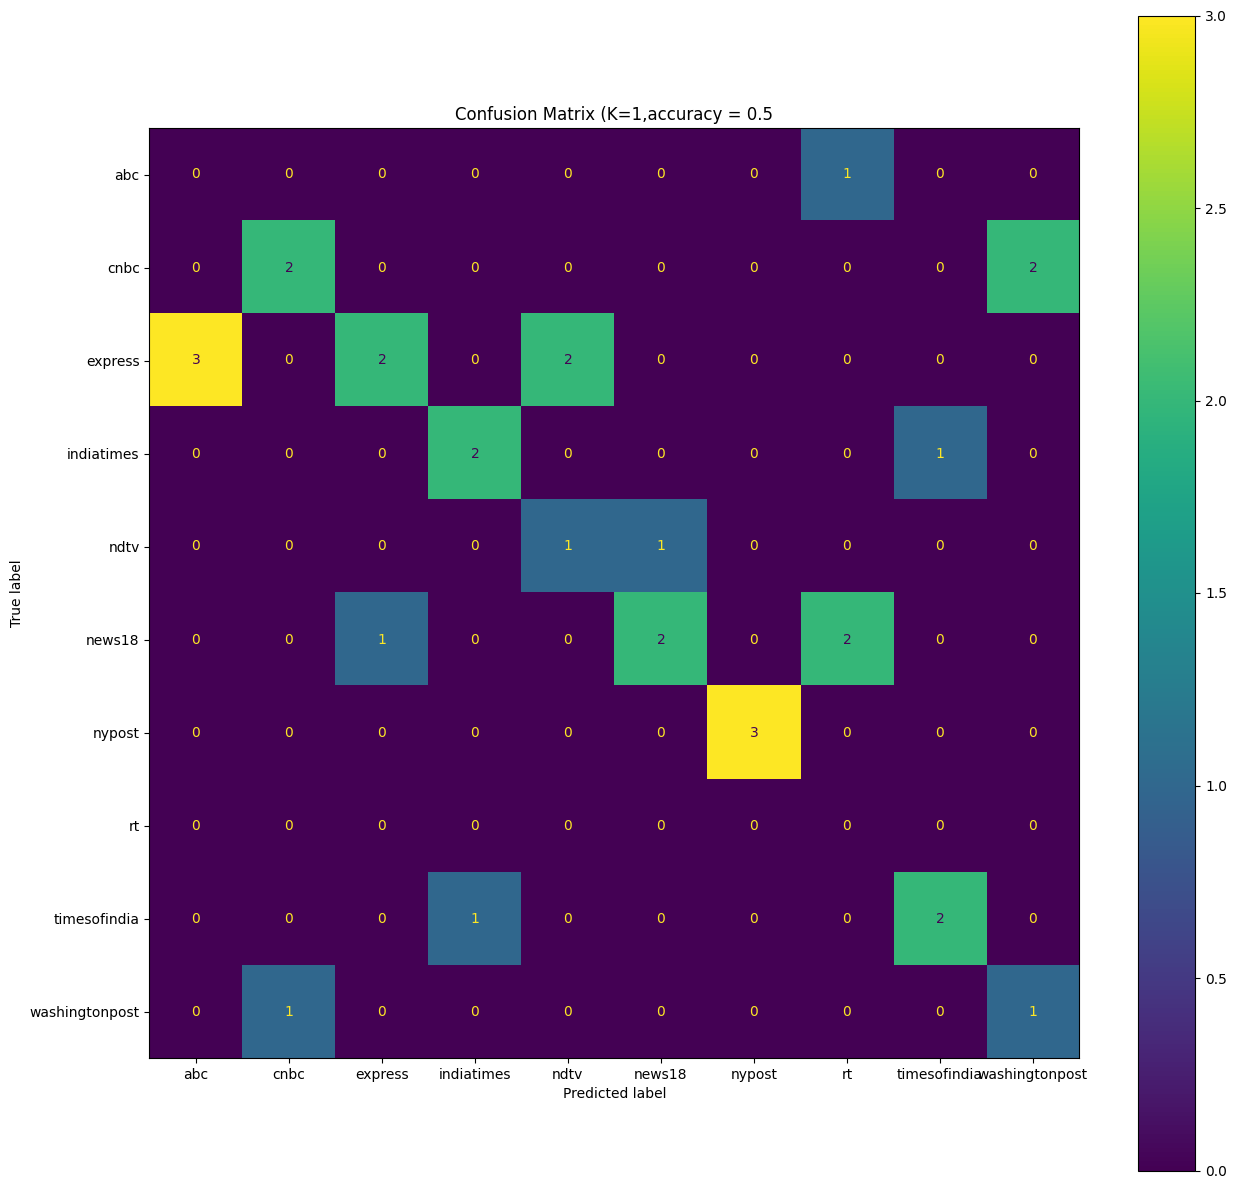

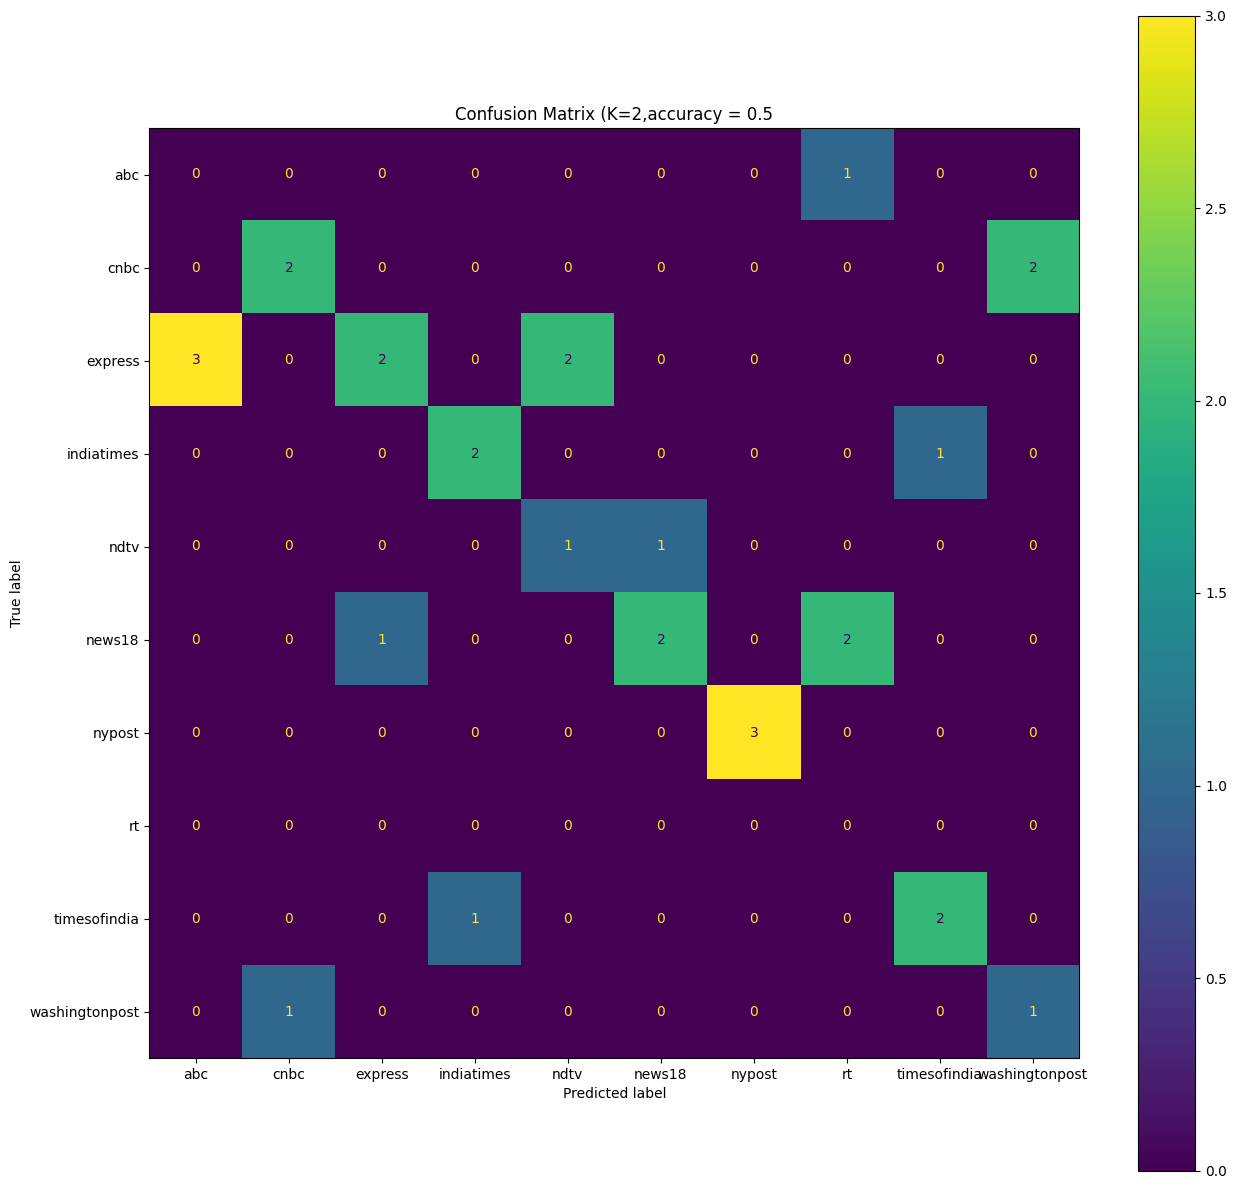

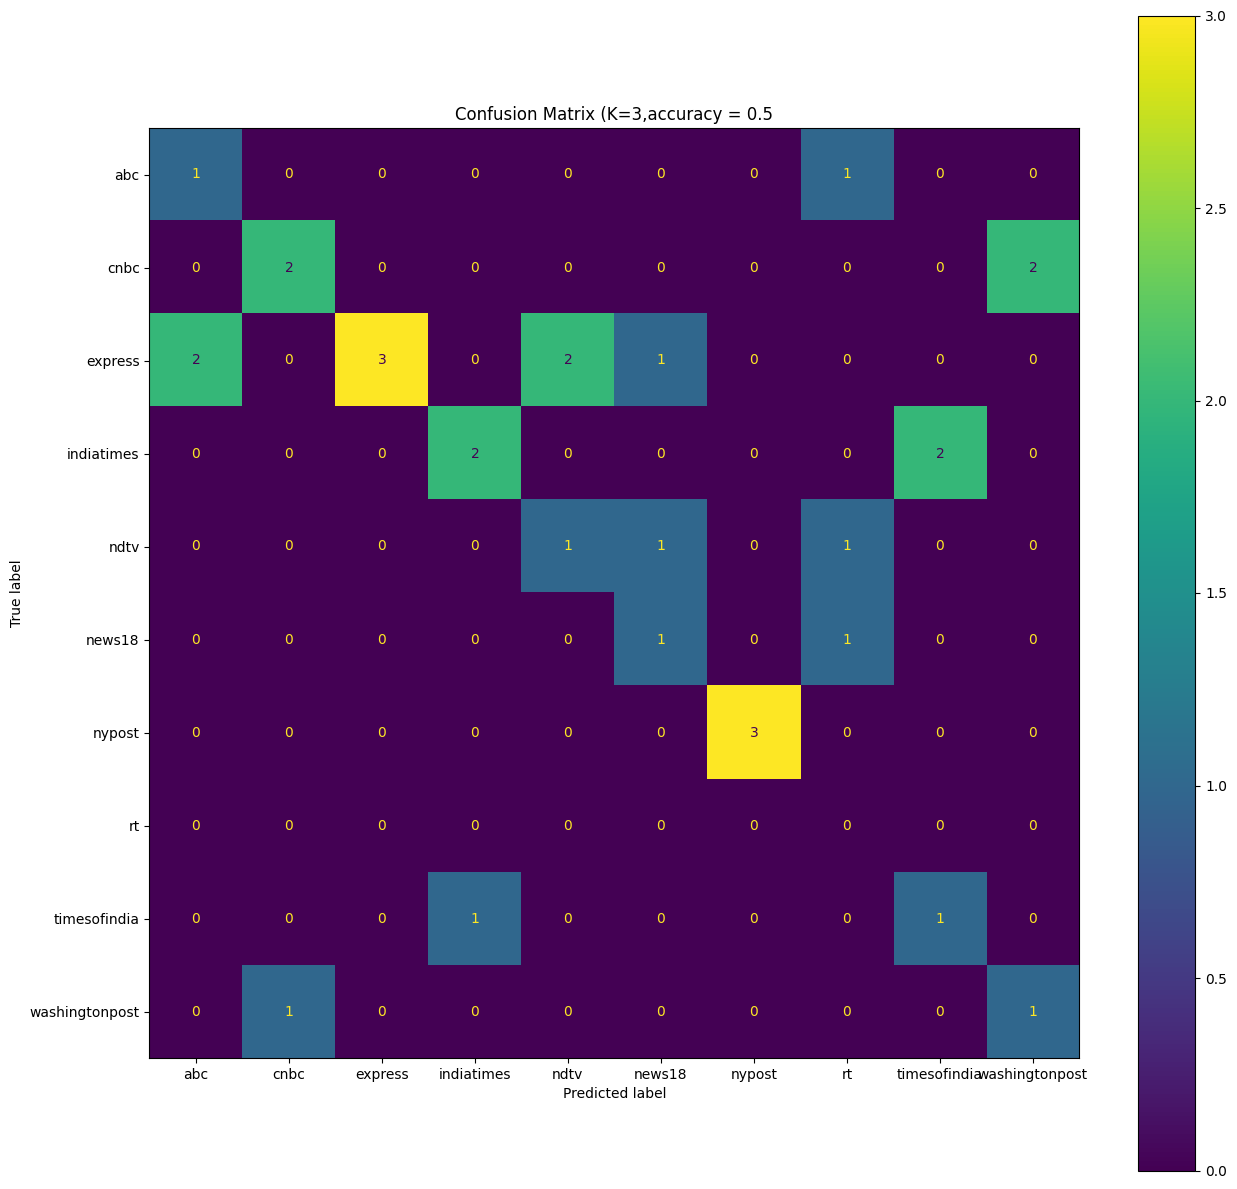

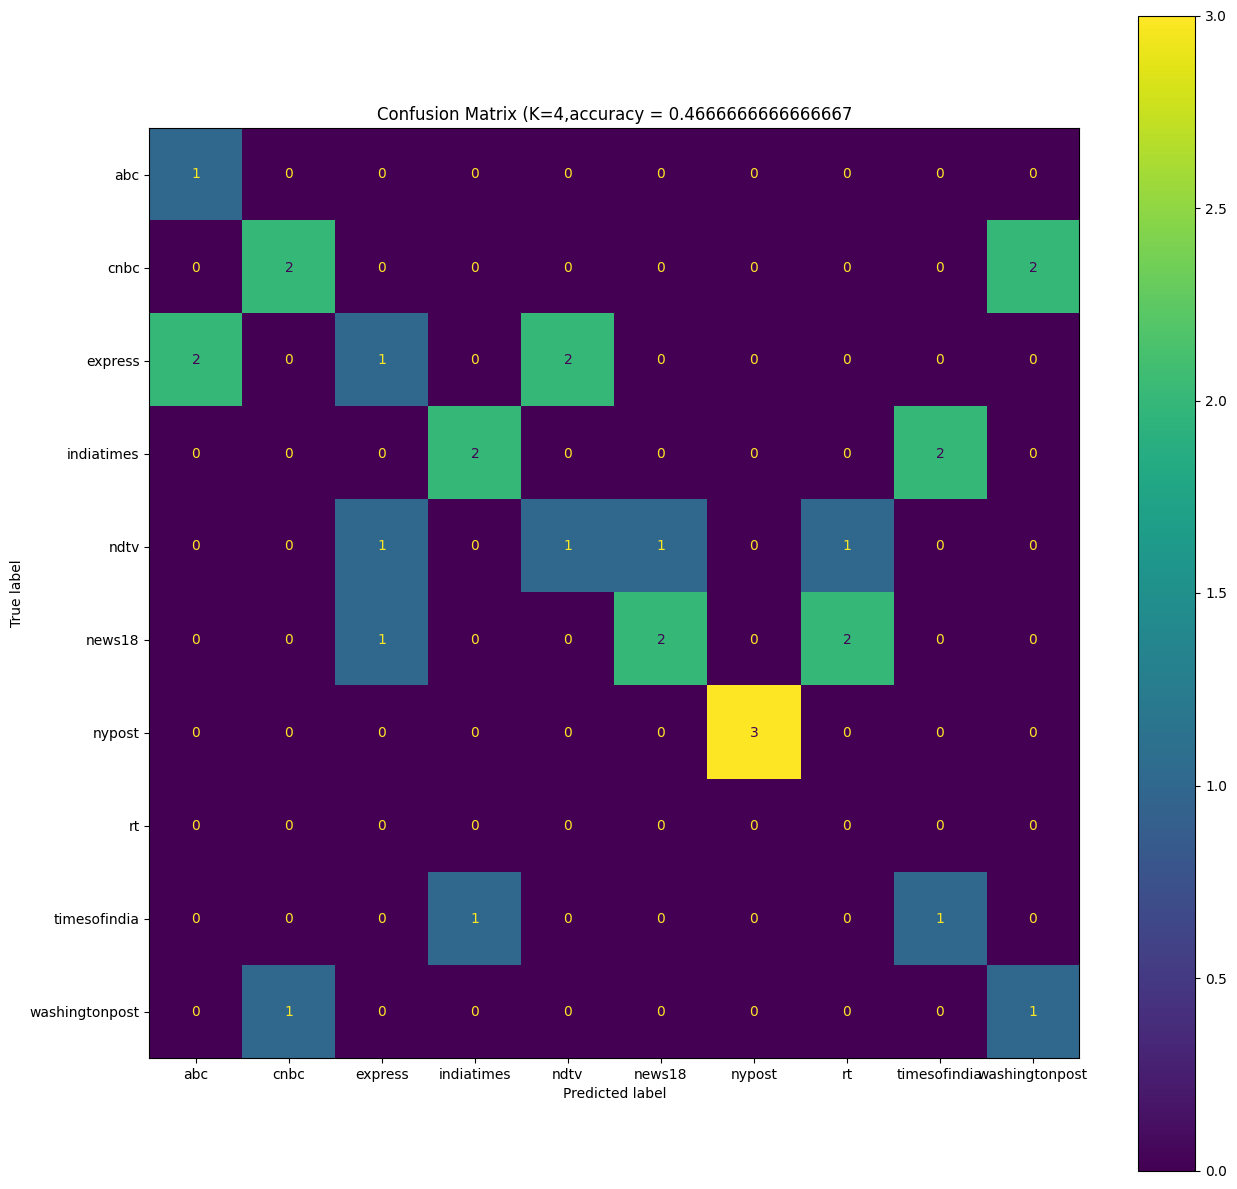

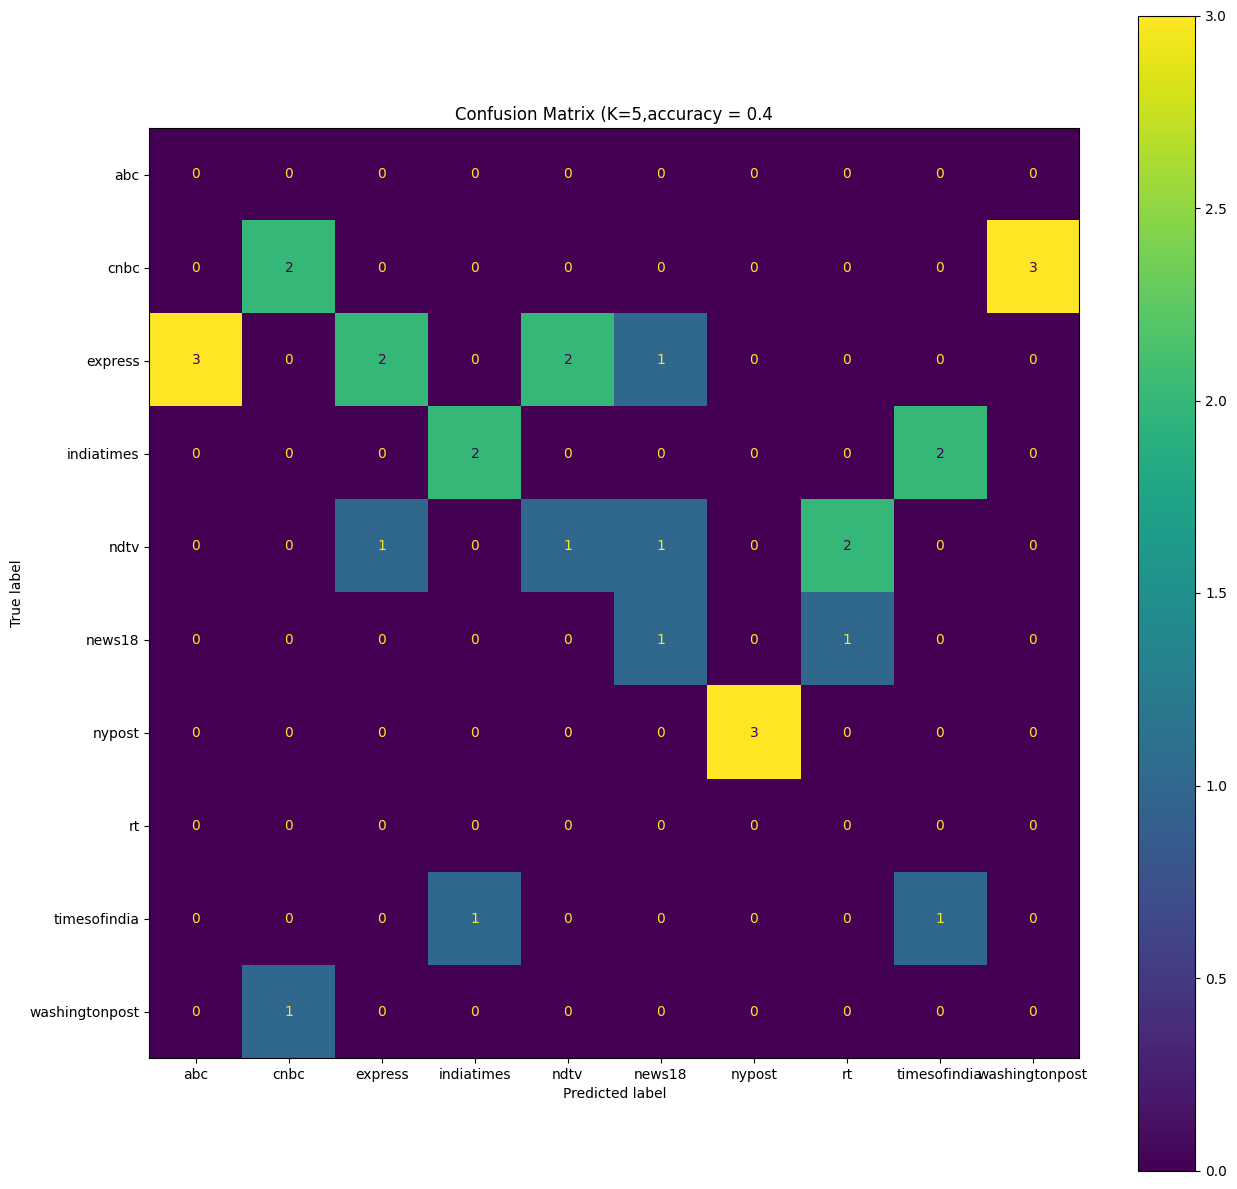

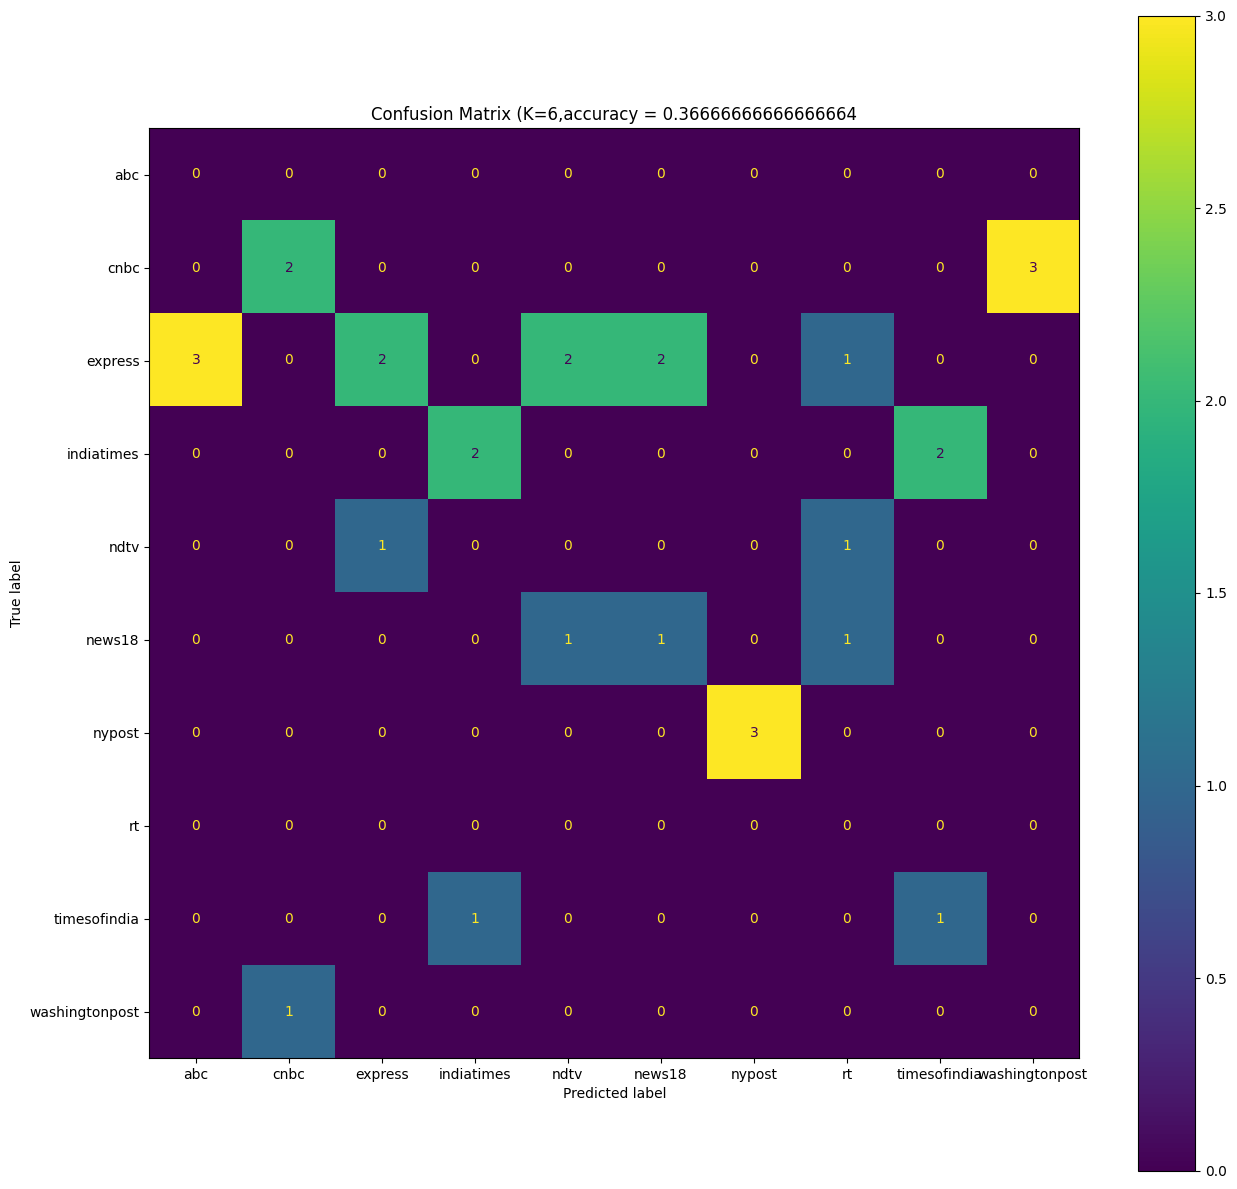

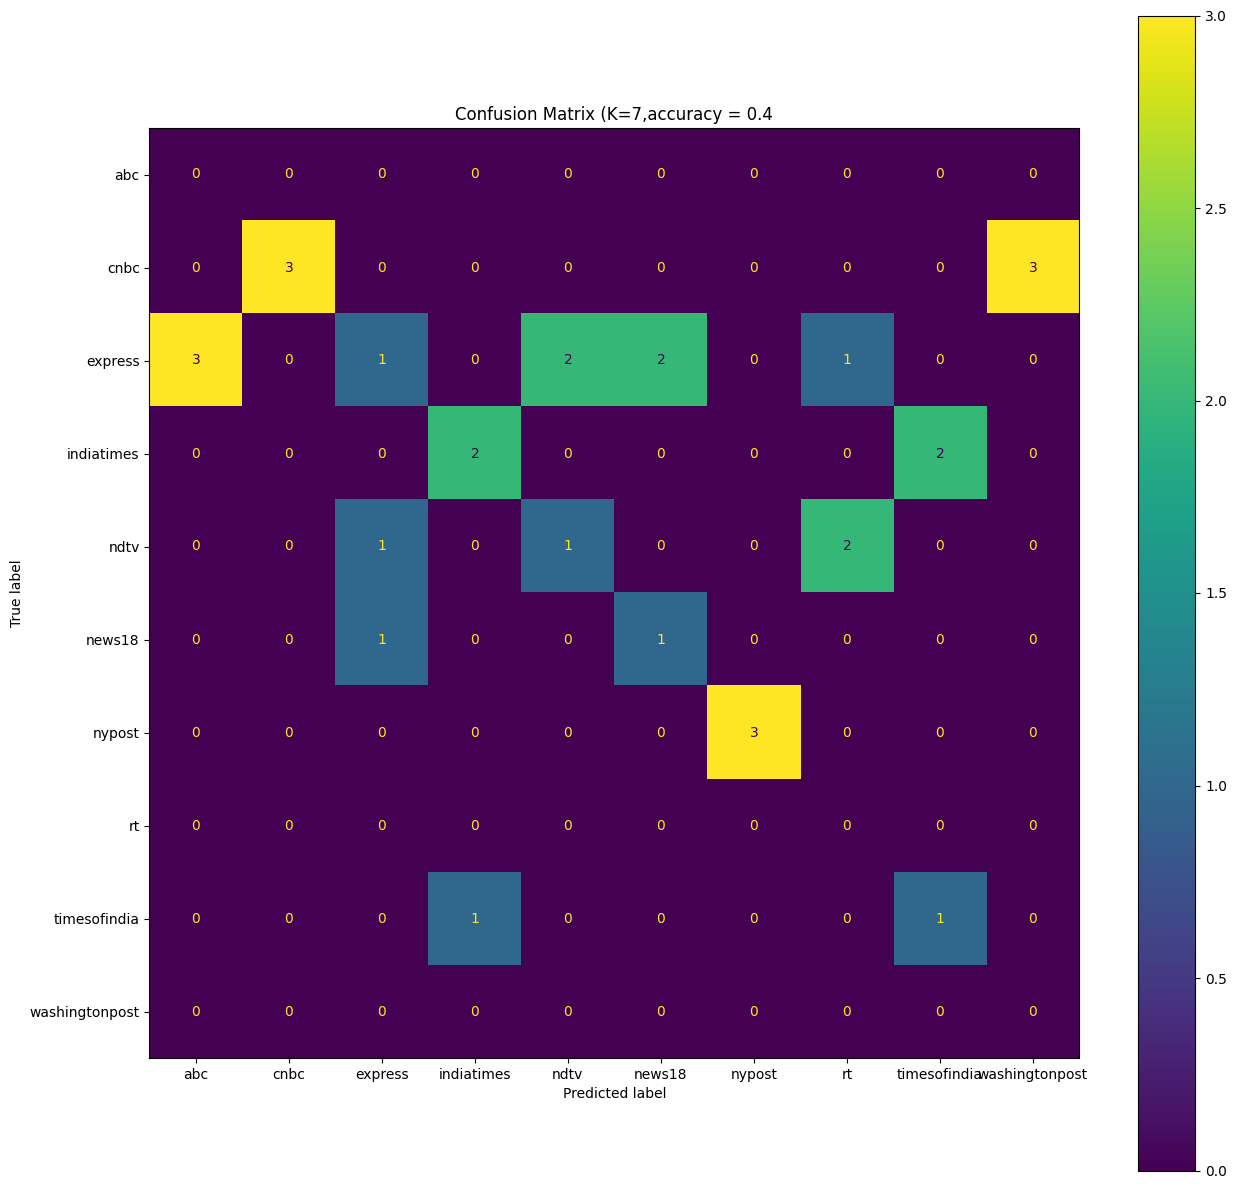

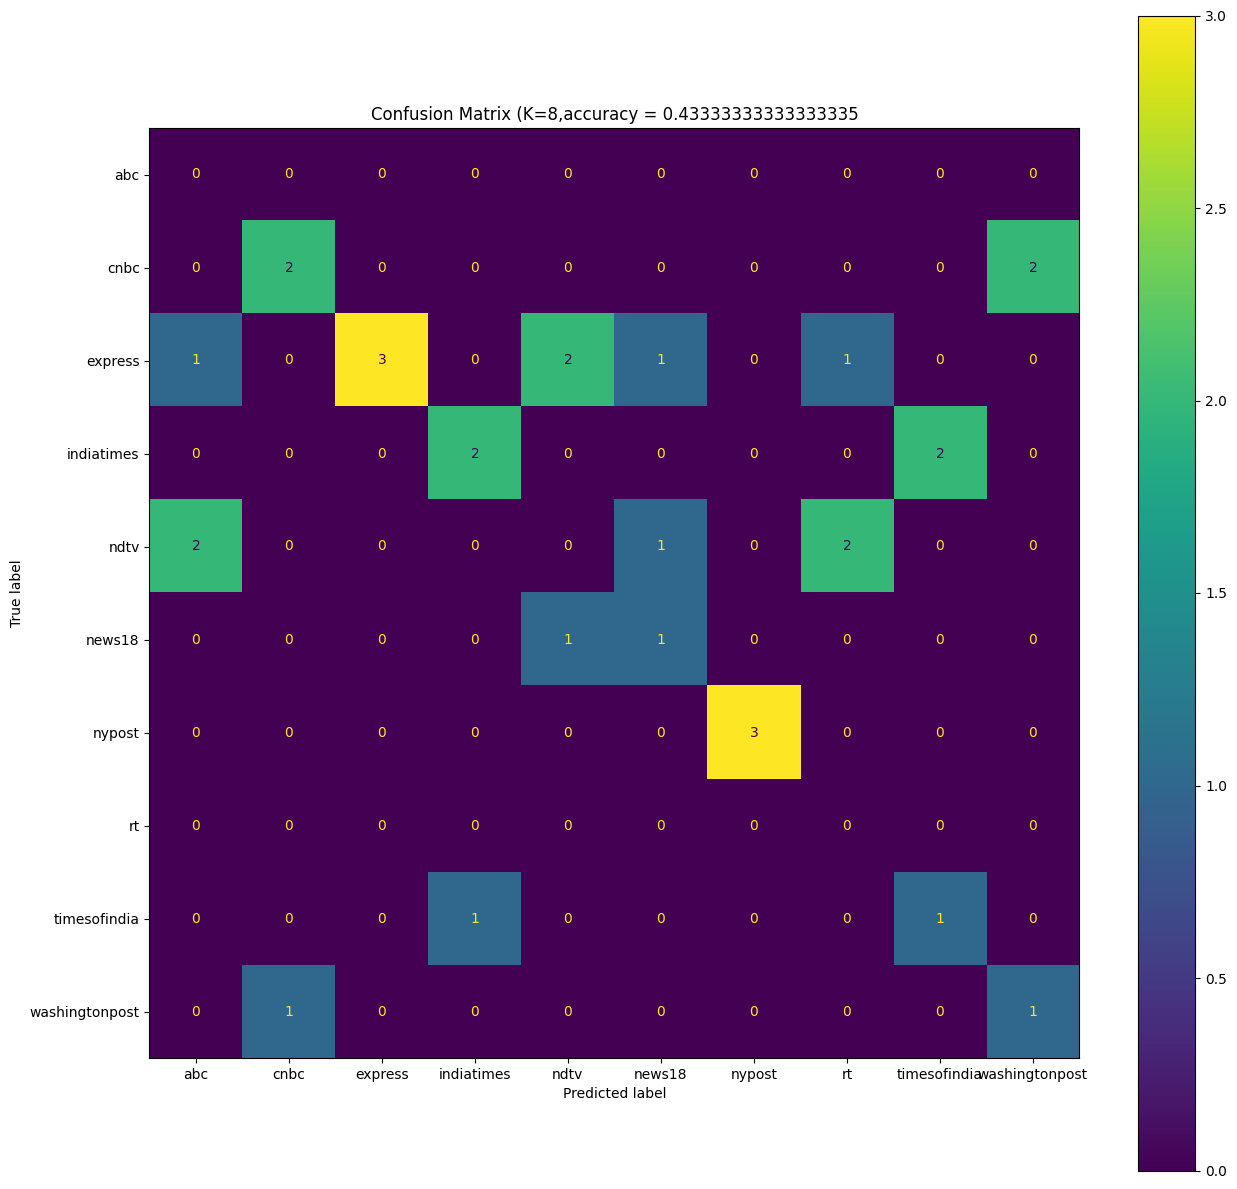

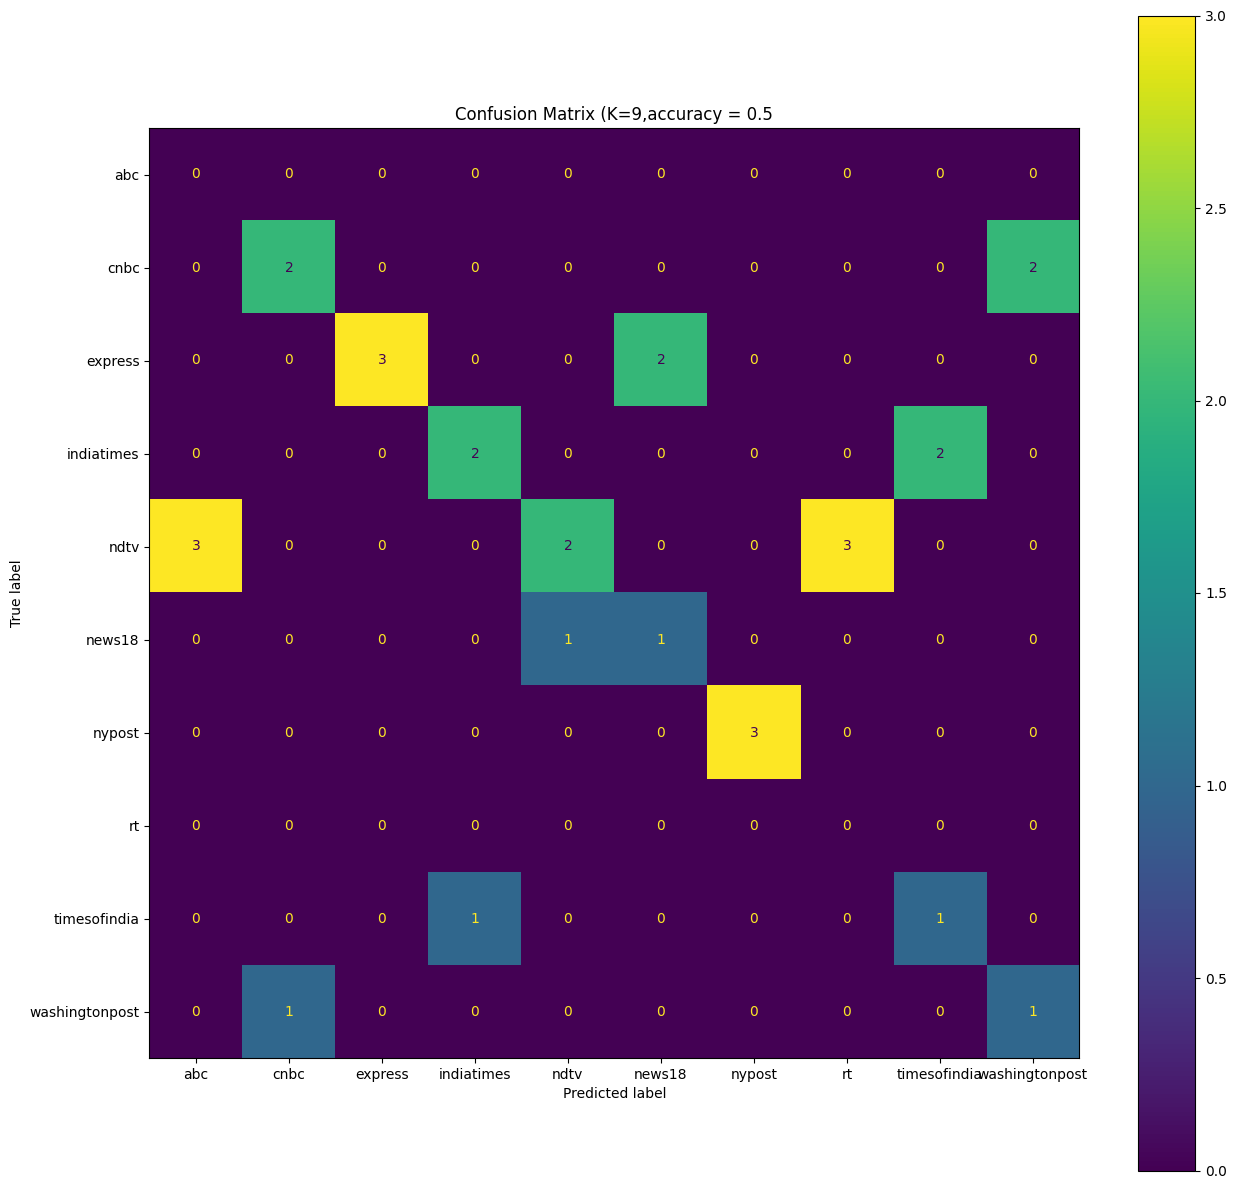

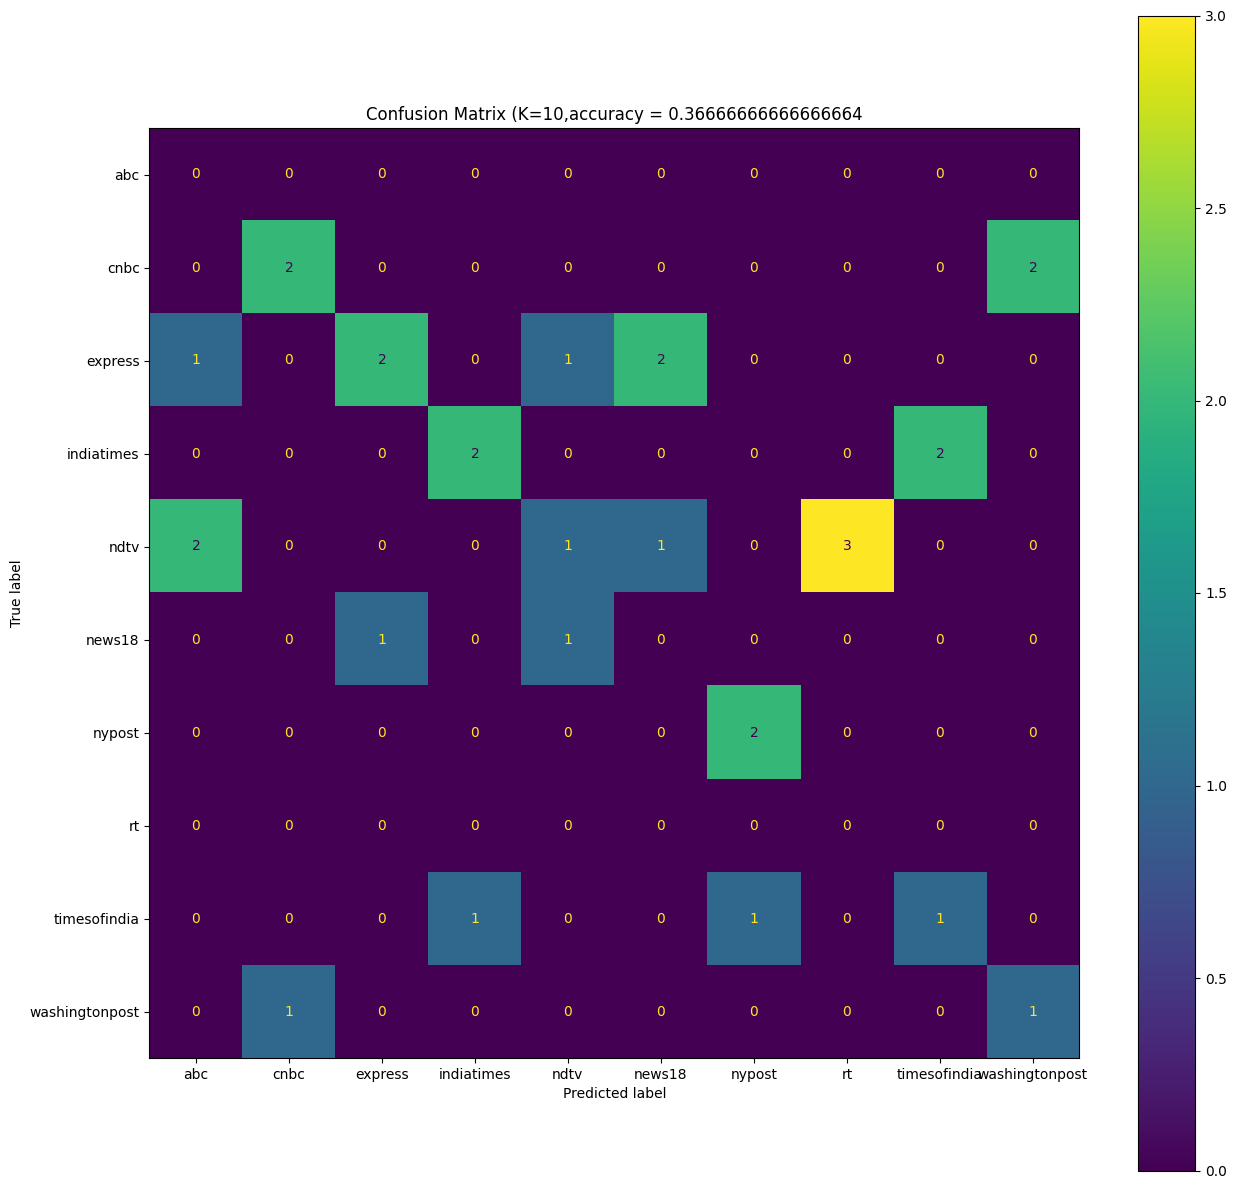

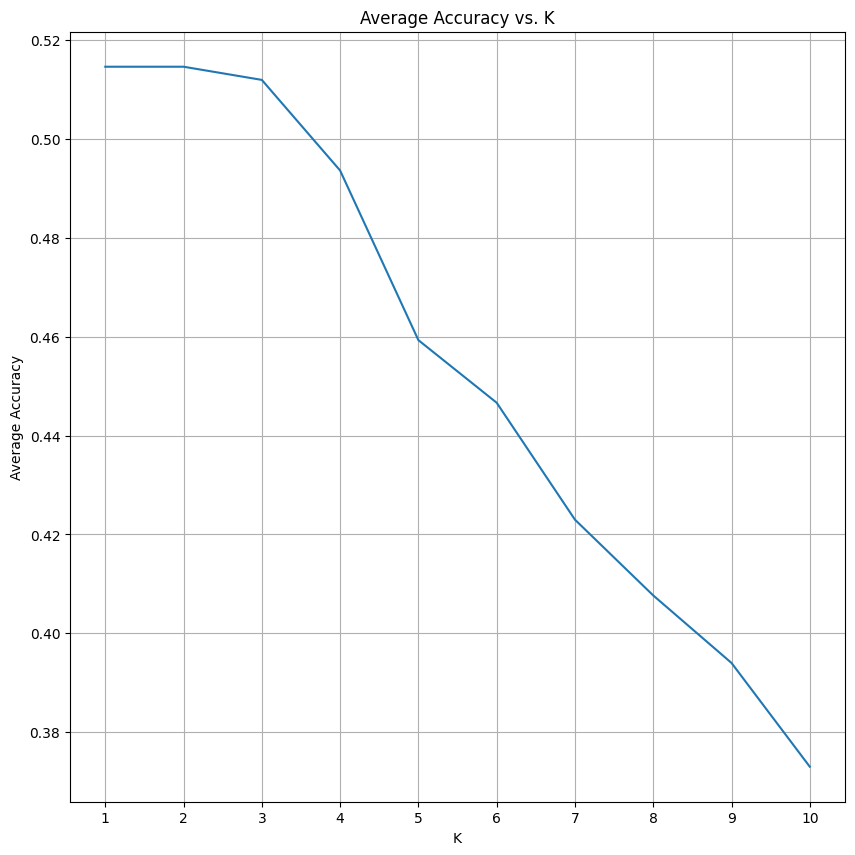

In [13]:
y_label = [0,0,0,0,0,0,0,0,0,0]
x_label = [1,2,3,4,5,6,7,8,9,10]
for i in range(0, 100):
  X = dataset.dropna()
  Y = dataset_test.dropna()
  APP_X = X['app']
  X = X.drop(['app'], axis=1)
  APP_Y = Y['app']
  Y = Y.drop(['app'], axis=1)


  idx = np.random.permutation(len(X))
  num_train_obs = np.floor(0.7 * len(X))

  train_idx = idx[1:int(num_train_obs)]

  # normalization Actually standardization
  X_norm = pd.DataFrame()
  for key in X:
      temp = X[key]
      temp_norm = (temp - temp.mean()) / temp.std()
      X_norm[key] = temp_norm

  Y_norm = pd.DataFrame()
  for key in Y:
      temp = Y[key]
      temp_norm = (temp - temp.mean()) / temp.std()
      Y_norm[key] = temp_norm
  # split train / test
  X_norm_train = X_norm.iloc[train_idx]
  APP_train = APP_X.iloc[train_idx]
  Y_label = K_NN(Y_norm,X_norm_train,APP_Y, APP_train, i)
  y_label = [a + b for a, b in zip(Y_label, y_label)]

y_label = y_label = [value * 0.01 for value in y_label]
plt.figure(figsize=(10, 10))
plt.plot(x_label, y_label)
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.title("Average Accuracy vs. K")
plt.xlabel("K")
plt.ylabel("Average Accuracy")
print(f"The accuracy of KNN is {y_label}")

# ***Evaluate the performance obtained using the old training set and 	  	    comment the results.***
We can see that the accuracy of old dataset is higher than the new data set.
And the higher k is, the lower accurace is. If the K is bigger than 2, the performance is decreased significantly.

1.   Firstly, the new data is collected after 1 day comparing the old data, so some values will be changed. The model trained from old dataset will not represent the feature of new data absolutly.
2.   Secondly,if the k is bigger,  we have to consider more points. In
this case, because of the samll number of data in our dataset, the performance
is not very well.
3.   Finally, I find the accuracy is changed in different running, because we randomly get the traning and testing dataset, and the total data is 100. It will change the percentage of different websites's data. I think this is not balance, so I run the knn 100 times and calaulate the average accuracy to avoid the influence.

# Some works in the literature propose to use the following feature for fingeprinting:
Look at the trace of packet sizes exchanged in the client-server exchange (p1,p2…,pn), removing TCP ACKS\
p > 0 indicates an incoming packet, p < 0 an outgoing packet\
Produce a cumulative trace C, where C(1) = p1, C(2) = p1+p2, C(3) = p1+p2+p3\
Sample the piecewise linear interpolant of C at M equidistant points


In [14]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d


def cumulative_trace(df, filename):
  cumulative_list = []
  cumulative_trace = {}
  cumulative = 0
  for i in range(7, len(df)):
    row = df.iloc[i]
    if row['tcp.flags']=="0x0010":
      continue
    if row["ip.src"].split('.')[0] == "172":
      cumulative-=row["ip.len"]
    else:
      cumulative+=row["ip.len"]
    cumulative_list.append(cumulative)
  cumulative_array = np.array(cumulative_list)
  num_points = len(cumulative_array)
  indices = np.linspace(0, num_points - 1, num_points)
  new_indices = np.linspace(0, num_points - 1, 20)
  interpolated_data = np.interp(new_indices, indices, cumulative_array)
  for i in range(0, len(interpolated_data)):
    cumulative_trace[f'{i + 1}'] = interpolated_data[i]
  cumulative_trace["app"] = filename.split('.')[1]
  return cumulative_trace


In [15]:
csv_dir = '/content/drive/MyDrive/Csv'

cumulative_result_list = []
for csv_name in os.listdir(csv_dir):
  print("Processing the file:", csv_name)
  df = pd.read_csv(csv_dir +'/'+ csv_name)
  df_tcp = df[df["ip.proto"]==6]
  cumulative = cumulative_trace(df_tcp, csv_name)
  display(cumulative)
  cumulative_result_list.append(pd.DataFrame([cumulative]))


cumulative_dataset = pd.DataFrame()
cumulative_dataset = pd.concat(cumulative_result_list, ignore_index=True)

display(cumulative_dataset)

Processing the file: www.rt.com_6_pyshark.csv


{'1': -132.0,
 '2': -207.8421052631578,
 '3': 15856.473684210536,
 '4': 40442.47368421053,
 '5': 42903.63157894737,
 '6': 43172.78947368421,
 '7': 68533.21052631582,
 '8': 87941.1052631579,
 '9': 90410.26315789473,
 '10': 90587.42105263157,
 '11': 127287.42105263157,
 '12': 177431.73684210525,
 '13': 179908.8947368421,
 '14': 179994.05263157896,
 '15': 205783.78947368424,
 '16': 235067.36842105264,
 '17': 237552.52631578947,
 '18': 237545.68421052632,
 '19': 272922.15789473685,
 '20': 282567.0,
 'app': 'rt'}

Processing the file: www.express.co.uk_1_pyshark.csv


{'1': 1318.0,
 '2': 166177.05263157896,
 '3': 423015.7368421053,
 '4': 614822.5789473684,
 '5': 858707.8421052631,
 '6': 1079275.4210526317,
 '7': 1312781.2631578948,
 '8': 1498093.4736842106,
 '9': 1750140.6842105263,
 '10': 1977529.315789474,
 '11': 2194388.1052631577,
 '12': 2429292.526315789,
 '13': 2637370.5263157897,
 '14': 2940606.6842105263,
 '15': 3099010.1578947366,
 '16': 3401406.3684210526,
 '17': 3545049.736842105,
 '18': 3868213.0,
 '19': 3988476.631578948,
 '20': 4292546.0,
 'app': 'express'}

Processing the file: www.abc.net.au_7_pyshark.csv


{'1': 1252.0,
 '2': 18526.578947368424,
 '3': 72306.36842105264,
 '4': 146017.05263157896,
 '5': 219154.73684210528,
 '6': 235816.63157894736,
 '7': 256373.47368421053,
 '8': 311067.7894736842,
 '9': 384778.47368421056,
 '10': 461124.1578947369,
 '11': 466939.0,
 '12': 500014.36842105264,
 '13': 563372.2105263158,
 '14': 635482.8947368423,
 '15': 690715.0,
 '16': 694775.1052631579,
 '17': 737861.2631578947,
 '18': 788659.8421052633,
 '19': 856179.2105263161,
 '20': 925024.0,
 'app': 'abc'}

Processing the file: www.ndtv.com_7_pyshark.csv


{'1': 827.0,
 '2': 30546.52631578947,
 '3': 91989.05263157895,
 '4': 192037.0,
 '5': 370749.947368421,
 '6': 406565.36842105264,
 '7': 451162.15789473685,
 '8': 524036.2631578947,
 '9': 623279.2105263157,
 '10': 808518.8421052631,
 '11': 816572.2631578947,
 '12': 875627.7894736842,
 '13': 937070.3157894737,
 '14': 1050640.8421052631,
 '15': 1207754.0,
 '16': 1216434.894736842,
 '17': 1277877.4210526315,
 '18': 1339319.9473684211,
 '19': 1461807.1052631577,
 '20': 1588057.0,
 'app': 'ndtv'}

Processing the file: www.rt.com_7_pyshark.csv


{'1': -132.0,
 '2': -523.1578947368421,
 '3': 538.5789473684209,
 '4': 42511.999999999985,
 '5': 44818.63157894737,
 '6': 47388.73684210526,
 '7': 46992.05263157895,
 '8': 47943.52631578947,
 '9': 113917.26315789467,
 '10': 134312.42105263157,
 '11': 136901.47368421053,
 '12': 136499.26315789475,
 '13': 137257.57894736843,
 '14': 173432.4736842104,
 '15': 191951.2105263158,
 '16': 194559.2105263158,
 '17': 194151.47368421053,
 '18': 194858.73684210525,
 '19': 232966.6315789474,
 '20': 239454.0,
 'app': 'rt'}

Processing the file: www.rt.com_8_pyshark.csv


{'1': -132.0,
 '2': -408.8421052631579,
 '3': 77.6315789473685,
 '4': 514.2105263157895,
 '5': 66431.26315789476,
 '6': 86830.63157894737,
 '7': 86648.36842105263,
 '8': 89320.21052631579,
 '9': 89042.47368421052,
 '10': 89633.0,
 '11': 89745.36842105263,
 '12': 140262.2631578948,
 '13': 144467.31578947368,
 '14': 144121.63157894736,
 '15': 146917.42105263157,
 '16': 146636.26315789475,
 '17': 147286.0,
 '18': 154691.1578947368,
 '19': 192036.0,
 '20': 191968.0,
 'app': 'rt'}

Processing the file: www.washingtonpost.com_7_pyshark.csv


{'1': 1164.0,
 '2': 78936.05263157895,
 '3': 351571.84210526315,
 '4': 1061872.6315789474,
 '5': 1650580.894736842,
 '6': 1933320.0,
 '7': 1996710.4736842106,
 '8': 2153049.0,
 '9': 2767564.3157894737,
 '10': 3327639.052631579,
 '11': 3379130.789473684,
 '12': 3577766.1578947366,
 '13': 4235526.0,
 '14': 4786535.157894737,
 '15': 5031532.157894737,
 '16': 5225698.421052632,
 '17': 5282037.263157895,
 '18': 5466040.210526316,
 '19': 6118175.0,
 '20': 6646426.0,
 'app': 'washingtonpost'}

Processing the file: www.ndtv.com_8_pyshark.csv


{'1': 827.0,
 '2': 15181.894736842107,
 '3': 61772.78947368421,
 '4': 117838.26315789472,
 '5': 183658.68421052632,
 '6': 317230.2631578948,
 '7': 402263.36842105264,
 '8': 410374.2631578947,
 '9': 455517.15789473685,
 '10': 500151.05263157893,
 '11': 549586.2105263158,
 '12': 644442.8421052631,
 '13': 778928.9473684209,
 '14': 804497.7368421053,
 '15': 825597.5263157894,
 '16': 871679.4210526316,
 '17': 917761.3157894737,
 '18': 980457.105263158,
 '19': 1092232.4736842103,
 '20': 1181859.0,
 'app': 'ndtv'}

Processing the file: www.express.co.uk_6_pyshark.csv


{'1': 1318.0,
 '2': 53482.94736842105,
 '3': 156978.31578947368,
 '4': 314888.00000000006,
 '5': 437604.15789473685,
 '6': 491444.7368421052,
 '7': 608745.5789473684,
 '8': 812001.9473684211,
 '9': 861328.5789473684,
 '10': 949867.5263157894,
 '11': 1062306.6842105263,
 '12': 1263507.3157894737,
 '13': 1298024.3684210528,
 '14': 1392821.0,
 '15': 1519295.105263158,
 '16': 1707513.7368421052,
 '17': 1741881.1578947369,
 '18': 1831171.6842105263,
 '19': 1984275.2105263155,
 '20': 2131904.0,
 'app': 'express'}

Processing the file: www.abc.net.au_1_pyshark.csv


{'1': 1252.0,
 '2': 102079.57894736844,
 '3': 226960.73684210525,
 '4': 332461.7368421053,
 '5': 452685.3157894737,
 '6': 597865.2631578948,
 '7': 696701.6315789474,
 '8': 877261.6842105266,
 '9': 953526.8421052633,
 '10': 1134445.3684210526,
 '11': 1211931.7894736845,
 '12': 1368889.894736842,
 '13': 1449552.9473684211,
 '14': 1603334.4210526317,
 '15': 1675589.1052631582,
 '16': 1834838.3684210526,
 '17': 1917046.263157895,
 '18': 2061995.4736842106,
 '19': 2139192.8947368423,
 '20': 2296255.0,
 'app': 'abc'}

Processing the file: www.express.co.uk_9_pyshark.csv


{'1': 1318.0,
 '2': 3776.5263157894747,
 '3': 39775.05263157895,
 '4': 77201.57894736843,
 '5': 116807.68421052632,
 '6': 163704.10526315792,
 '7': 211727.8947368421,
 '8': 282148.7368421052,
 '9': 371810.0,
 '10': 427219.5789473684,
 '11': 431978.5263157895,
 '12': 444894.7894736842,
 '13': 477210.5789473684,
 '14': 515463.8421052632,
 '15': 552664.8947368421,
 '16': 596085.157894737,
 '17': 670737.6842105263,
 '18': 733133.5789473684,
 '19': 787816.3684210528,
 '20': 851577.0,
 'app': 'express'}

Processing the file: www.news18.com_10_pyshark.csv


{'1': 1252.0,
 '2': 1998.5263157894738,
 '3': 4013.947368421053,
 '4': 21228.421052631576,
 '5': 39381.89473684211,
 '6': 56087.36842105263,
 '7': 74240.84210526316,
 '8': 92394.3157894737,
 '9': 110547.78947368421,
 '10': 129310.94736842104,
 '11': 157829.05263157896,
 '12': 190310.10526315792,
 '13': 234679.99999999997,
 '14': 282784.2105263158,
 '15': 331574.3157894737,
 '16': 404065.8947368421,
 '17': 491342.3157894737,
 '18': 551840.7894736842,
 '19': 631538.2105263158,
 '20': 631486.0,
 'app': 'news18'}

Processing the file: www.washingtonpost.com_2_pyshark.csv


{'1': 1164.0,
 '2': 561402.4210526316,
 '3': 1352539.4736842106,
 '4': 2381317.9473684216,
 '5': 3101277.4736842103,
 '6': 3969594.789473684,
 '7': 4899704.631578947,
 '8': 5416785.421052632,
 '9': 6023126.052631579,
 '10': 7100835.631578947,
 '11': 7613091.47368421,
 '12': 8625007.578947369,
 '13': 9749545.842105266,
 '14': 10540056.578947369,
 '15': 11017992.052631581,
 '16': 11936775.263157895,
 '17': 12914411.0,
 '18': 13712627.368421054,
 '19': 13956583.315789474,
 '20': 15217831.0,
 'app': 'washingtonpost'}

Processing the file: www.timesofindia.com_1_pyshark.csv


{'1': 1252.0,
 '2': 2445.0,
 '3': 6241.684210526316,
 '4': 7213.315789473684,
 '5': 10958.78947368421,
 '6': 12044.315789473685,
 '7': 15730.684210526315,
 '8': 16726.736842105263,
 '9': 20492.57894736842,
 '10': 21478.947368421053,
 '11': 25253.473684210527,
 '12': 26280.894736842107,
 '13': 29923.78947368421,
 '14': 31096.36842105263,
 '15': 34698.42105263158,
 '16': 35858.57894736842,
 '17': 39433.52631578947,
 '18': 40620.78947368421,
 '19': 44156.84210526316,
 '20': 45384.0,
 'app': 'timesofindia'}

Processing the file: www.abc.net.au_6_pyshark.csv


{'1': 1252.0,
 '2': 31715.0,
 '3': 105838.0,
 '4': 200672.0,
 '5': 235619.0,
 '6': 274993.0,
 '7': 357804.0,
 '8': 448730.0,
 '9': 469916.0,
 '10': 513926.0,
 '11': 596307.0,
 '12': 692319.0,
 '13': 702080.0,
 '14': 758732.0,
 '15': 848783.0,
 '16': 925121.0,
 '17': 932730.0,
 '18': 997586.0,
 '19': 1067365.0,
 '20': 1159458.0,
 'app': 'abc'}

Processing the file: www.abc.net.au_2_pyshark.csv


{'1': 1252.0,
 '2': 81429.0,
 '3': 225331.0,
 '4': 300405.0,
 '5': 446035.0,
 '6': 529935.0,
 '7': 679890.0,
 '8': 762930.0,
 '9': 912407.0,
 '10': 992074.0,
 '11': 1143162.0,
 '12': 1197940.0,
 '13': 1353123.0,
 '14': 1401497.0,
 '15': 1542630.0,
 '16': 1613235.0,
 '17': 1744232.0,
 '18': 1839887.0,
 '19': 1926429.0,
 '20': 2070613.0,
 'app': 'abc'}

Processing the file: www.express.co.uk_10_pyshark.csv


{'1': 1318.0,
 '2': 885.4736842105262,
 '3': 1151.3157894736842,
 '4': 17543.157894736847,
 '5': 35877.89473684211,
 '6': 48801.26315789475,
 '7': 67286.3157894737,
 '8': 87199.36842105264,
 '9': 105670.52631578948,
 '10': 124695.57894736844,
 '11': 146412.4210526316,
 '12': 168711.63157894742,
 '13': 200071.52631578952,
 '14': 242907.7368421053,
 '15': 277175.9473684211,
 '16': 303005.3157894737,
 '17': 329235.7368421053,
 '18': 358167.4736842107,
 '19': 409940.2105263159,
 '20': 420574.0,
 'app': 'express'}

Processing the file: www.indiatimes.com_1_pyshark.csv


{'1': 1252.0,
 '2': 3217.6315789473683,
 '3': 5560.78947368421,
 '4': 8349.526315789473,
 '5': 12495.684210526315,
 '6': 14150.157894736842,
 '7': 19061.78947368421,
 '8': 19590.842105263157,
 '9': 24504.36842105263,
 '10': 25118.315789473683,
 '11': 30029.736842105263,
 '12': 30659.84210526316,
 '13': 35432.78947368421,
 '14': 36199.57894736842,
 '15': 40902.42105263158,
 '16': 41686.05263157895,
 '17': 46315.84210526316,
 '18': 47182.21052631579,
 '19': 51705.47368421053,
 '20': 52659.0,
 'app': 'indiatimes'}

Processing the file: www.washingtonpost.com_9_pyshark.csv


{'1': 1164.0,
 '2': 16686.052631578947,
 '3': 68237.57894736843,
 '4': 150141.15789473685,
 '5': 314199.6842105263,
 '6': 627894.2105263157,
 '7': 1011589.0,
 '8': 1357377.5263157894,
 '9': 1492395.894736842,
 '10': 1623795.105263158,
 '11': 1738388.894736842,
 '12': 1856394.4210526317,
 '13': 1863791.6315789474,
 '14': 1912733.2631578948,
 '15': 1977337.0526315789,
 '16': 2096736.210526316,
 '17': 2317542.1578947366,
 '18': 2748871.0,
 '19': 2943863.52631579,
 '20': 3277122.0,
 'app': 'washingtonpost'}

Processing the file: www.abc.net.au_10_pyshark.csv


{'1': 1252.0,
 '2': 1069.2631578947369,
 '3': 1595.6842105263158,
 '4': 3630.4210526315765,
 '5': 15887.894736842107,
 '6': 28145.368421052633,
 '7': 40402.84210526315,
 '8': 52660.31578947368,
 '9': 64917.78947368421,
 '10': 77175.26315789473,
 '11': 89432.73684210527,
 '12': 100821.21052631579,
 '13': 113078.6842105263,
 '14': 126860.36842105264,
 '15': 145138.47368421053,
 '16': 168294.05263157896,
 '17': 192592.7894736842,
 '18': 224665.00000000006,
 '19': 231966.0,
 '20': 231910.0,
 'app': 'abc'}

Processing the file: www.news18.com_9_pyshark.csv


{'1': 1252.0,
 '2': 2000.0,
 '3': 2755.2631578947367,
 '4': 16582.73684210526,
 '5': 32874.31578947368,
 '6': 49165.89473684211,
 '7': 65457.47368421052,
 '8': 82739.7894736842,
 '9': 107033.47368421052,
 '10': 131327.15789473685,
 '11': 158897.8947368421,
 '12': 193480.0,
 '13': 235606.94736842104,
 '14': 284059.3684210526,
 '15': 337465.4736842105,
 '16': 392167.1578947368,
 '17': 471942.10526315786,
 '18': 563682.1052631579,
 '19': 641239.0,
 '20': 641195.0,
 'app': 'news18'}

Processing the file: www.timesofindia.com_8_pyshark.csv


{'1': 1252.0,
 '2': 1257.157894736842,
 '3': 1834.157894736842,
 '4': 2401.1052631578946,
 '5': 2411.2105263157896,
 '6': 2396.8947368421054,
 '7': 1939.8421052631575,
 '8': 6116.947368421053,
 '9': 6005.263157894737,
 '10': 6820.263157894737,
 '11': 7182.684210526316,
 '12': 7215.9473684210525,
 '13': 7189.631578947368,
 '14': 7087.15789473684,
 '15': 10346.736842105267,
 '16': 10872.368421052632,
 '17': 11266.263157894738,
 '18': 11977.263157894737,
 '19': 11982.947368421053,
 '20': 11976.0,
 'app': 'timesofindia'}

Processing the file: www.indiatimes.com_6_pyshark.csv


{'1': 1252.0,
 '2': 2274.8947368421054,
 '3': 3146.6315789473683,
 '4': 3154.6315789473683,
 '5': 7580.6315789473665,
 '6': 7727.736842105263,
 '7': 8712.42105263158,
 '8': 8652.473684210527,
 '9': 12474.263157894733,
 '10': 13260.526315789475,
 '11': 14205.157894736842,
 '12': 14150.315789473685,
 '13': 18802.894736842096,
 '14': 18710.315789473687,
 '15': 19701.315789473683,
 '16': 19639.736842105263,
 '17': 24634.78947368421,
 '18': 24211.263157894737,
 '19': 25177.526315789473,
 '20': 25146.0,
 'app': 'indiatimes'}

Processing the file: www.rt.com_9_pyshark.csv


{'1': -132.0,
 '2': -315.0526315789474,
 '3': -493.9473684210526,
 '4': -11.578947368421098,
 '5': 293.57894736842104,
 '6': 5456.263157894709,
 '7': 29310.578947368413,
 '8': 55011.0,
 '9': 54989.31578947369,
 '10': 54977.73684210526,
 '11': 55776.73684210525,
 '12': 57465.21052631579,
 '13': 57282.84210526316,
 '14': 57099.84210526316,
 '15': 57700.63157894737,
 '16': 57938.42105263158,
 '17': 74372.10526315786,
 '18': 97825.7894736842,
 '19': 102481.78947368421,
 '20': 102490.0,
 'app': 'rt'}

Processing the file: www.ndtv.com_1_pyshark.csv


{'1': 825.0,
 '2': 305.8947368421053,
 '3': 1102.4736842105265,
 '4': 12364.052631578941,
 '5': 26793.73684210526,
 '6': 41223.42105263158,
 '7': 55653.105263157886,
 '8': 70082.78947368421,
 '9': 84512.47368421052,
 '10': 98942.15789473683,
 '11': 113371.84210526316,
 '12': 127801.52631578947,
 '13': 146194.1578947368,
 '14': 168625.94736842104,
 '15': 200203.0,
 '16': 235971.63157894736,
 '17': 290086.5789473683,
 '18': 369600.0526315788,
 '19': 409711.5263157895,
 '20': 409713.0,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_9_pyshark.csv


{'1': 825.0,
 '2': 1319.2105263157898,
 '3': 30226.157894736847,
 '4': 60419.42105263158,
 '5': 90841.3157894737,
 '6': 121872.89473684212,
 '7': 161363.84210526317,
 '8': 234235.00000000006,
 '9': 314955.8421052632,
 '10': 396854.6842105263,
 '11': 399936.2105263158,
 '12': 403099.36842105264,
 '13': 434130.94736842107,
 '14': 465162.52631578955,
 '15': 496194.1052631579,
 '16': 527225.6842105263,
 '17': 573956.6315789474,
 '18': 649800.0000000002,
 '19': 737091.7894736844,
 '20': 777204.0,
 'app': 'ndtv'}

Processing the file: www.timesofindia.com_7_pyshark.csv


{'1': 1252.0,
 '2': 1316.7368421052631,
 '3': 2435.0,
 '4': 2420.684210526316,
 '5': 2337.9473684210525,
 '6': 4889.78947368421,
 '7': 6006.8421052631575,
 '8': 7222.947368421052,
 '9': 7190.263157894737,
 '10': 7129.631578947368,
 '11': 9819.57894736842,
 '12': 10788.21052631579,
 '13': 12051.0,
 '14': 11984.052631578947,
 '15': 11939.21052631579,
 '16': 12296.947368421059,
 '17': 15681.736842105263,
 '18': 16269.15789473684,
 '19': 16730.0,
 '20': 16734.0,
 'app': 'timesofindia'}

Processing the file: www.abc.net.au_5_pyshark.csv


{'1': 1252.0,
 '2': 43506.0,
 '3': 157929.0,
 '4': 233801.0,
 '5': 281920.0,
 '6': 380437.0,
 '7': 464572.0,
 '8': 495718.0,
 '9': 590321.0,
 '10': 698831.0,
 '11': 706619.0,
 '12': 788199.0,
 '13': 899160.0,
 '14': 934145.0,
 '15': 1000041.0,
 '16': 1107524.0,
 '17': 1161479.0,
 '18': 1206519.0,
 '19': 1282298.0,
 '20': 1391975.0,
 'app': 'abc'}

Processing the file: www.news18.com_2_pyshark.csv


{'1': 1252.0,
 '2': 94576.57894736843,
 '3': 327224.36842105264,
 '4': 664142.4210526316,
 '5': 779201.3157894737,
 '6': 1007124.0526315791,
 '7': 1297301.4736842106,
 '8': 1422035.7894736843,
 '9': 1741715.210526316,
 '10': 1975393.210526316,
 '11': 2122227.947368421,
 '12': 2573636.947368421,
 '13': 2639371.947368421,
 '14': 2837725.0,
 '15': 3243331.6842105263,
 '16': 3342929.263157895,
 '17': 3668624.421052632,
 '18': 3895733.842105263,
 '19': 4072519.3157894737,
 '20': 4516312.0,
 'app': 'news18'}

Processing the file: www.nypost.com_1_pyshark.csv


{'1': 1216.0,
 '2': 1285.4736842105262,
 '3': 1234.5263157894738,
 '4': 1152.3157894736842,
 '5': 1083.9473684210527,
 '6': 1013.6842105263157,
 '7': 953.7368421052632,
 '8': 880.3157894736843,
 '9': 935.2631578947369,
 '10': 1193.421052631579,
 '11': 1451.5789473684213,
 '12': 1555.7894736842104,
 '13': 1621.6315789473683,
 '14': 1797.947368421053,
 '15': 2183.2631578947367,
 '16': 2127.2105263157896,
 '17': 2075.578947368421,
 '18': 2035.157894736842,
 '19': 2020.421052631579,
 '20': 2052.0,
 'app': 'nypost'}

Processing the file: www.nypost.com_7_pyshark.csv


{'1': 1216.0,
 '2': 935.0,
 '3': 1660.0,
 '4': 2051.0,
 '5': 5662.0,
 '6': 5381.0,
 '7': 6106.0,
 '8': 6497.0,
 '9': 10108.0,
 '10': 9827.0,
 '11': 10552.0,
 '12': 10943.0,
 '13': 14554.0,
 '14': 14273.0,
 '15': 14998.0,
 '16': 15389.0,
 '17': 19000.0,
 '18': 18719.0,
 '19': 19444.0,
 '20': 19835.0,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_10_pyshark.csv


{'1': 1164.0,
 '2': 1090.8947368421052,
 '3': 8390.526315789473,
 '4': 26773.315789473683,
 '5': 47681.31578947368,
 '6': 73238.15789473684,
 '7': 99328.47368421052,
 '8': 128162.36842105264,
 '9': 166827.42105263157,
 '10': 228126.99999999994,
 '11': 303068.2631578947,
 '12': 398129.1052631579,
 '13': 514270.8421052631,
 '14': 695830.6315789471,
 '15': 885926.0,
 '16': 919866.0,
 '17': 1021452.2631578947,
 '18': 1215882.2631578946,
 '19': 1373822.631578947,
 '20': 1418317.0,
 'app': 'washingtonpost'}

Processing the file: www.washingtonpost.com_6_pyshark.csv


{'1': 1164.0,
 '2': 114426.57894736844,
 '3': 651784.8947368421,
 '4': 1465937.3157894737,
 '5': 1557551.5263157894,
 '6': 2004542.894736843,
 '7': 2872897.105263158,
 '8': 3307358.052631579,
 '9': 3442098.3684210526,
 '10': 3627859.0,
 '11': 4424677.052631579,
 '12': 4680908.157894737,
 '13': 4830562.263157895,
 '14': 5445373.210526317,
 '15': 6141979.631578949,
 '16': 6442940.105263159,
 '17': 6578899.263157895,
 '18': 6713963.894736842,
 '19': 7296754.263157895,
 '20': 7995724.0,
 'app': 'washingtonpost'}

Processing the file: www.news18.com_6_pyshark.csv


{'1': 1252.0,
 '2': 37994.52631578947,
 '3': 106833.05263157895,
 '4': 238088.0,
 '5': 487545.4736842105,
 '6': 622733.6842105263,
 '7': 667011.1578947369,
 '8': 738745.6842105263,
 '9': 872667.9999999999,
 '10': 1138519.2105263155,
 '11': 1288436.4736842106,
 '12': 1333243.8421052631,
 '13': 1419229.7368421052,
 '14': 1573195.4210526315,
 '15': 1895857.894736842,
 '16': 1922509.4210526317,
 '17': 1986108.4210526315,
 '18': 2090613.4736842106,
 '19': 2291677.2631578944,
 '20': 2560915.0,
 'app': 'news18'}

Processing the file: www.indiatimes.com_8_pyshark.csv


{'1': 1252.0,
 '2': 2527.7894736842104,
 '3': 2161.421052631579,
 '4': 2420.421052631579,
 '5': 3103.4210526315787,
 '6': 3177.7894736842104,
 '7': 2842.5263157894733,
 '8': 8094.578947368419,
 '9': 7948.210526315789,
 '10': 7757.736842105263,
 '11': 8814.052631578947,
 '12': 8660.421052631578,
 '13': 8659.842105263158,
 '14': 9490.421052631576,
 '15': 13529.736842105263,
 '16': 13371.315789473683,
 '17': 13370.315789473685,
 '18': 14250.894736842105,
 '19': 14188.842105263158,
 '20': 14144.0,
 'app': 'indiatimes'}

Processing the file: www.washingtonpost.com_1_pyshark.csv


{'1': 1164.0,
 '2': 786455.2631578946,
 '3': 2112993.736842105,
 '4': 2768235.789473683,
 '5': 3516996.842105263,
 '6': 4926017.315789473,
 '7': 5372146.157894736,
 '8': 6654664.842105263,
 '9': 7439844.736842104,
 '10': 7824219.842105262,
 '11': 9216097.789473685,
 '12': 9782722.736842103,
 '13': 10787319.684210526,
 '14': 12199117.736842105,
 '15': 12719694.94736842,
 '16': 13955889.842105262,
 '17': 14424821.157894736,
 '18': 15696351.473684208,
 '19': 16025074.789473683,
 '20': 17333189.0,
 'app': 'washingtonpost'}

Processing the file: www.cnbc.com_4_pyshark.csv


{'1': 691.0,
 '2': 129573.78947368421,
 '3': 477652.8421052632,
 '4': 1076306.0526315789,
 '5': 1915544.3157894737,
 '6': 2132989.5789473685,
 '7': 3146254.263157894,
 '8': 3379461.3157894737,
 '9': 3951579.6315789474,
 '10': 4693159.684210527,
 '11': 4918022.105263159,
 '12': 5736702.684210526,
 '13': 5966103.684210526,
 '14': 6331328.578947369,
 '15': 7058261.47368421,
 '16': 7210113.263157895,
 '17': 7762452.631578947,
 '18': 8466878.157894736,
 '19': 8764672.368421054,
 '20': 9890772.0,
 'app': 'cnbc'}

Processing the file: www.abc.net.au_9_pyshark.csv


{'1': 1252.0,
 '2': 1627.421052631579,
 '3': 17441.47368421053,
 '4': 42732.21052631579,
 '5': 72903.2105263158,
 '6': 107434.63157894737,
 '7': 141668.31578947368,
 '8': 176333.36842105264,
 '9': 210720.4210526316,
 '10': 224762.94736842104,
 '11': 228452.7894736842,
 '12': 228868.42105263157,
 '13': 249857.84210526315,
 '14': 275148.5789473684,
 '15': 300439.3157894737,
 '16': 324861.052631579,
 '17': 350532.8421052632,
 '18': 392361.2631578947,
 '19': 449508.0000000001,
 '20': 459053.0,
 'app': 'abc'}

Processing the file: www.news18.com_1_pyshark.csv


{'1': 1252.0,
 '2': 1987.0,
 '3': 2827.5789473684213,
 '4': 17513.684210526317,
 '5': 31728.578947368424,
 '6': 48330.47368421053,
 '7': 64932.36842105263,
 '8': 81534.26315789473,
 '9': 101108.36842105264,
 '10': 122968.78947368423,
 '11': 147725.2105263158,
 '12': 170957.42105263157,
 '13': 204478.05263157896,
 '14': 249277.84210526323,
 '15': 309319.7368421052,
 '16': 375763.3157894737,
 '17': 443899.1052631579,
 '18': 537549.8421052633,
 '19': 622344.0,
 '20': 622292.0,
 'app': 'news18'}

Processing the file: www.news18.com_8_pyshark.csv


{'1': 1252.0,
 '2': 2901.368421052631,
 '3': 33908.84210526315,
 '4': 69181.26315789473,
 '5': 110093.26315789472,
 '6': 160531.5789473684,
 '7': 236119.36842105258,
 '8': 349583.78947368416,
 '9': 487810.94736842095,
 '10': 631122.0,
 '11': 635869.7368421053,
 '12': 640141.6315789473,
 '13': 673966.0526315789,
 '14': 708019.1052631577,
 '15': 755561.4210526316,
 '16': 814840.1578947369,
 '17': 904679.3157894736,
 '18': 1015857.4210526312,
 '19': 1188003.9473684207,
 '20': 1274684.0,
 'app': 'news18'}

Processing the file: www.nypost.com_6_pyshark.csv


{'1': 1216.0,
 '2': 849.2105263157894,
 '3': 2109.2631578947367,
 '4': 1954.368421052624,
 '5': 5441.210526315789,
 '6': 6088.315789473684,
 '7': 6454.421052631578,
 '8': 10046.315789473685,
 '9': 10422.947368421052,
 '10': 10922.947368421053,
 '11': 14601.842105263158,
 '12': 14361.315789473685,
 '13': 15413.578947368422,
 '14': 16850.26315789471,
 '15': 18739.736842105263,
 '16': 19860.263157894733,
 '17': 19819.78947368421,
 '18': 23339.052631578947,
 '19': 23814.631578947367,
 '20': 24282.0,
 'app': 'nypost'}

Processing the file: www.timesofindia.com_4_pyshark.csv


{'1': 1252.0,
 '2': 2483.0,
 '3': 2390.157894736842,
 '4': 6133.1578947368425,
 '5': 7183.0,
 '6': 7111.842105263158,
 '7': 10924.263157894737,
 '8': 11893.368421052632,
 '9': 11895.052631578947,
 '10': 15483.631578947368,
 '11': 16735.78947368421,
 '12': 16492.315789473687,
 '13': 20403.42105263158,
 '14': 21468.526315789473,
 '15': 23693.842105263153,
 '16': 25803.157894736836,
 '17': 26293.263157894737,
 '18': 29331.84210526316,
 '19': 30970.789473684206,
 '20': 31027.0,
 'app': 'timesofindia'}

Processing the file: www.indiatimes.com_2_pyshark.csv


{'1': 1252.0,
 '2': 2705.578947368421,
 '3': 3969.4210526315765,
 '4': 7999.736842105262,
 '5': 8659.842105263158,
 '6': 13266.105263157895,
 '7': 14158.736842105263,
 '8': 18808.57894736842,
 '9': 19739.526315789473,
 '10': 24482.78947368421,
 '11': 25239.263157894737,
 '12': 30165.947368421053,
 '13': 30700.21052631579,
 '14': 35145.63157894735,
 '15': 36063.052631578954,
 '16': 38672.89473684211,
 '17': 41434.26315789473,
 '18': 41449.52631578948,
 '19': 46413.68421052631,
 '20': 47230.0,
 'app': 'indiatimes'}

Processing the file: www.cnbc.com_7_pyshark.csv


{'1': 691.0,
 '2': 70060.05263157895,
 '3': 235724.26315789472,
 '4': 545273.947368421,
 '5': 1057361.4736842106,
 '6': 1255211.3157894737,
 '7': 1299822.3157894737,
 '8': 1426924.0,
 '9': 1771297.6842105263,
 '10': 2152645.0,
 '11': 2440250.4210526315,
 '12': 2471130.5789473685,
 '13': 2581603.2105263155,
 '14': 2873548.2631578934,
 '15': 3498914.3684210526,
 '16': 3773716.789473684,
 '17': 3845193.894736842,
 '18': 4032120.8421052624,
 '19': 4567147.105263156,
 '20': 5198063.0,
 'app': 'cnbc'}

Processing the file: www.cnbc.com_6_pyshark.csv


{'1': 691.0,
 '2': 86032.26315789473,
 '3': 339231.15789473685,
 '4': 1152541.0,
 '5': 1390938.2631578948,
 '6': 1501138.3157894737,
 '7': 1790363.3684210528,
 '8': 2438738.8947368423,
 '9': 2648791.1578947366,
 '10': 2736651.947368421,
 '11': 3051331.315789474,
 '12': 3528189.789473685,
 '13': 3830311.736842105,
 '14': 3911120.4210526315,
 '15': 4140733.6842105263,
 '16': 4880134.315789474,
 '17': 5164699.684210527,
 '18': 5300004.157894737,
 '19': 5757776.526315792,
 '20': 6588540.0,
 'app': 'cnbc'}

Processing the file: www.cnbc.com_3_pyshark.csv


{'1': 691.0,
 '2': 133511.36842105264,
 '3': 693853.7894736843,
 '4': 1838410.2631578948,
 '5': 1974000.7368421054,
 '6': 2464998.9473684216,
 '7': 3256106.1578947366,
 '8': 3826225.6842105263,
 '9': 4764857.105263159,
 '10': 5221133.736842105,
 '11': 6101071.9473684225,
 '12': 6586383.7894736845,
 '13': 7142878.105263158,
 '14': 7791339.2105263155,
 '15': 8176114.684210527,
 '16': 8973659.210526315,
 '17': 9153016.0,
 '18': 10244432.0,
 '19': 10490458.47368421,
 '20': 11731508.0,
 'app': 'cnbc'}

Processing the file: www.indiatimes.com_9_pyshark.csv


{'1': 1252.0,
 '2': 2490.684210526316,
 '3': 2421.5263157894738,
 '4': 2187.315789473684,
 '5': 2337.7894736842104,
 '6': 3307.2631578947367,
 '7': 3125.315789473684,
 '8': 3151.0526315789475,
 '9': 3154.6315789473683,
 '10': 3135.684210526316,
 '11': 5652.7894736842145,
 '12': 8111.78947368421,
 '13': 8037.736842105263,
 '14': 7810.736842105262,
 '15': 7776.684210526316,
 '16': 7878.05263157895,
 '17': 8712.421052631578,
 '18': 8656.052631578948,
 '19': 8692.052631578947,
 '20': 8623.0,
 'app': 'indiatimes'}

Processing the file: www.express.co.uk_7_pyshark.csv


{'1': 1318.0,
 '2': 32820.05263157895,
 '3': 102643.21052631579,
 '4': 237321.0,
 '5': 402587.15789473685,
 '6': 420980.2105263158,
 '7': 482792.3157894737,
 '8': 565987.8947368421,
 '9': 669776.7368421053,
 '10': 839141.2105263158,
 '11': 847608.5263157896,
 '12': 921033.5789473684,
 '13': 1007536.1052631579,
 '14': 1125980.7368421054,
 '15': 1271051.5789473683,
 '16': 1288726.7894736843,
 '17': 1359295.8421052631,
 '18': 1439917.1578947366,
 '19': 1576965.5789473685,
 '20': 1695409.0,
 'app': 'express'}

Processing the file: www.cnbc.com_2_pyshark.csv


{'1': 691.0,
 '2': 182341.57894736843,
 '3': 1123488.210526316,
 '4': 1696862.4736842106,
 '5': 2031834.6842105263,
 '6': 3365584.736842107,
 '7': 3616836.473684211,
 '8': 4219189.578947368,
 '9': 5383169.736842106,
 '10': 5734352.894736842,
 '11': 6791716.315789473,
 '12': 7429370.315789473,
 '13': 8229513.421052632,
 '14': 9016050.105263159,
 '15': 9490973.157894736,
 '16': 10242231.789473685,
 '17': 10693978.894736841,
 '18': 11717881.631578945,
 '19': 12126642.0,
 '20': 13402926.0,
 'app': 'cnbc'}

Processing the file: www.ndtv.com_10_pyshark.csv


{'1': 826.0,
 '2': 312.8421052631578,
 '3': 1129.9999999999998,
 '4': 13761.473684210523,
 '5': 28656.631578947367,
 '6': 43551.78947368421,
 '7': 58446.947368421046,
 '8': 73342.10526315788,
 '9': 88237.26315789473,
 '10': 103132.42105263157,
 '11': 118027.57894736843,
 '12': 133761.05263157893,
 '13': 155972.42105263157,
 '14': 182070.5263157894,
 '15': 222419.99999999994,
 '16': 254462.52631578944,
 '17': 293135.3684210526,
 '18': 342723.1578947368,
 '19': 377944.0,
 '20': 377936.0,
 'app': 'ndtv'}

Processing the file: www.nypost.com_9_pyshark.csv


{'1': 1216.0,
 '2': 1203.9473684210527,
 '3': 1038.1052631578948,
 '4': 881.3157894736843,
 '5': 1280.4736842105262,
 '6': 1603.9473684210525,
 '7': 2182.2631578947367,
 '8': 2057.7368421052633,
 '9': 2040.4736842105262,
 '10': 2021.1052631578946,
 '11': 2732.315789473678,
 '12': 5685.421052631579,
 '13': 5621.9473684210525,
 '14': 5460.684210526316,
 '15': 5300.473684210526,
 '16': 5812.526315789473,
 '17': 6068.631578947368,
 '18': 6201.105263157894,
 '19': 6490.684210526316,
 '20': 6497.0,
 'app': 'nypost'}

Processing the file: www.abc.net.au_8_pyshark.csv


{'1': 1252.0,
 '2': 5182.0,
 '3': 42058.0,
 '4': 86762.0,
 '5': 140575.0,
 '6': 197723.0,
 '7': 229146.0,
 '8': 232708.0,
 '9': 257305.0,
 '10': 298604.0,
 '11': 350969.0,
 '12': 406087.0,
 '13': 456246.0,
 '14': 460042.0,
 '15': 466758.0,
 '16': 505082.0,
 '17': 543406.0,
 '18': 580861.0,
 '19': 648145.0,
 '20': 690538.0,
 'app': 'abc'}

Processing the file: www.ndtv.com_6_pyshark.csv


{'1': 826.0,
 '2': 44450.10526315789,
 '3': 122184.21052631579,
 '4': 281616.0,
 '5': 405838.4736842105,
 '6': 453308.52631578944,
 '7': 535048.4736842106,
 '8': 738965.0,
 '9': 812228.1578947369,
 '10': 879095.9473684211,
 '11': 985332.7894736842,
 '12': 1213589.2631578948,
 '13': 1230490.2631578948,
 '14': 1305837.3684210526,
 '15': 1403309.9999999998,
 '16': 1612792.6315789474,
 '17': 1634076.6842105263,
 '18': 1711810.789473684,
 '19': 1827955.0000000002,
 '20': 1993131.0,
 'app': 'ndtv'}

Processing the file: www.cnbc.com_9_pyshark.csv


{'1': 691.0,
 '2': 4479.78947368421,
 '3': 54873.57894736842,
 '4': 97305.57894736843,
 '5': 177858.0,
 '6': 296896.7368421052,
 '7': 516457.15789473697,
 '8': 865499.2631578946,
 '9': 1111962.0,
 '10': 1328267.7894736843,
 '11': 1331190.8421052631,
 '12': 1346926.5789473683,
 '13': 1402253.3157894737,
 '14': 1464743.8421052631,
 '15': 1569912.2631578946,
 '16': 1739910.8421052631,
 '17': 2039258.3157894737,
 '18': 2428068.7368421047,
 '19': 2654335.6842105263,
 '20': 2779091.0,
 'app': 'cnbc'}

Processing the file: www.abc.net.au_4_pyshark.csv


{'1': 1252.0,
 '2': 55454.15789473685,
 '3': 188961.57894736846,
 '4': 239665.47368421053,
 '5': 340581.3157894737,
 '6': 464006.2631578947,
 '7': 513920.94736842107,
 '8': 629262.5789473684,
 '9': 702210.7368421053,
 '10': 765694.3157894738,
 '11': 888836.6842105264,
 '12': 936533.2631578947,
 '13': 1011805.4210526317,
 '14': 1140581.7894736845,
 '15': 1171348.210526316,
 '16': 1274065.2631578948,
 '17': 1391770.894736842,
 '18': 1416642.6842105265,
 '19': 1504368.8421052634,
 '20': 1625993.0,
 'app': 'abc'}

Processing the file: www.timesofindia.com_6_pyshark.csv


{'1': 1252.0,
 '2': 1621.0526315789475,
 '3': 2420.0,
 '4': 2363.157894736842,
 '5': 6106.789473684211,
 '6': 6508.263157894738,
 '7': 7238.0,
 '8': 7165.368421052632,
 '9': 10215.947368421053,
 '10': 11016.473684210527,
 '11': 11940.0,
 '12': 11947.578947368422,
 '13': 15343.42105263158,
 '14': 15903.684210526317,
 '15': 16758.0,
 '16': 16744.526315789473,
 '17': 19178.894736842107,
 '18': 20412.894736842103,
 '19': 21501.42105263158,
 '20': 21533.0,
 'app': 'timesofindia'}

Processing the file: www.express.co.uk_8_pyshark.csv


{'1': 1318.0,
 '2': 18912.421052631576,
 '3': 70024.84210526316,
 '4': 134440.21052631576,
 '5': 199156.2105263158,
 '6': 307012.84210526315,
 '7': 420190.15789473685,
 '8': 425078.63157894736,
 '9': 474947.36842105264,
 '10': 534420.6315789474,
 '11': 601523.3684210526,
 '12': 693446.5263157896,
 '13': 829036.4210526315,
 '14': 856059.7894736842,
 '15': 884174.894736842,
 '16': 936114.0526315789,
 '17': 996846.6842105263,
 '18': 1091554.6315789474,
 '19': 1182181.7894736843,
 '20': 1275567.0,
 'app': 'express'}

Processing the file: www.timesofindia.com_9_pyshark.csv


{'1': 1252.0,
 '2': 1387.578947368421,
 '3': 1227.5263157894738,
 '4': 1762.7894736842104,
 '5': 2475.0,
 '6': 2376.4736842105262,
 '7': 2428.0526315789475,
 '8': 2456.8947368421054,
 '9': 2393.7368421052633,
 '10': 2331.6315789473683,
 '11': 1929.78947368421,
 '12': 5219.263157894737,
 '13': 6211.78947368421,
 '14': 6007.8421052631575,
 '15': 6307.684210526316,
 '16': 7053.684210526317,
 '17': 7168.315789473684,
 '18': 7194.0,
 '19': 7187.894736842105,
 '20': 7178.0,
 'app': 'timesofindia'}

Processing the file: www.rt.com_1_pyshark.csv


{'1': -132.0,
 '2': 16998.736842105267,
 '3': 54476.31578947369,
 '4': 96677.73684210531,
 '5': 100351.26315789473,
 '6': 139726.0,
 '7': 141935.47368421053,
 '8': 177084.0,
 '9': 179294.63157894736,
 '10': 208486.36842105264,
 '11': 210762.57894736843,
 '12': 251598.73684210525,
 '13': 254178.8947368421,
 '14': 299091.05263157893,
 '15': 301629.2105263158,
 '16': 388575.36842105264,
 '17': 391071.5263157895,
 '18': 446204.6842105263,
 '19': 448658.84210526315,
 '20': 493698.0,
 'app': 'rt'}

Processing the file: www.cnbc.com_8_pyshark.csv


{'1': 691.0,
 '2': 30841.26315789474,
 '3': 109201.68421052632,
 '4': 274289.6842105264,
 '5': 525193.3157894737,
 '6': 819630.0,
 '7': 1107908.4736842108,
 '8': 1185170.8421052631,
 '9': 1212561.105263158,
 '10': 1282294.5789473685,
 '11': 1424138.3684210526,
 '12': 1726024.2631578946,
 '13': 2217598.1578947376,
 '14': 2513261.0,
 '15': 2516929.6842105263,
 '16': 2600160.6315789474,
 '17': 2720055.7894736845,
 '18': 2971383.736842105,
 '19': 3521397.5263157897,
 '20': 3940419.0,
 'app': 'cnbc'}

Processing the file: www.timesofindia.com_5_pyshark.csv


{'1': 1252.0,
 '2': 2024.263157894737,
 '3': 2375.9473684210525,
 '4': 1919.78947368421,
 '5': 5940.842105263158,
 '6': 7144.0,
 '7': 7142.736842105263,
 '8': 10899.842105263158,
 '9': 11964.526315789473,
 '10': 11951.263157894737,
 '11': 15095.736842105267,
 '12': 16121.315789473685,
 '13': 16720.21052631579,
 '14': 17396.263157894773,
 '15': 20508.947368421053,
 '16': 21546.0,
 '17': 21434.63157894737,
 '18': 25263.473684210523,
 '19': 26305.0,
 '20': 26281.0,
 'app': 'timesofindia'}

Processing the file: www.timesofindia.com_10_pyshark.csv


{'1': 1252.0,
 '2': 1386.5263157894738,
 '3': 1430.2631578947369,
 '4': 1346.8947368421052,
 '5': 1249.842105263158,
 '6': 1228.5263157894738,
 '7': 1442.6315789473683,
 '8': 1656.736842105263,
 '9': 1887.0526315789473,
 '10': 2295.684210526316,
 '11': 2476.0,
 '12': 2428.0,
 '13': 2393.8947368421054,
 '14': 2388.0,
 '15': 2436.0,
 '16': 2429.0526315789475,
 '17': 2413.4736842105262,
 '18': 2446.315789473684,
 '19': 2445.2631578947367,
 '20': 2420.0,
 'app': 'timesofindia'}

Processing the file: www.cnbc.com_10_pyshark.csv


{'1': 691.0,
 '2': 948.9473684210526,
 '3': 6434.736842105261,
 '4': 25750.10526315789,
 '5': 48266.31578947368,
 '6': 77793.8947368421,
 '7': 104425.47368421052,
 '8': 131057.05263157893,
 '9': 167595.99999999997,
 '10': 216176.2105263158,
 '11': 282894.5263157895,
 '12': 362416.21052631567,
 '13': 415182.8947368421,
 '14': 564335.7368421049,
 '15': 704368.5789473683,
 '16': 873437.6315789471,
 '17': 1038911.2105263156,
 '18': 1175819.4210526315,
 '19': 1253131.0,
 '20': 1371139.0,
 'app': 'cnbc'}

Processing the file: www.rt.com_2_pyshark.csv


{'1': -132.0,
 '2': 22412.89473684211,
 '3': 45781.73684210527,
 '4': 46158.10526315789,
 '5': 84560.78947368421,
 '6': 87863.0,
 '7': 122318.94736842105,
 '8': 124665.1052631579,
 '9': 153780.26315789475,
 '10': 156084.42105263157,
 '11': 196900.63157894736,
 '12': 199083.26315789475,
 '13': 244462.0,
 '14': 246772.1052631579,
 '15': 283101.7894736842,
 '16': 336484.2105263158,
 '17': 336844.8947368421,
 '18': 391455.10526315786,
 '19': 394290.0,
 '20': 439002.0,
 'app': 'rt'}

Processing the file: www.indiatimes.com_10_pyshark.csv


{'1': 1252.0,
 '2': 2647.0,
 '3': 2469.0,
 '4': 2572.0,
 '5': 2467.0,
 '6': 2359.0,
 '7': 2265.0,
 '8': 2142.0,
 '9': 2262.0,
 '10': 2352.0,
 '11': 2262.0,
 '12': 2864.0,
 '13': 3222.0,
 '14': 3139.0,
 '15': 3087.0,
 '16': 3170.0,
 '17': 3130.0,
 '18': 3182.0,
 '19': 3142.0,
 '20': 3102.0,
 'app': 'indiatimes'}

Processing the file: www.news18.com_5_pyshark.csv


{'1': 1252.0,
 '2': 55203.26315789474,
 '3': 150956.8947368421,
 '4': 357468.89473684214,
 '5': 659246.052631579,
 '6': 709258.3157894737,
 '7': 805493.6842105264,
 '8': 1043404.4210526316,
 '9': 1284459.7894736843,
 '10': 1347015.3684210526,
 '11': 1448585.4736842106,
 '12': 1719199.0000000002,
 '13': 1949929.0,
 '14': 2020159.4210526317,
 '15': 2159911.0,
 '16': 2499834.3157894737,
 '17': 2589568.210526316,
 '18': 2688166.1052631577,
 '19': 2890410.3157894737,
 '20': 3222559.0,
 'app': 'news18'}

Processing the file: www.cnbc.com_1_pyshark.csv


{'1': 691.0,
 '2': 298069.00000000006,
 '3': 1600265.052631579,
 '4': 1989849.6842105263,
 '5': 2677118.368421053,
 '6': 3587064.473684211,
 '7': 3976189.5263157897,
 '8': 5388073.263157895,
 '9': 5660496.578947369,
 '10': 6631890.736842106,
 '11': 7405203.105263158,
 '12': 8689800.94736842,
 '13': 9280123.05263158,
 '14': 10164214.789473685,
 '15': 11187686.52631579,
 '16': 11551503.57894737,
 '17': 12523191.315789474,
 '18': 13099276.052631577,
 '19': 13967017.05263158,
 '20': 15304920.0,
 'app': 'cnbc'}

Processing the file: www.washingtonpost.com_4_pyshark.csv


{'1': 1164.0,
 '2': 355216.052631579,
 '3': 1397207.5263157894,
 '4': 1984590.7894736843,
 '5': 2317885.736842105,
 '6': 2692442.578947368,
 '7': 3828902.263157895,
 '8': 4091113.4736842103,
 '9': 5075645.473684211,
 '10': 5542371.894736842,
 '11': 6352242.631578947,
 '12': 7302404.894736843,
 '13': 7528530.52631579,
 '14': 8437348.368421054,
 '15': 8919829.263157895,
 '16': 9599342.421052633,
 '17': 10480598.105263159,
 '18': 10779366.578947369,
 '19': 11111193.421052633,
 '20': 12196107.0,
 'app': 'washingtonpost'}

Processing the file: www.rt.com_3_pyshark.csv


{'1': 1741.0,
 '2': 2004.0,
 '3': 40726.0,
 '4': 42877.0,
 '5': 78212.0,
 '6': 80624.0,
 '7': 80945.0,
 '8': 109022.0,
 '9': 112360.0,
 '10': 152704.0,
 '11': 154906.0,
 '12': 184876.0,
 '13': 202810.0,
 '14': 203073.0,
 '15': 289668.0,
 '16': 291870.0,
 '17': 320167.0,
 '18': 349911.0,
 '19': 350174.0,
 '20': 394778.0,
 'app': 'rt'}

Processing the file: www.express.co.uk_2_pyshark.csv


{'1': 1480.0,
 '2': 134617.8947368421,
 '3': 423867.4210526316,
 '4': 541437.6842105264,
 '5': 843690.105263158,
 '6': 956001.8421052631,
 '7': 1181079.3157894742,
 '8': 1354939.5789473683,
 '9': 1575119.5789473685,
 '10': 1765529.315789474,
 '11': 1959479.210526316,
 '12': 2178975.052631579,
 '13': 2383239.0000000005,
 '14': 2601783.7894736845,
 '15': 2778522.5263157897,
 '16': 3021396.736842105,
 '17': 3191842.3157894737,
 '18': 3452728.052631579,
 '19': 3591880.157894737,
 '20': 3872131.0,
 'app': 'express'}

Processing the file: www.rt.com_10_pyshark.csv


{'1': -132.0,
 '2': -209.36842105263156,
 '3': -288.4736842105263,
 '4': -363.05263157894734,
 '5': -435.5263157894737,
 '6': -523.1578947368421,
 '7': -279.2105263157896,
 '8': -11.578947368421098,
 '9': 185.0,
 '10': 271.7368421052632,
 '11': 337.2631578947369,
 '12': 289.2105263157895,
 '13': 16749.105263157868,
 '14': 35842.78947368421,
 '15': 38379.63157894737,
 '16': 43849.1052631579,
 '17': 44895.0,
 '18': 44845.10526315789,
 '19': 44825.94736842105,
 '20': 44867.0,
 'app': 'rt'}

Processing the file: www.rt.com_5_pyshark.csv


{'1': -132.0,
 '2': 113.3157894736841,
 '3': 28793.947368421053,
 '4': 31364.684210526317,
 '5': 31461.263157894737,
 '6': 71988.0,
 '7': 72553.89473684209,
 '8': 74128.21052631579,
 '9': 93101.89473684208,
 '10': 119377.15789473684,
 '11': 121728.31578947368,
 '12': 122576.36842105263,
 '13': 208873.68421052632,
 '14': 211448.63157894736,
 '15': 211520.42105263157,
 '16': 250863.6315789473,
 '17': 266355.3157894737,
 '18': 268713.63157894736,
 '19': 273081.578947368,
 '20': 314022.0,
 'app': 'rt'}

Processing the file: www.washingtonpost.com_8_pyshark.csv


{'1': 1164.0,
 '2': 51692.73684210526,
 '3': 153821.15789473683,
 '4': 439539.8421052631,
 '5': 1014325.947368421,
 '6': 1240774.6315789474,
 '7': 1273410.894736842,
 '8': 1372526.1052631577,
 '9': 1601503.5789473683,
 '10': 2085744.947368421,
 '11': 2597737.3157894737,
 '12': 2790856.1052631577,
 '13': 2961961.8421052634,
 '14': 3131932.842105263,
 '15': 3141048.4210526315,
 '16': 3214254.052631579,
 '17': 3335587.526315789,
 '18': 3661059.578947368,
 '19': 4150489.894736842,
 '20': 4556551.0,
 'app': 'washingtonpost'}

Processing the file: www.express.co.uk_5_pyshark.csv


{'1': 1480.0,
 '2': 69281.47368421052,
 '3': 208567.36842105264,
 '4': 428321.68421052635,
 '5': 476684.4736842105,
 '6': 598608.8947368421,
 '7': 808919.0000000001,
 '8': 885603.3157894736,
 '9': 998433.6315789474,
 '10': 1224017.1578947369,
 '11': 1308594.7368421052,
 '12': 1423003.3684210526,
 '13': 1592502.7368421054,
 '14': 1720790.3157894737,
 '15': 1825714.1052631577,
 '16': 1984973.6842105263,
 '17': 2151951.3157894737,
 '18': 2230137.842105263,
 '19': 2385812.105263158,
 '20': 2571411.0,
 'app': 'express'}

Processing the file: www.ndtv.com_3_pyshark.csv


{'1': 826.0,
 '2': 94156.26315789473,
 '3': 338254.3684210526,
 '4': 449102.7894736842,
 '5': 589173.5263157894,
 '6': 809167.6842105263,
 '7': 924605.6842105263,
 '8': 1180849.0,
 '9': 1251238.1052631577,
 '10': 1445189.6842105263,
 '11': 1599274.6315789474,
 '12': 1733291.4210526315,
 '13': 1995296.0526315789,
 '14': 2094327.3157894735,
 '15': 2395672.5263157887,
 '16': 2456664.947368421,
 '17': 2625085.9999999995,
 '18': 2800368.4736842103,
 '19': 2925425.736842105,
 '20': 3176335.0,
 'app': 'ndtv'}

Processing the file: www.news18.com_7_pyshark.csv


{'1': 1252.0,
 '2': 17090.368421052633,
 '3': 70042.73684210527,
 '4': 122486.10526315791,
 '5': 214940.00000000003,
 '6': 371715.5789473684,
 '7': 642716.4210526317,
 '8': 667728.2105263158,
 '9': 697673.9473684211,
 '10': 750269.7368421053,
 '11': 828472.2631578947,
 '12': 960860.4736842108,
 '13': 1162308.7368421054,
 '14': 1296943.7894736843,
 '15': 1314147.1578947369,
 '16': 1366590.5263157894,
 '17': 1438772.4210526317,
 '18': 1558509.6842105265,
 '19': 1751104.210526316,
 '20': 1940311.0,
 'app': 'news18'}

Processing the file: www.indiatimes.com_5_pyshark.csv


{'1': 1252.0,
 '2': 2154.6315789473683,
 '3': 3104.4736842105262,
 '4': 3503.947368421058,
 '5': 7840.421052631579,
 '6': 8699.315789473683,
 '7': 8640.894736842105,
 '8': 13536.631578947368,
 '9': 13810.947368421053,
 '10': 14186.105263157895,
 '11': 19160.631578947367,
 '12': 18799.21052631579,
 '13': 19682.473684210527,
 '14': 22505.26315789475,
 '15': 24250.736842105263,
 '16': 25152.894736842107,
 '17': 24796.684210526313,
 '18': 29946.736842105263,
 '19': 30749.315789473687,
 '20': 30667.0,
 'app': 'indiatimes'}

Processing the file: www.nypost.com_3_pyshark.csv


{'1': 1216.0,
 '2': 1285.4736842105262,
 '3': 1234.5263157894738,
 '4': 1152.3157894736842,
 '5': 1083.9473684210527,
 '6': 1013.6842105263157,
 '7': 953.7368421052632,
 '8': 880.3157894736843,
 '9': 935.2631578947369,
 '10': 1193.421052631579,
 '11': 1451.5789473684213,
 '12': 1555.7894736842104,
 '13': 1621.6315789473683,
 '14': 1640.3157894736842,
 '15': 1615.6315789473683,
 '16': 2030.1052631578953,
 '17': 2072.578947368421,
 '18': 2032.157894736842,
 '19': 2017.421052631579,
 '20': 2049.0,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_3_pyshark.csv


{'1': 1164.0,
 '2': 408545.94736842107,
 '3': 1695546.3684210526,
 '4': 1972627.6315789472,
 '5': 3064981.947368421,
 '6': 3781157.4210526315,
 '7': 4136757.1052631577,
 '8': 4954591.6315789465,
 '9': 5799650.052631579,
 '10': 6198946.526315789,
 '11': 7298069.842105263,
 '12': 8004160.947368421,
 '13': 9105133.263157895,
 '14': 9379673.263157895,
 '15': 10488361.0,
 '16': 10851084.842105264,
 '17': 12069547.684210526,
 '18': 12597442.631578946,
 '19': 12805868.578947367,
 '20': 14018103.0,
 'app': 'washingtonpost'}

Processing the file: www.nypost.com_10_pyshark.csv


{'1': 1216.0,
 '2': 1286.2631578947369,
 '3': 1235.5263157894738,
 '4': 1153.3157894736842,
 '5': 1084.9473684210527,
 '6': 1014.6842105263157,
 '7': 954.7368421052632,
 '8': 881.3157894736843,
 '9': 936.2631578947369,
 '10': 1194.421052631579,
 '11': 1452.5789473684213,
 '12': 1556.7894736842104,
 '13': 1622.6315789473683,
 '14': 1641.3157894736842,
 '15': 1616.6842105263156,
 '16': 2031.947368421053,
 '17': 2074.578947368421,
 '18': 2034.157894736842,
 '19': 2019.421052631579,
 '20': 2051.0,
 'app': 'nypost'}

Processing the file: www.news18.com_4_pyshark.csv


{'1': 1252.0,
 '2': 4479.4210526315765,
 '3': 40281.84210526315,
 '4': 77054.26315789473,
 '5': 113826.6842105263,
 '6': 159820.5789473684,
 '7': 244376.99999999997,
 '8': 355999.52631578944,
 '9': 523449.2631578946,
 '10': 635402.6842105263,
 '11': 639821.8947368421,
 '12': 655985.947368421,
 '13': 690569.0526315789,
 '14': 727341.4736842104,
 '15': 764113.894736842,
 '16': 824359.1578947369,
 '17': 916307.9999999999,
 '18': 1037216.8421052628,
 '19': 1189567.6842105263,
 '20': 1269226.0,
 'app': 'news18'}

Processing the file: www.indiatimes.com_4_pyshark.csv


{'1': 1252.0,
 '2': 2290.4210526315787,
 '3': 3162.842105263158,
 '4': 7999.368421052632,
 '5': 8569.21052631579,
 '6': 8628.263157894737,
 '7': 13520.052631578948,
 '8': 14246.526315789473,
 '9': 13884.526315789473,
 '10': 18842.842105263157,
 '11': 19663.105263157897,
 '12': 20492.421052631576,
 '13': 24211.894736842107,
 '14': 25209.78947368421,
 '15': 29404.36842105263,
 '16': 29893.315789473683,
 '17': 30744.894736842107,
 '18': 35592.94736842105,
 '19': 35759.8947368421,
 '20': 36188.0,
 'app': 'indiatimes'}

Processing the file: www.indiatimes.com_7_pyshark.csv


{'1': 1252.0,
 '2': 2393.1052631578946,
 '3': 2318.842105263158,
 '4': 3091.3684210526317,
 '5': 3112.5263157894738,
 '6': 6008.15789473684,
 '7': 7936.631578947368,
 '8': 7814.0526315789475,
 '9': 8595.368421052632,
 '10': 8613.526315789473,
 '11': 12056.31578947368,
 '12': 13412.157894736842,
 '13': 13480.736842105263,
 '14': 14094.473684210527,
 '15': 14109.263157894737,
 '16': 18142.105263157886,
 '17': 18887.684210526317,
 '18': 18818.157894736843,
 '19': 19636.21052631579,
 '20': 19625.0,
 'app': 'indiatimes'}

Processing the file: www.nypost.com_2_pyshark.csv


{'1': 1216.0,
 '2': 1287.0526315789473,
 '3': 1236.5263157894738,
 '4': 1154.3157894736842,
 '5': 1085.9473684210527,
 '6': 1015.6842105263157,
 '7': 955.7368421052632,
 '8': 882.3157894736843,
 '9': 937.2631578947369,
 '10': 1195.421052631579,
 '11': 1453.5789473684213,
 '12': 1557.7894736842104,
 '13': 1623.6315789473683,
 '14': 1799.4210526315792,
 '15': 2183.2631578947367,
 '16': 2127.2105263157896,
 '17': 2075.578947368421,
 '18': 2035.157894736842,
 '19': 2020.421052631579,
 '20': 2052.0,
 'app': 'nypost'}

Processing the file: www.express.co.uk_4_pyshark.csv


{'1': 1318.0,
 '2': 97024.7894736842,
 '3': 231665.36842105258,
 '4': 440846.3157894737,
 '5': 556998.5263157894,
 '6': 754243.7894736842,
 '7': 886469.7368421053,
 '8': 1024415.4210526316,
 '9': 1272617.7368421052,
 '10': 1351343.947368421,
 '11': 1525294.9999999998,
 '12': 1735552.7368421052,
 '13': 1831643.5789473683,
 '14': 2021899.1578947364,
 '15': 2164897.052631579,
 '16': 2305097.4736842103,
 '17': 2551495.9999999995,
 '18': 2631307.1052631577,
 '19': 2778350.8421052624,
 '20': 3009959.0,
 'app': 'express'}

Processing the file: www.nypost.com_8_pyshark.csv


{'1': 1216.0,
 '2': 1197.6315789473683,
 '3': 1028.7368421052631,
 '4': 865.2105263157895,
 '5': 1349.3157894736842,
 '6': 1622.6315789473683,
 '7': 2159.842105263158,
 '8': 2040.4736842105265,
 '9': 2041.5263157894738,
 '10': 2013.684210526317,
 '11': 4290.210526315785,
 '12': 5736.9473684210525,
 '13': 5567.631578947368,
 '14': 5408.631578947368,
 '15': 5451.105263157894,
 '16': 5975.9473684210525,
 '17': 6272.105263157894,
 '18': 6547.526315789473,
 '19': 6461.210526315789,
 '20': 6437.0,
 'app': 'nypost'}

Processing the file: www.rt.com_4_pyshark.csv


{'1': -132.0,
 '2': 257.0,
 '3': 34683.47368421053,
 '4': 37135.47368421053,
 '5': 37556.47368421053,
 '6': 66169.21052631579,
 '7': 68311.05263157895,
 '8': 100945.26315789482,
 '9': 110575.26315789475,
 '10': 111906.42105263157,
 '11': 156824.0,
 '12': 159348.42105263157,
 '13': 159595.0,
 '14': 246245.57894736843,
 '15': 248724.2105263158,
 '16': 249162.47368421053,
 '17': 303841.2105263158,
 '18': 306264.36842105264,
 '19': 306846.63157894736,
 '20': 351372.0,
 'app': 'rt'}

Processing the file: www.indiatimes.com_3_pyshark.csv


{'1': 1252.0,
 '2': 2668.8421052631584,
 '3': 3085.157894736842,
 '4': 7825.578947368421,
 '5': 8686.78947368421,
 '6': 13576.57894736842,
 '7': 14339.78947368421,
 '8': 13794.684210526313,
 '9': 18730.263157894737,
 '10': 19731.315789473683,
 '11': 24628.36842105263,
 '12': 25240.473684210527,
 '13': 25547.94736842108,
 '14': 29808.05263157895,
 '15': 30732.263157894737,
 '16': 35564.05263157895,
 '17': 36203.10526315789,
 '18': 39793.10526315793,
 '19': 40916.36842105263,
 '20': 41709.0,
 'app': 'indiatimes'}

Processing the file: www.news18.com_3_pyshark.csv


{'1': 1252.0,
 '2': 73527.3157894737,
 '3': 199451.3157894737,
 '4': 551933.1052631581,
 '5': 663155.2631578947,
 '6': 773075.6842105264,
 '7': 1033816.1052631582,
 '8': 1296477.7894736843,
 '9': 1392626.1578947369,
 '10': 1612898.7894736845,
 '11': 1916690.4210526317,
 '12': 2001036.4736842106,
 '13': 2185795.0000000005,
 '14': 2577772.8947368423,
 '15': 2643614.421052632,
 '16': 2822962.0,
 '17': 3211336.6315789474,
 '18': 3270995.210526316,
 '19': 3459107.0000000005,
 '20': 3854858.0,
 'app': 'news18'}

Processing the file: www.timesofindia.com_3_pyshark.csv


{'1': 1252.0,
 '2': 2415.7894736842104,
 '3': 2338.9473684210525,
 '4': 6093.578947368421,
 '5': 7128.736842105263,
 '6': 10493.42105263158,
 '7': 11934.0,
 '8': 11820.315789473685,
 '9': 15517.21052631579,
 '10': 16682.894736842107,
 '11': 20426.736842105263,
 '12': 21436.684210526317,
 '13': 21424.684210526317,
 '14': 25340.84210526316,
 '15': 26260.57894736842,
 '16': 30023.368421052633,
 '17': 31019.0,
 '18': 30597.684210526313,
 '19': 35165.47368421053,
 '20': 35786.0,
 'app': 'timesofindia'}

Processing the file: www.abc.net.au_3_pyshark.csv


{'1': 1252.0,
 '2': 65486.84210526315,
 '3': 216954.2105263158,
 '4': 268226.52631578944,
 '5': 420531.8421052631,
 '6': 475401.2105263158,
 '7': 615234.5263157894,
 '8': 687529.5789473684,
 '9': 794207.0526315789,
 '10': 917894.3684210526,
 '11': 968109.4210526316,
 '12': 1103266.9473684211,
 '13': 1156386.4210526317,
 '14': 1259021.2105263155,
 '15': 1383851.6842105263,
 '16': 1433305.6315789474,
 '17': 1567192.4736842106,
 '18': 1615104.0526315789,
 '19': 1712176.1578947366,
 '20': 1845282.0,
 'app': 'abc'}

Processing the file: www.timesofindia.com_2_pyshark.csv


{'1': 1252.0,
 '2': 2375.0,
 '3': 4929.78947368421,
 '4': 7213.789473684211,
 '5': 7058.21052631579,
 '6': 11579.263157894737,
 '7': 11905.052631578948,
 '8': 15603.894736842103,
 '9': 16681.894736842107,
 '10': 20453.473684210527,
 '11': 21477.947368421053,
 '12': 25224.736842105263,
 '13': 26269.0,
 '14': 27677.05263157892,
 '15': 31051.0,
 '16': 30577.789473684214,
 '17': 35802.84210526315,
 '18': 35731.31578947369,
 '19': 39660.15789473684,
 '20': 40584.0,
 'app': 'timesofindia'}

Processing the file: www.nypost.com_5_pyshark.csv


{'1': 1216.0,
 '2': 1193.421052631579,
 '3': 2020.421052631579,
 '4': 5713.105263157894,
 '5': 5975.9473684210525,
 '6': 6467.421052631579,
 '7': 10024.684210526315,
 '8': 10535.315789473685,
 '9': 10928.78947368421,
 '10': 14354.684210526315,
 '11': 15522.263157894737,
 '12': 15293.368421052644,
 '13': 18694.15789473684,
 '14': 19877.42105263158,
 '15': 22808.0,
 '16': 23254.315789473683,
 '17': 24255.631578947367,
 '18': 27964.263157894737,
 '19': 28130.578947368424,
 '20': 28729.0,
 'app': 'nypost'}

Processing the file: www.express.co.uk_3_pyshark.csv


{'1': 1318.0,
 '2': 121226.2105263158,
 '3': 386942.00000000006,
 '4': 496838.7894736842,
 '5': 645216.052631579,
 '6': 875444.6315789474,
 '7': 1018071.2631578947,
 '8': 1282208.7368421054,
 '9': 1378135.105263158,
 '10': 1575306.8947368423,
 '11': 1754759.4210526317,
 '12': 1921567.5263157897,
 '13': 2170018.6315789474,
 '14': 2290592.736842105,
 '15': 2548567.263157895,
 '16': 2656392.9473684216,
 '17': 2855293.3684210526,
 '18': 3030932.4736842103,
 '19': 3183945.263157895,
 '20': 3444461.0,
 'app': 'express'}

Processing the file: www.nypost.com_4_pyshark.csv


{'1': 1216.0,
 '2': 1502.1052631578946,
 '3': 2008.421052631579,
 '4': 5420.473684210527,
 '5': 6522.578947368422,
 '6': 10179.473684210527,
 '7': 10476.631578947368,
 '8': 10879.368421052633,
 '9': 14249.157894736843,
 '10': 15375.157894736842,
 '11': 19022.526315789473,
 '12': 19428.315789473683,
 '13': 19331.63157894737,
 '14': 23083.210526315786,
 '15': 24252.42105263158,
 '16': 27832.315789473687,
 '17': 28615.84210526315,
 '18': 30190.26315789471,
 '19': 32233.36842105263,
 '20': 33176.0,
 'app': 'nypost'}

Processing the file: www.washingtonpost.com_5_pyshark.csv


{'1': 1164.0,
 '2': 158675.15789473683,
 '3': 957226.0,
 '4': 1668633.4210526317,
 '5': 1781734.894736842,
 '6': 2435950.6842105263,
 '7': 3183187.8421052634,
 '8': 3401222.578947368,
 '9': 4416124.631578947,
 '10': 5004221.263157895,
 '11': 5182391.736842105,
 '12': 5522506.842105263,
 '13': 6509358.0,
 '14': 6611981.105263158,
 '15': 7235366.631578947,
 '16': 8029397.105263158,
 '17': 8384699.578947368,
 '18': 8479981.05263158,
 '19': 8908852.894736841,
 '20': 9828174.0,
 'app': 'washingtonpost'}

Processing the file: www.cnbc.com_5_pyshark.csv


{'1': 691.0,
 '2': 121338.52631578944,
 '3': 820417.2631578945,
 '4': 1384622.894736842,
 '5': 1506550.894736842,
 '6': 2018405.6315789472,
 '7': 2772110.947368421,
 '8': 2855861.5789473685,
 '9': 3154758.842105263,
 '10': 3875146.789473684,
 '11': 4033286.8947368423,
 '12': 4218011.0,
 '13': 4766544.315789473,
 '14': 5214812.578947368,
 '15': 5304887.894736841,
 '16': 5673502.631578946,
 '17': 6545504.0,
 '18': 6622489.105263158,
 '19': 6978480.6315789465,
 '20': 7972590.0,
 'app': 'cnbc'}

Processing the file: www.ndtv.com_2_pyshark.csv


{'1': 827.0,
 '2': 116507.05263157896,
 '3': 398064.15789473685,
 '4': 501516.21052631584,
 '5': 807654.0,
 '6': 886873.6842105263,
 '7': 1129029.8947368425,
 '8': 1259728.1578947369,
 '9': 1481307.5263157897,
 '10': 1625916.7894736843,
 '11': 1813049.0,
 '12': 2003221.1052631577,
 '13': 2184528.000000001,
 '14': 2398088.5789473685,
 '15': 2566524.7368421056,
 '16': 2800775.210526316,
 '17': 2935571.8421052634,
 '18': 3199646.8421052634,
 '19': 3310753.263157895,
 '20': 3576868.0,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_5_pyshark.csv


{'1': 826.0,
 '2': 60598.57894736842,
 '3': 175334.36842105264,
 '4': 371962.7368421053,
 '5': 423937.3157894737,
 '6': 522668.89473684214,
 '7': 764675.5263157896,
 '8': 800678.0526315789,
 '9': 893279.4736842106,
 '10': 1121398.9473684214,
 '11': 1193838.7894736843,
 '12': 1295670.5263157894,
 '13': 1481434.5263157897,
 '14': 1591753.7368421052,
 '15': 1681911.1052631577,
 '16': 1826369.0,
 '17': 1990214.7368421052,
 '18': 2055766.8421052631,
 '19': 2164558.210526316,
 '20': 2367498.0,
 'app': 'ndtv'}

Processing the file: www.ndtv.com_4_pyshark.csv


{'1': 826.0,
 '2': 77207.0,
 '3': 236963.0,
 '4': 400366.0,
 '5': 501108.0,
 '6': 726024.0,
 '7': 800884.0,
 '8': 911408.0,
 '9': 1176499.0,
 '10': 1224586.0,
 '11': 1375011.0,
 '12': 1585727.0,
 '13': 1666665.0,
 '14': 1868413.0,
 '15': 2003009.0,
 '16': 2109698.0,
 '17': 2343302.0,
 '18': 2422887.0,
 '19': 2537755.0,
 '20': 2766891.0,
 'app': 'ndtv'}

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,app
0,-132.0,-207.842105,15856.473684,4.044247e+04,4.290363e+04,4.317279e+04,6.853321e+04,8.794111e+04,9.041026e+04,9.058742e+04,...,1.774317e+05,1.799089e+05,1.799941e+05,2.057838e+05,2.350674e+05,2.375525e+05,2.375457e+05,2.729222e+05,282567.0,rt
1,1318.0,166177.052632,423015.736842,6.148226e+05,8.587078e+05,1.079275e+06,1.312781e+06,1.498093e+06,1.750141e+06,1.977529e+06,...,2.429293e+06,2.637371e+06,2.940607e+06,3.099010e+06,3.401406e+06,3.545050e+06,3.868213e+06,3.988477e+06,4292546.0,express
2,1252.0,18526.578947,72306.368421,1.460171e+05,2.191547e+05,2.358166e+05,2.563735e+05,3.110678e+05,3.847785e+05,4.611242e+05,...,5.000144e+05,5.633722e+05,6.354829e+05,6.907150e+05,6.947751e+05,7.378613e+05,7.886598e+05,8.561792e+05,925024.0,abc
3,827.0,30546.526316,91989.052632,1.920370e+05,3.707499e+05,4.065654e+05,4.511622e+05,5.240363e+05,6.232792e+05,8.085188e+05,...,8.756278e+05,9.370703e+05,1.050641e+06,1.207754e+06,1.216435e+06,1.277877e+06,1.339320e+06,1.461807e+06,1588057.0,ndtv
4,-132.0,-523.157895,538.578947,4.251200e+04,4.481863e+04,4.738874e+04,4.699205e+04,4.794353e+04,1.139173e+05,1.343124e+05,...,1.364993e+05,1.372576e+05,1.734325e+05,1.919512e+05,1.945592e+05,1.941515e+05,1.948587e+05,2.329666e+05,239454.0,rt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1164.0,158675.157895,957226.000000,1.668633e+06,1.781735e+06,2.435951e+06,3.183188e+06,3.401223e+06,4.416125e+06,5.004221e+06,...,5.522507e+06,6.509358e+06,6.611981e+06,7.235367e+06,8.029397e+06,8.384700e+06,8.479981e+06,8.908853e+06,9828174.0,washingtonpost
96,691.0,121338.526316,820417.263158,1.384623e+06,1.506551e+06,2.018406e+06,2.772111e+06,2.855862e+06,3.154759e+06,3.875147e+06,...,4.218011e+06,4.766544e+06,5.214813e+06,5.304888e+06,5.673503e+06,6.545504e+06,6.622489e+06,6.978481e+06,7972590.0,cnbc
97,827.0,116507.052632,398064.157895,5.015162e+05,8.076540e+05,8.868737e+05,1.129030e+06,1.259728e+06,1.481308e+06,1.625917e+06,...,2.003221e+06,2.184528e+06,2.398089e+06,2.566525e+06,2.800775e+06,2.935572e+06,3.199647e+06,3.310753e+06,3576868.0,ndtv
98,826.0,60598.578947,175334.368421,3.719627e+05,4.239373e+05,5.226689e+05,7.646755e+05,8.006781e+05,8.932795e+05,1.121399e+06,...,1.295671e+06,1.481435e+06,1.591754e+06,1.681911e+06,1.826369e+06,1.990215e+06,2.055767e+06,2.164558e+06,2367498.0,ndtv


K=1, accuracy is 0.6333333333333333
K=2, accuracy is 0.6333333333333333
K=3, accuracy is 0.5666666666666667
K=4, accuracy is 0.5
K=5, accuracy is 0.43333333333333335
K=6, accuracy is 0.5333333333333333
K=7, accuracy is 0.43333333333333335
K=8, accuracy is 0.43333333333333335
K=9, accuracy is 0.4666666666666667
K=10, accuracy is 0.3
K=1, accuracy is 0.6666666666666666
K=2, accuracy is 0.6666666666666666
K=3, accuracy is 0.6333333333333333
K=4, accuracy is 0.6
K=5, accuracy is 0.5666666666666667
K=6, accuracy is 0.4
K=7, accuracy is 0.5
K=8, accuracy is 0.43333333333333335
K=9, accuracy is 0.2
K=10, accuracy is 0.26666666666666666
K=1, accuracy is 0.6333333333333333
K=2, accuracy is 0.6333333333333333
K=3, accuracy is 0.5333333333333333
K=4, accuracy is 0.4666666666666667
K=5, accuracy is 0.5333333333333333
K=6, accuracy is 0.43333333333333335
K=7, accuracy is 0.4
K=8, accuracy is 0.4
K=9, accuracy is 0.36666666666666664
K=10, accuracy is 0.4
K=1, accuracy is 0.5666666666666667
K=2, accu

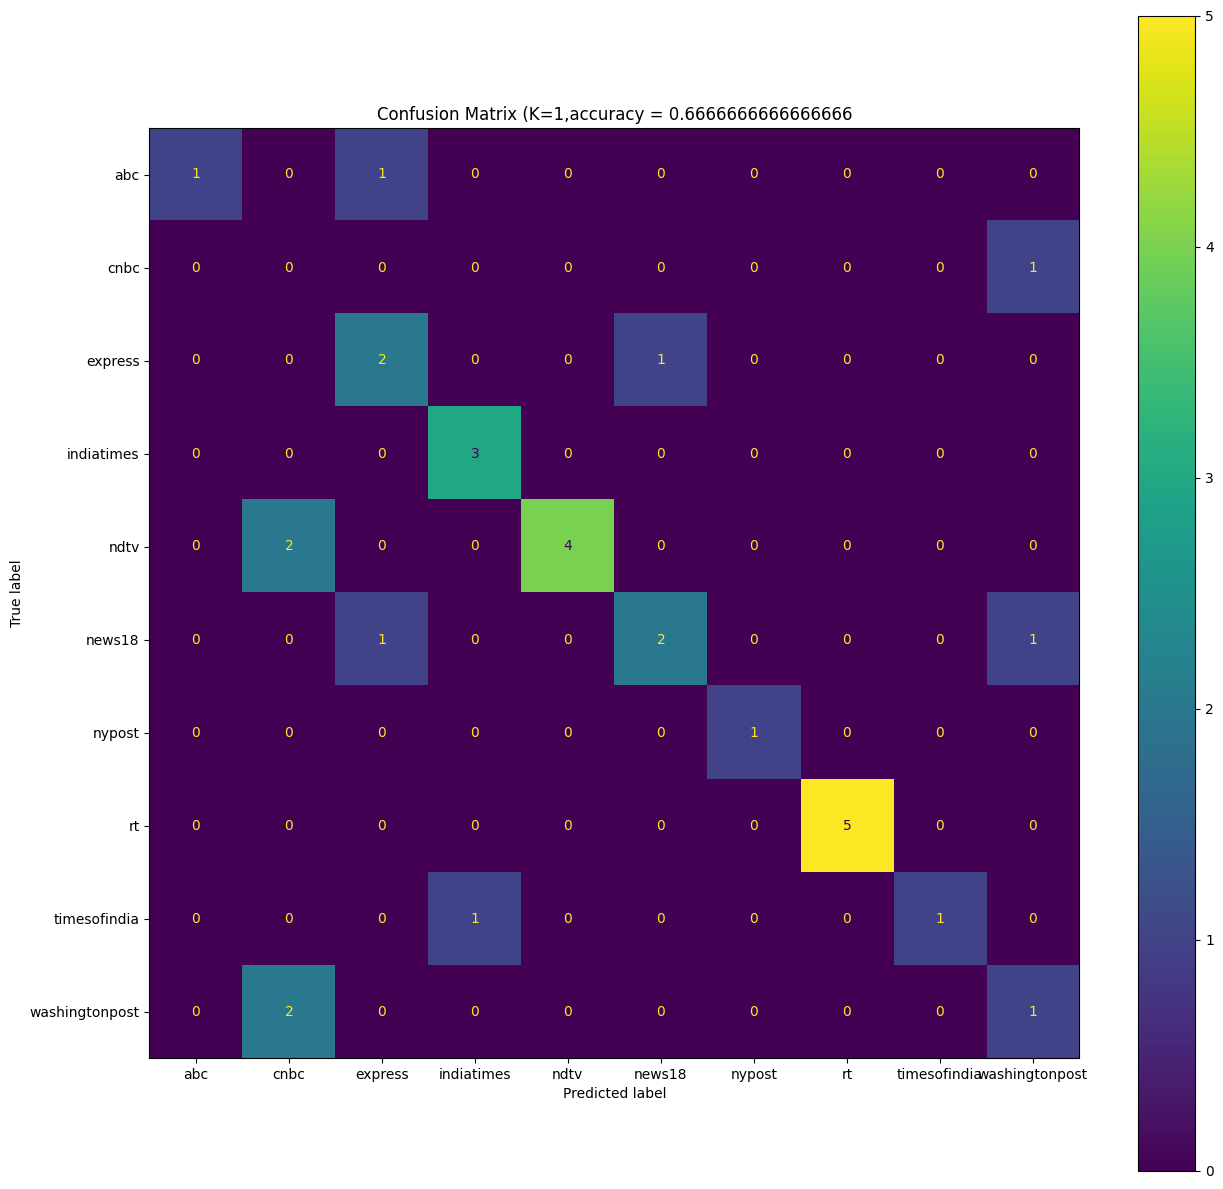

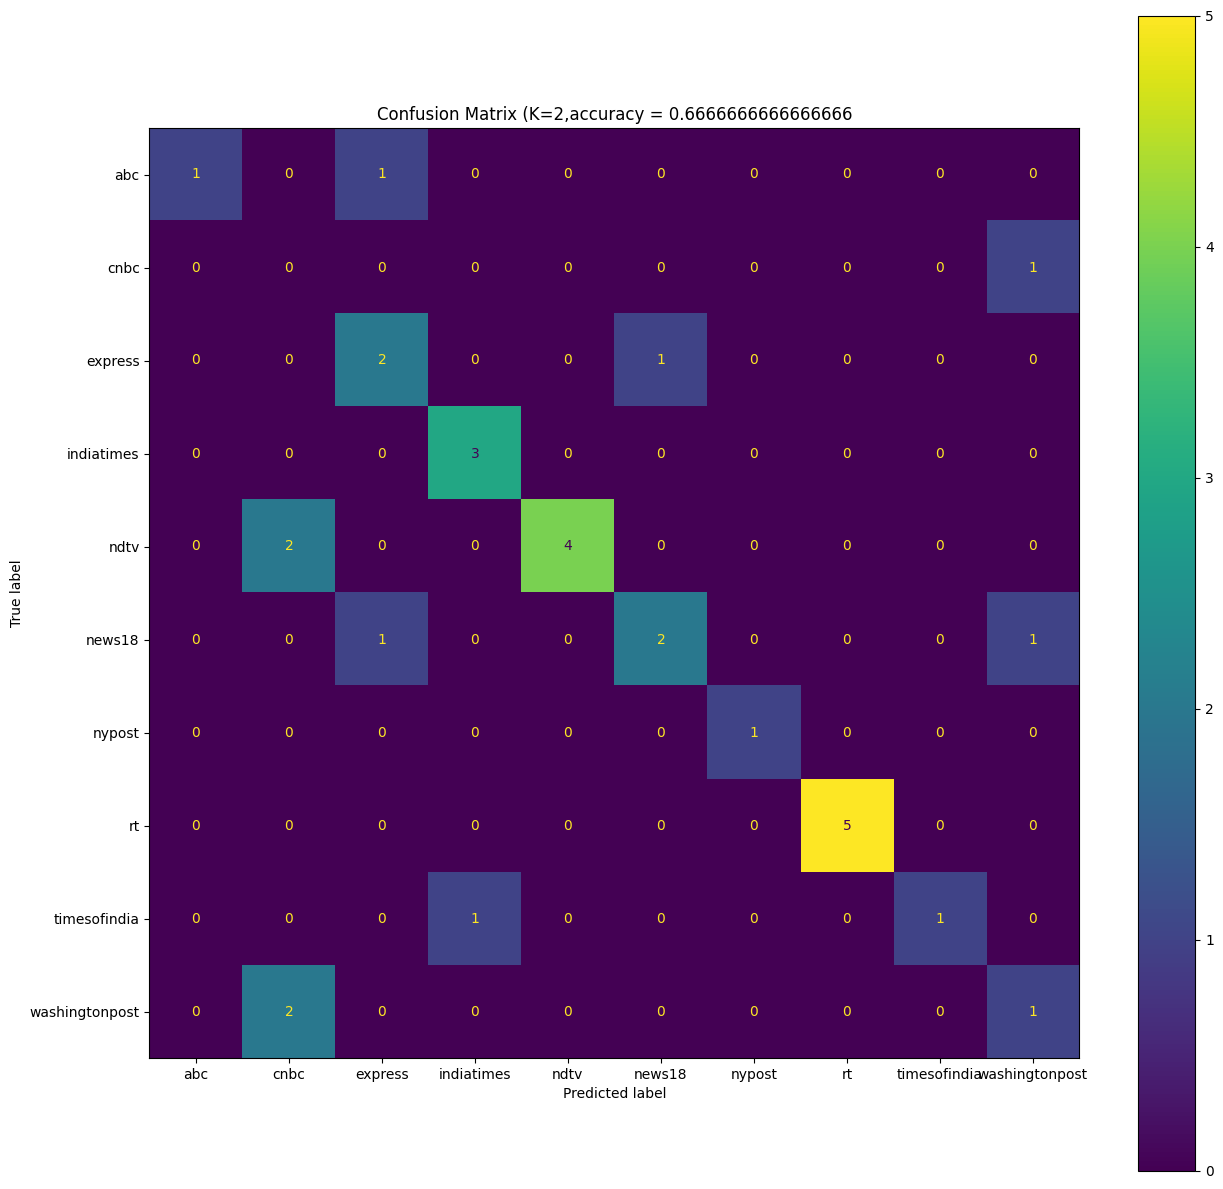

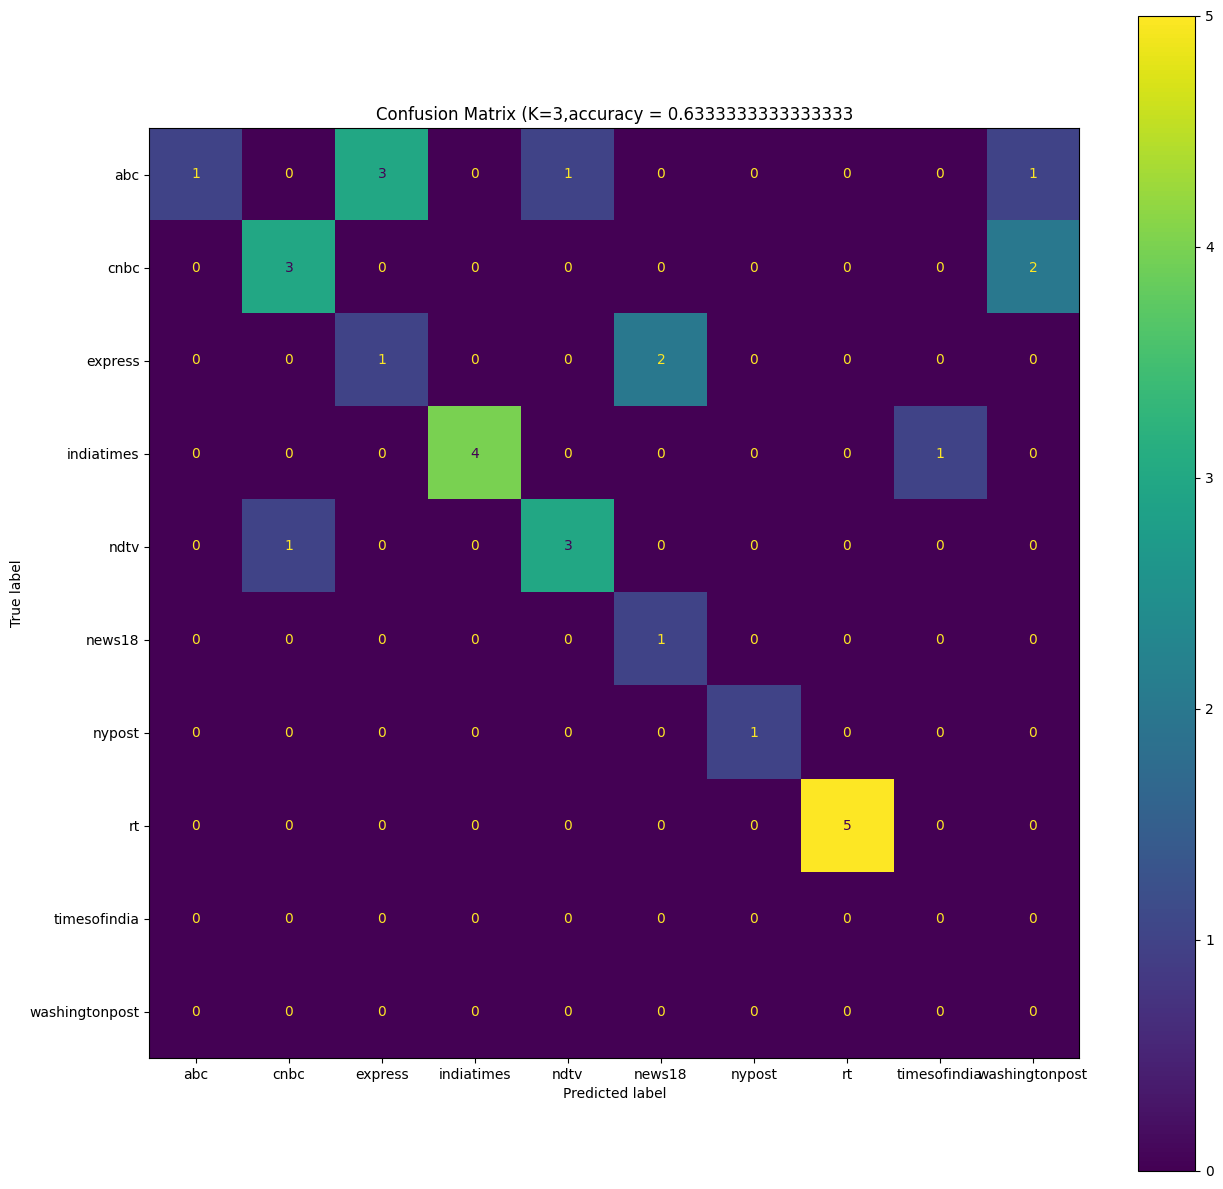

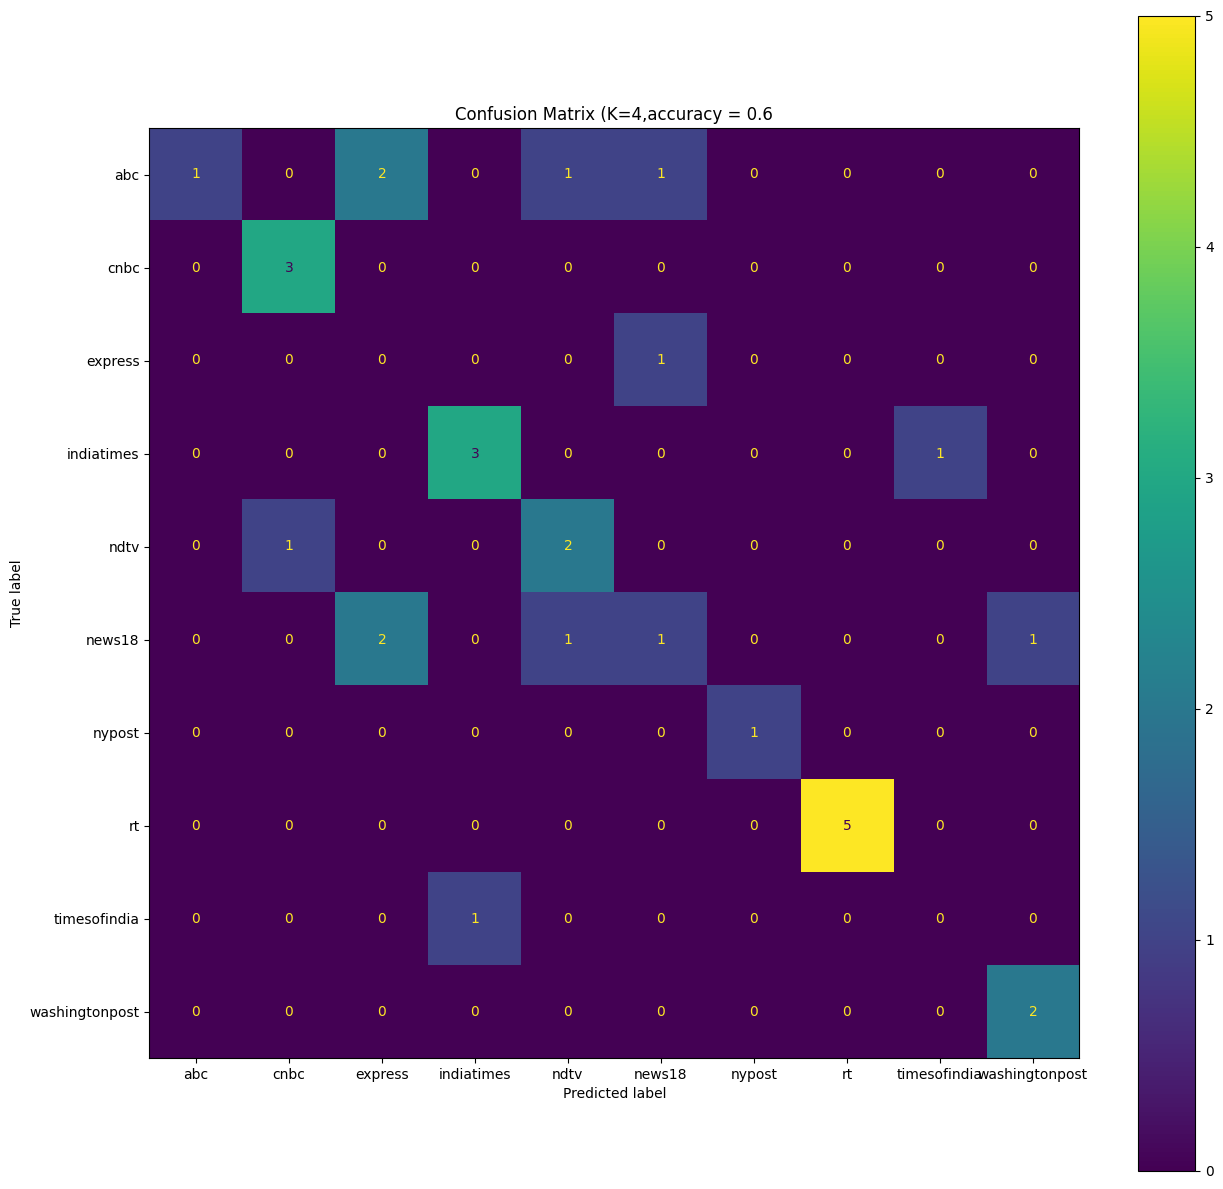

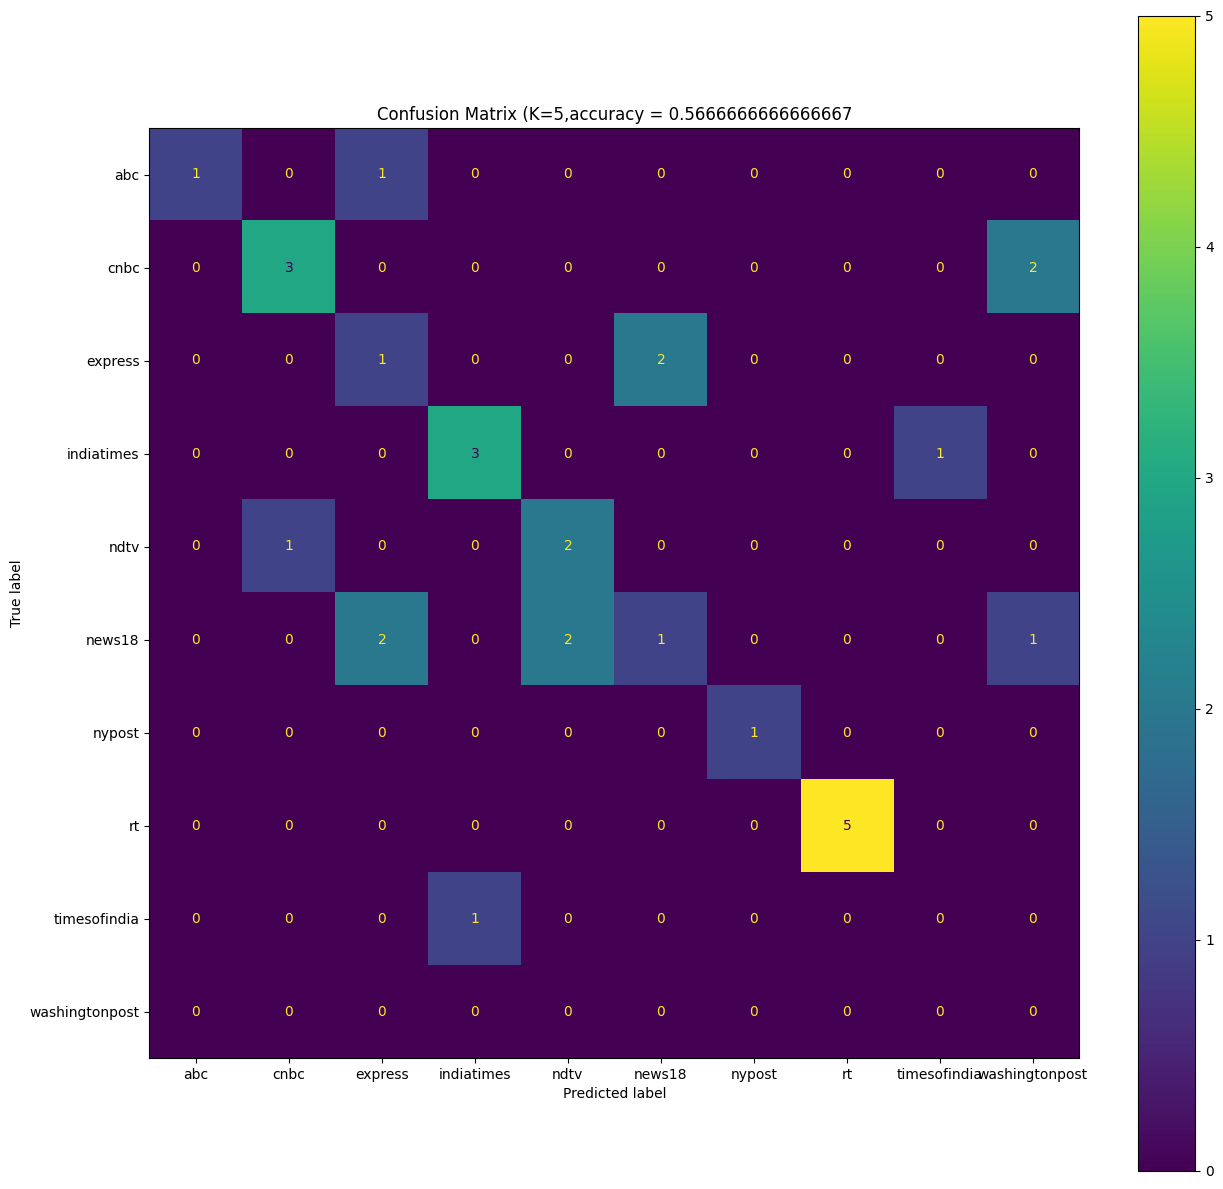

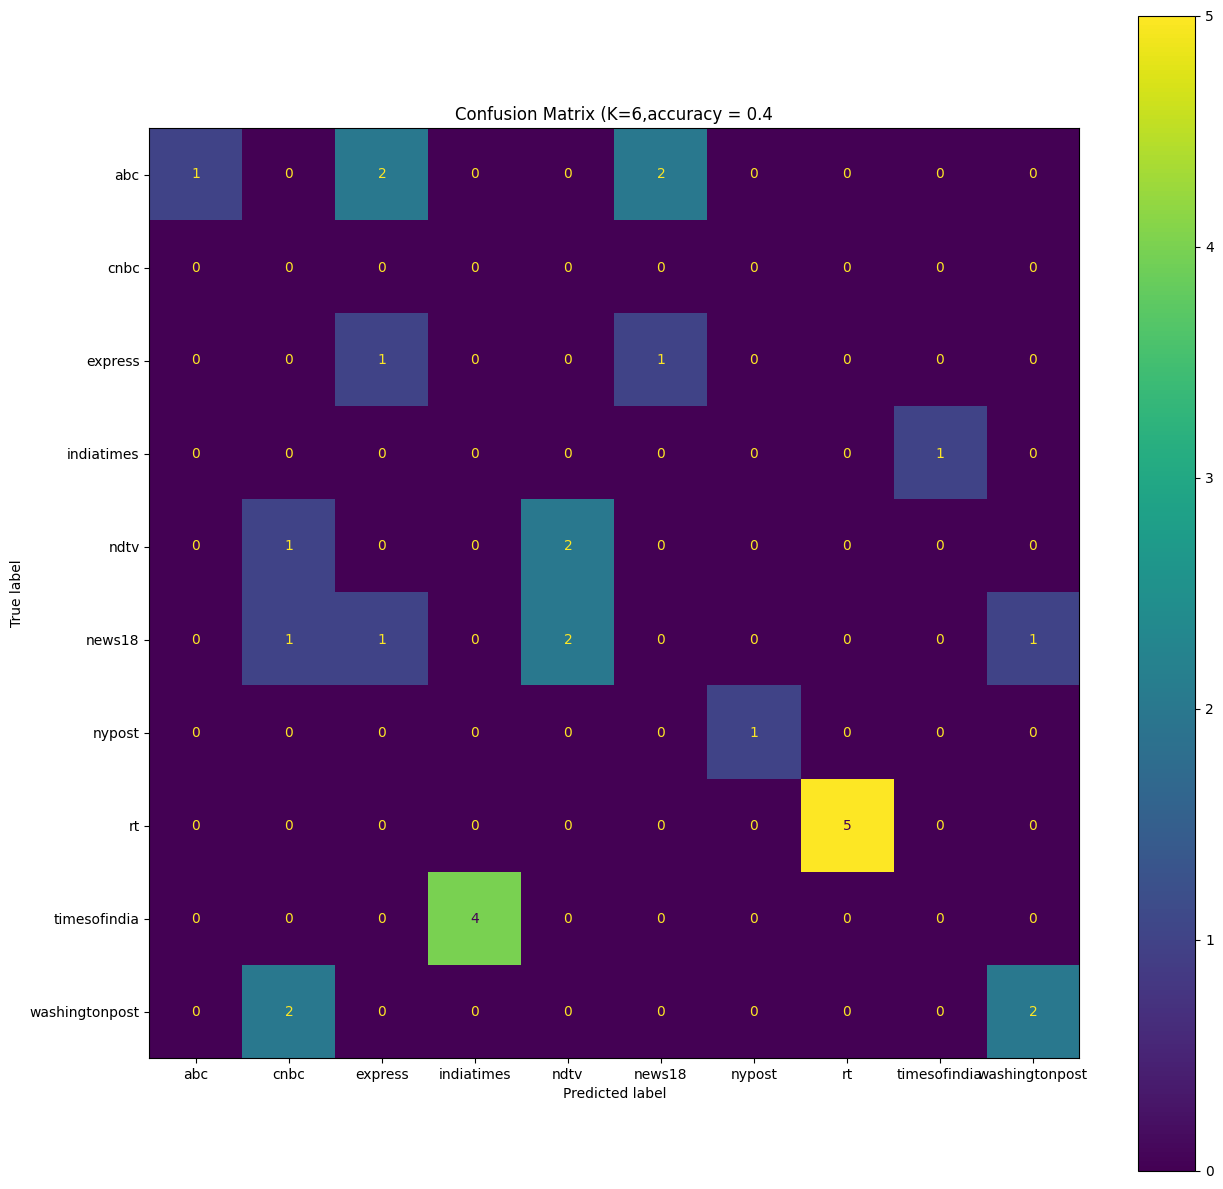

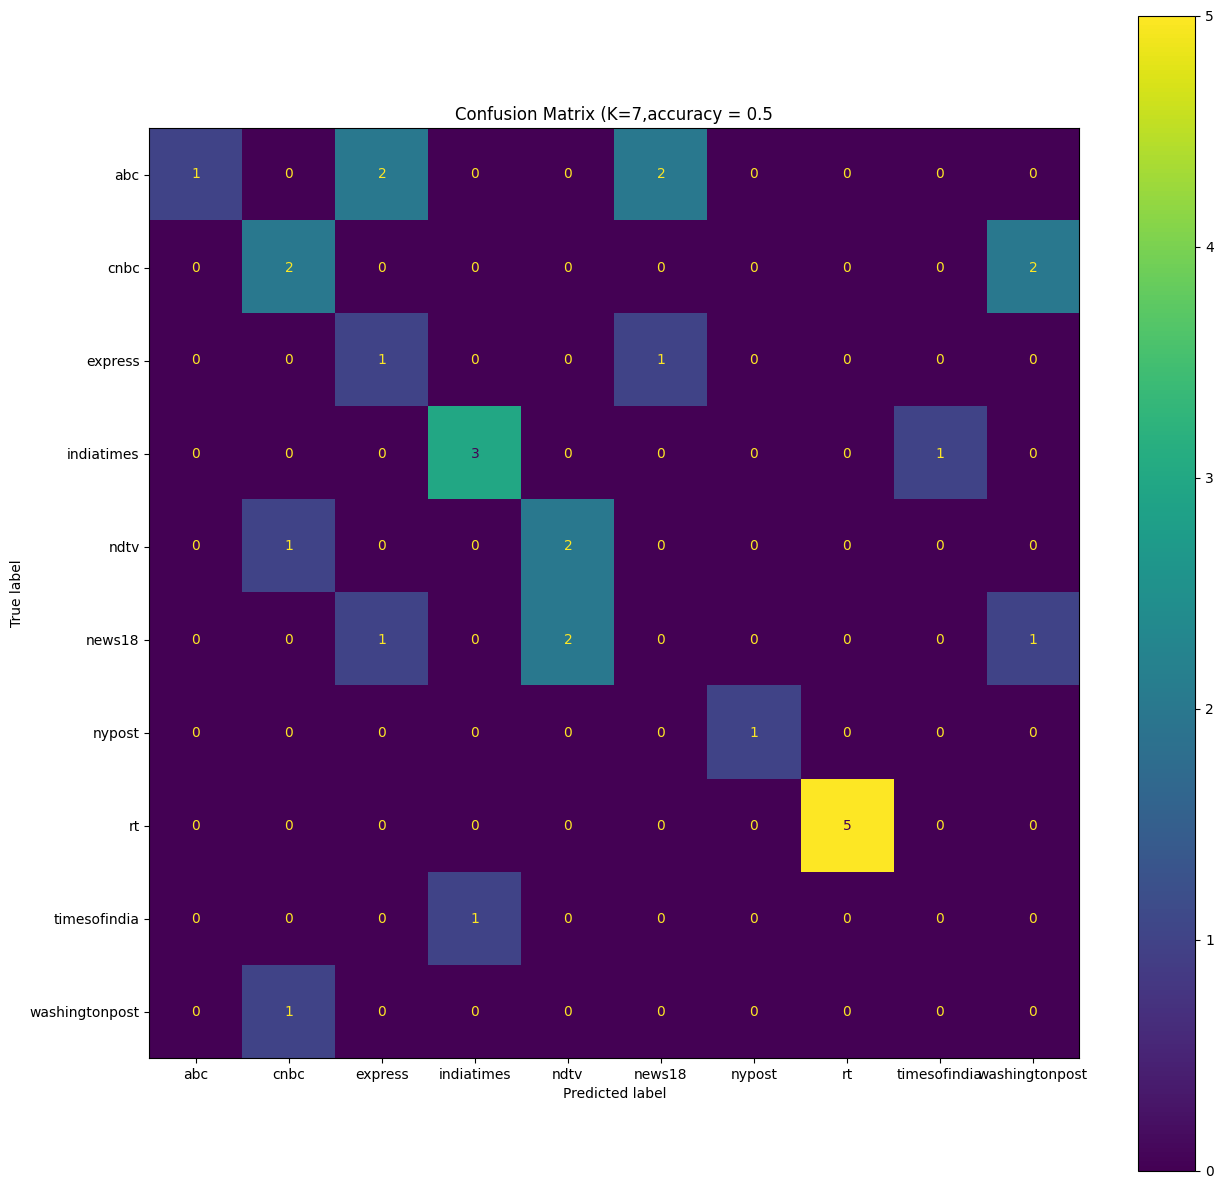

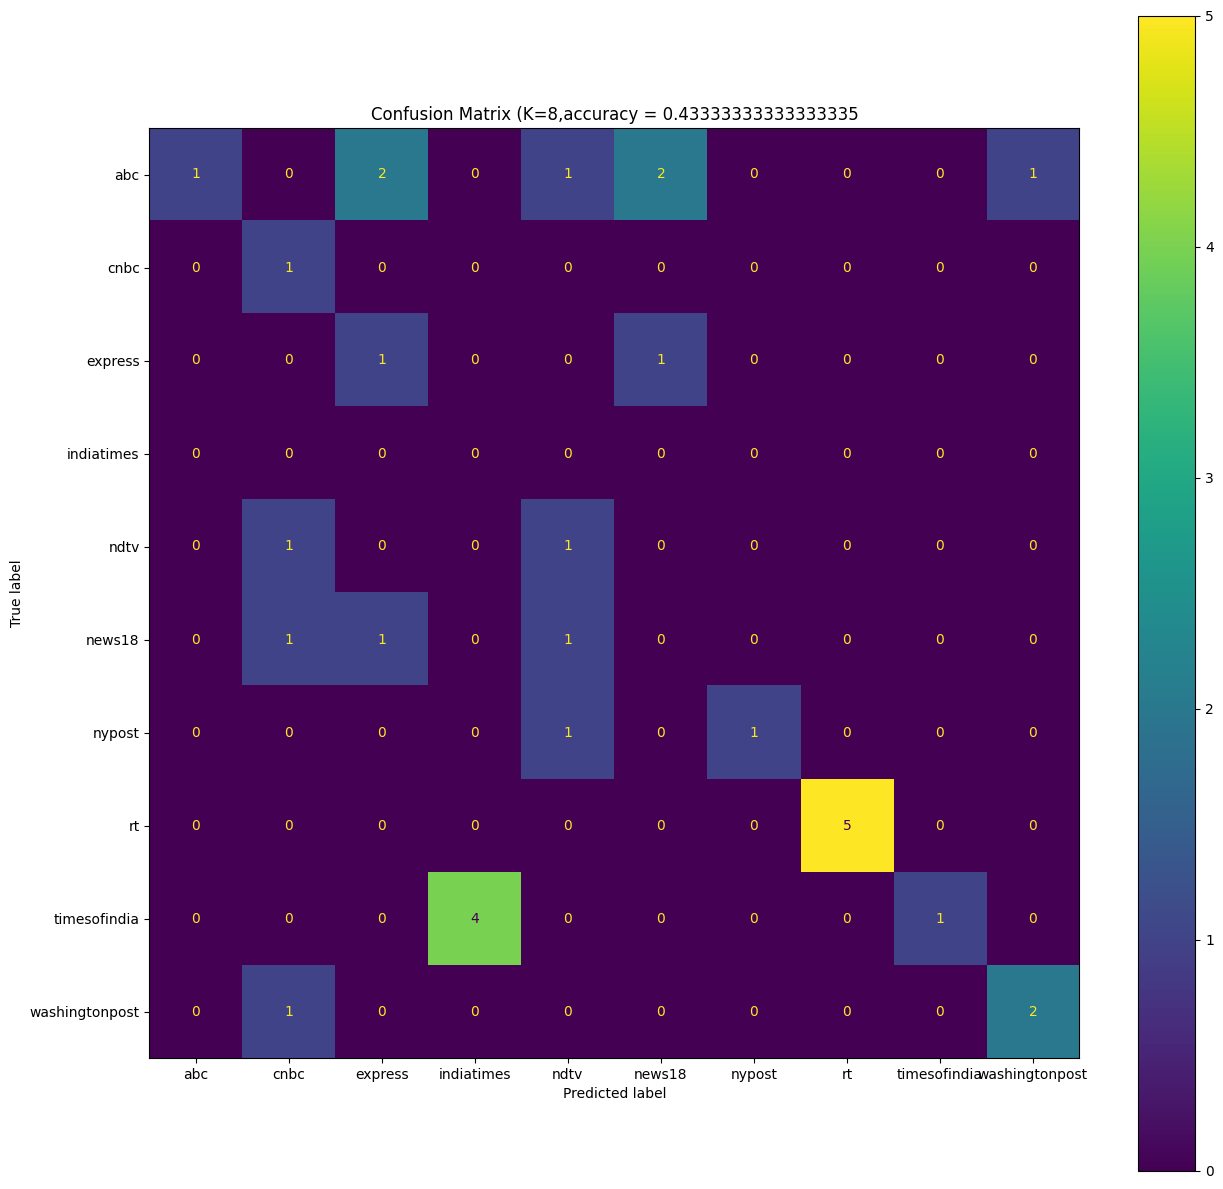

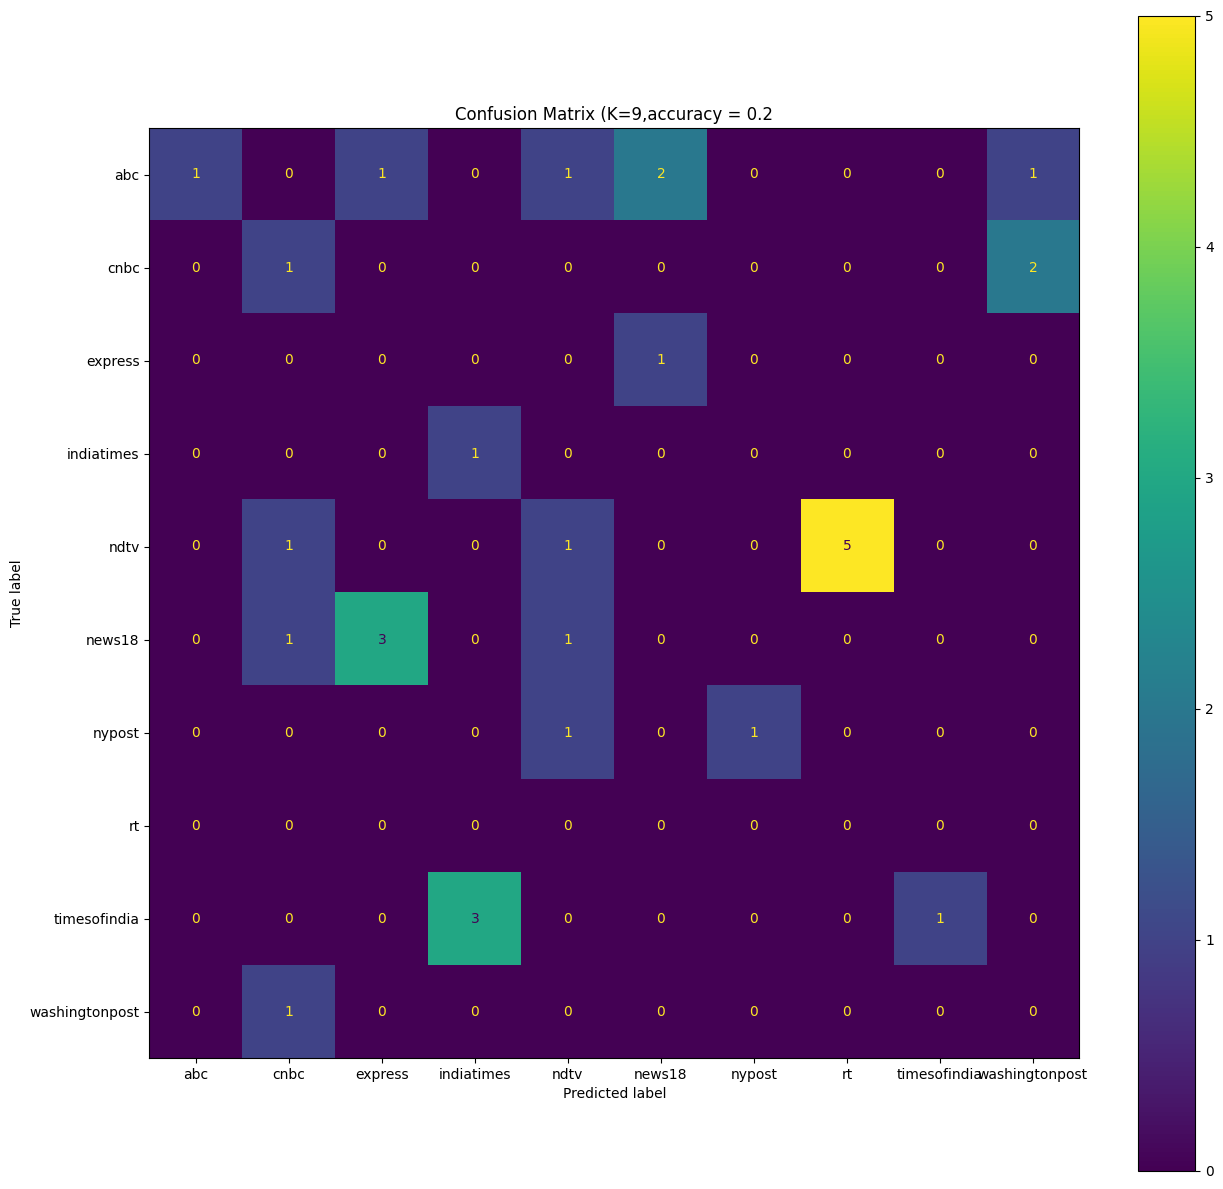

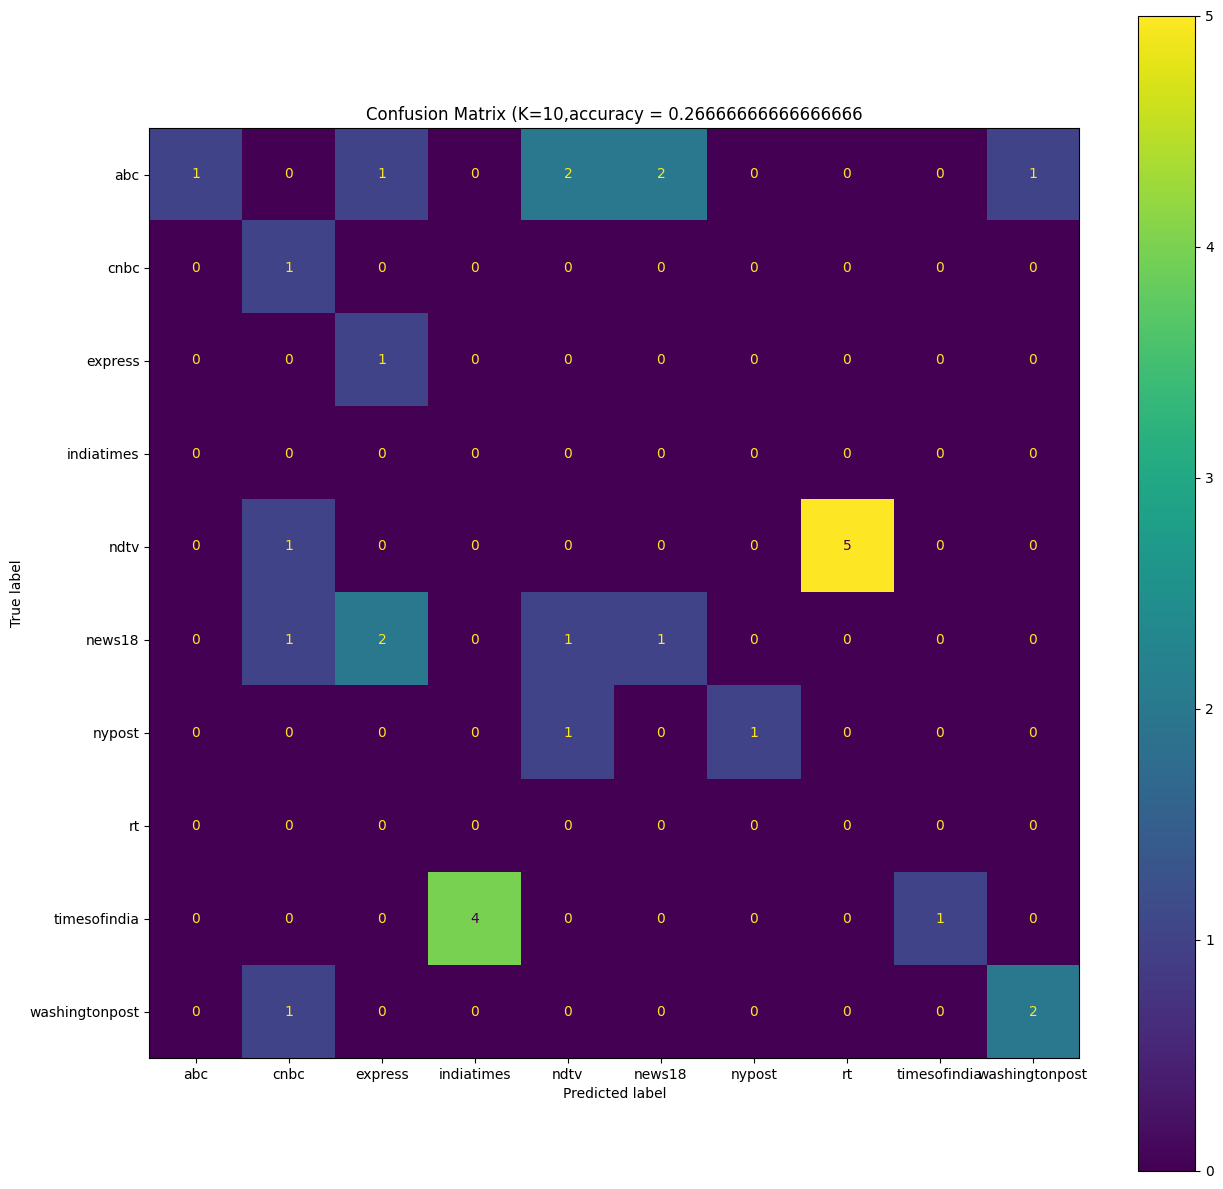

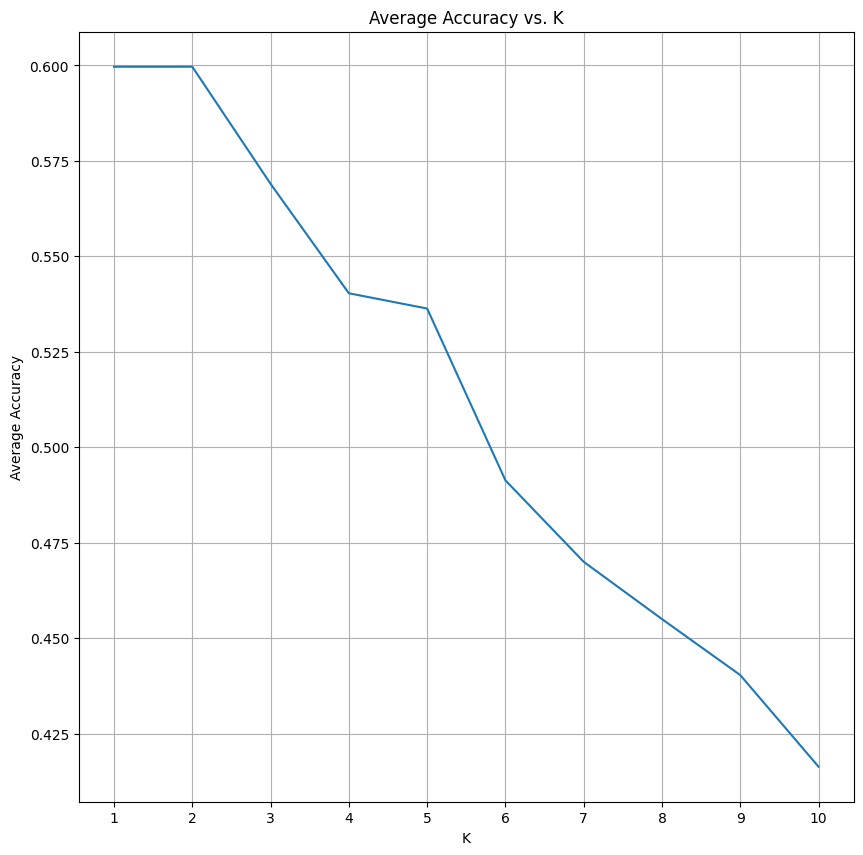

In [16]:
y_label = [0,0,0,0,0,0,0,0,0,0]
x_label = [1,2,3,4,5,6,7,8,9,10]
for i in range(0, 100):
  X = cumulative_dataset.dropna()
  APP = X['app']
  X = X.drop(['app'], axis=1)

  # Take a random train and test dataset to be split

  idx = np.random.permutation(len(X))
  num_train_obs = np.floor(0.7 * len(X))

  train_idx = idx[1:int(num_train_obs)]
  test_idx = idx[int(num_train_obs):]

  # normalization Actually standardization
  X_norm = pd.DataFrame()
  for key in X:
      temp = X[key]
      temp_norm = (temp - temp.mean()) / temp.std()
      X_norm[key] = temp_norm

  # split train / test
  X_norm_train = X_norm.iloc[train_idx]
  X_norm_test = X_norm.iloc[test_idx]

  APP_train = APP.iloc[train_idx]
  APP_test = APP.iloc[test_idx]


  Y_label = K_NN(X_norm_test,X_norm_train,APP_test, APP_train, i)
  y_label = [a + b for a, b in zip(Y_label, y_label)]


y_label = y_label = [value * 0.01 for value in y_label]
plt.figure(figsize=(10, 10))
plt.plot(x_label, y_label)
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.title("Average Accuracy vs. K")
plt.xlabel("K")
plt.ylabel("Average Accuracy")
print(f"The accuracy of KNN is {y_label}")

# ***Compare the results with the previous approach***
We can see the method of fingerprint is not well as previous method. comparing with the old data, the accuracy of knn is low. Because the cumulative trace is similar in the first servel points.\
But comparing with the method that training dataset is the old data and testing data is the new data which is captured after 1 day, the accuracy is higher. The reason is the new data' feature is not abosulitly same as old data like previous analysis.\
This similarity is that the performace is reduced as the k inscreasing, when the k is bigger than 2, the performance of our classifier decreased significantly.